<a name="outline"></a>
# Predicting Visual Perception in Mice with Neuropixel Data

>   The goal of this project is to predict the visual stimulus presented to mice based on the firing network of the synapses between their neurons. We utilize data from the Ecephys Project, which employs Neuropixel technology to record large-scale neural activity. The neural activity, called action potentials, is the a electrical signal generated by the movement of charged ions across the membrane of a neuron. Each unique action potential can also be referred to as a unit. The following analysis includes creating a binned binary spike train dataset from the spike trains given by the Allen Institute, visualizing useful information, and applying deep learning as well as machine learning techniques for image prediction.

</div>
<img src="pictures/Hyper Parameter Tuning.png" width="500" height="800" alt="Alt text"/>
</div>

## ***Index***

<a name="step0"></a>

### 0. Load Pre-Processed Data
*** Skip if data hasn't been processed. ***

    If one has already completed step 1, load the data here. 
    If not, then complete step 1 first.
    
- 0.1) Load the dataset with spike times in hertz.
- 0.2) Normalize Firing Rates to z scores.
- 0.3) Load the pre-normalized data.

[Go to Step 0](#step0content)

<a name="step1"></a>
### 1. Pull and Process Data
*** Skip if data is pre-processed. ***

    Pull data from the Ecephys repository, process it, then save it to a pickle file.

- 1.1) Download and load necessary packages. 
- 1.2) Create an instance on local computer. 
- 1.3) Choose session an pull data.
- 1.4) Filter invalid spike times.
- 1.5) Bin the data. 
        -1.5.1) Bin the whole experiment.
        -1.5.2) Bin by frame in seconds.
        -1.5.3) Bin by frame in steps.
        -1.5.4) Bin by frame in steps and in parallel. 
- 1.6) Create frame column and save spike times as a dataframe.
- 1.7) Normalize Firing Rates and save normalized firing rates as a dataframe.
    

[Go to Step 1](#step1content)

<a name="step2"></a>
### 2. Visualize the Data

    Here we will run visualizations to explore the information relevant to predicting visual perception with the data.

- 2.0) Pull image data from the Allen SDK Package.
- 2.1) All natural scenes presented by their frame number. 
- 2.2) 2.2) Visualize the unique firing pattern of different single units(usually a single neuron).
- 2.3) Raster plot of the spike trains for single units over the course of the natural scene testing. 
- 2.4) Sorted correlation matrix between single units.
- 2.5) Grouped Heat Maps of Unit Resposes by Frames
- 2.6) T-SNE Plot All Neurons
- 2.7) Average firing rates of units during each frame, in Hertz and by Z scores.

[Go to Step 2](#step2content)

<a name="step3"></a>
### 3. Image Prediction Modeling
    
    The purpose of this section is to...
    1. Employ various machine learning and deep learning techniques to predict the visual stimulus given the data.
    2. Produce directed adjacency matrices using a Spatio-Temporal Graph Neural Network. These adjacency matrices may represent the directed functional connectomics between units, usually single neurons, during each frame.
    3. Visualize the network of single units over time.

- 3.0) Create train splits, test splits, and a correlation-based adjacency matrix.
- 3.1) Baseline Model: a random guess with an accuracy of 0.85% (1/118).
- 3.2) Support Vector Machine with Radial Basis Function.
- 3.3) Principal Component Regression.
- 3.4) Neural Network with one hidden layer.
- 3.5) Long-Short Term Memory model.
- 3.6) Build a Static Graph Neural Network.
- 3.7) Build a Simple Graph Convolution.
- 3.8) Build a Graphsage.
- 3.9) Build a static ST-GNN.
- 3.10) Dynamic STGNN with adjacency matrix for each frame.
- 3.11) Dynamic STGNN with adjacency matrix for each timestep and frame.

[Go to Step 3](#step3content)


## References
[Go to References](#references)

<a name="step1content"></a>
## 1. Pull and Process Data or Load Pre-Processed Data
[Go to Outline](#outline)

*** Setup the environment. ***

In [3]:
# Setup Environment
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import psutil
import time
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import SVR
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
import torch
import seaborn as sns
import pickle
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv
from torch.nn import Linear
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor
import time
from data_processors.pull_and_process_data import master_function

if torch.cuda.is_available():
    print("CUDA GPU is available.")
    device = torch.device('cuda')
else:
    print("CUDA GPU is not available. Using CPU instead.")
    device = torch.device('cpu')
    
print(f"Current GPU device: {torch.cuda.get_device_name(torch.cuda.current_device())}")
print(f"Total RAM: {(psutil.virtual_memory().total / (1024**3)):.2f} GB")
print(f"Available RAM: {(psutil.virtual_memory().available / (1024**3)):.2f} GB")

/nas/longleaf/home/rayrayc/.local/lib/python3.9/site-packages/torch_geometric/typing.py:31: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /nas/longleaf/home/rayrayc/.local/lib/python3.9/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZNSt15__exception_ptr13exception_ptr9_M_addrefEv
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/nas/longleaf/home/rayrayc/.local/lib/python3.9/site-packages/torch_geometric/typing.py:42: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /nas/longleaf/home/rayrayc/.local/lib/python3.9/site-packages/torch_sparse/_convert_cuda.so: undefined symbol: _ZNSt15__exception_ptr13exception_ptr9_M_addrefEv
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


CUDA GPU is available.
Current GPU device: NVIDIA A100-PCIE-40GB MIG 2g.10gb
Total RAM: 1006.94 GB
Available RAM: 947.42 GB


In [ ]:
# Load packages needed for step 1.
!pip install -q allensdk

from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache 

In [ ]:
## 1. Pull and Process Data 
import time
from data_processors.pull_and_process_data import master_function

mouse_number = 715093703

spike_df, normalized_firing_rates = master_function(session_number=mouse_number, output_dir="output", timesteps_per_frame=10)

In [ ]:
## 0. Load Pre-Processed Data 
from load_processed_data import master_cleaning_and_saving

master_cleaning_and_saving(session_id= mouse_number, original_pickle_prefix = 'normalized_firing_rates')
normalized_firing_rates

<a name="step2content"></a>
## 2. Visualize the Data
[Go to Outline](#outline)

Here we will look at different aspects of the data we are concerned with. 

- 2.0) Pull image data from the Allen SDK Package.
- 2.1) All natural scenes presented by their frame number. 
- 2.2) 2.2) Visualize the unique firing pattern of different single units(usually a single neuron).
- 2.3) Raster plot of the spike trains for single units over the course of the natural scene testing. 
- 2.4) Sorted correlation matrix between single units.
- 2.5) Grouped Heat Maps of Unit Resposes by Frames
- 2.6) T-SNE Plot All Neurons
- 2.7) Average firing rates of units during each frame, in Hertz and by Z scores.

### 2.0) Pull image data from the Allen SDK Package.

*** To set up the environment. *** \
1st, run 2.0.1. \
2nd, run 2.0.2 if one hasn't already calculated the average firing rate per frame. If they haven't been calculated, run 2.0.3 to load them in.

#### 2.0.1) Run Cell to set up environment for visualizations.

In [ ]:
# Load packages needed for step 1.
!pip install -q allensdk

from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# Define Carolina blue color (in RGB format)
carolina_blue = (86/255, 160/255, 211/255)

# Set output directory to a new folder called 'output' in the current working directory
output_dir = os.path.join(os.getcwd(), 'output')

# Check if the output directory exists, and create it if it doesn't
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Set DOWNLOAD_COMPLETE_DATASET to True
DOWNLOAD_COMPLETE_DATASET = True

# Create a file path to the manifest.json file within the output directory
manifest_path = os.path.join(output_dir, "manifest.json")

# Check if the manifest.json file exists
if os.path.exists(manifest_path):
    print("Using existing manifest.json file.")
else:
    print("Creating a new manifest.json file.")

# Create an instance of the EcephysProjectCache class with the manifest file path as argument
cache = EcephysProjectCache(manifest=manifest_path)
# Get session table
session_table = cache.get_session_table()

'''
 Pick session number
 '''
 
session_number = 721123822

# Pull session.
session = cache.get_session_data(session_number,
                                 isi_violations_maximum = np.inf,
                                 amplitude_cutoff_maximum = np.inf,
                                 presence_ratio_minimum = -np.inf
                                )
# Get spike times.
spike_times = session.spike_times
# Get specific stimulus table.
stimulus_table = session.get_stimulus_table("natural_scenes")

# Display objects within session.
print("Session objects")
print([attr_or_method for attr_or_method in dir(session) if attr_or_method[0] != '_'])

#### 2.0.2) Calulate the firing rates per frame, average firing rate per image, and average firing rate per second.

Calculate the average firing rate per frame. 

In [ ]:
# Parameters
timesteps_per_frame = 1  # Set the number of timesteps per frame

# Stimulus table.
stimulus_table = session.get_stimulus_table("natural_scenes")

# The start times of each stimulus presentation
image_start_times = torch.tensor(stimulus_table.start_time.values)

# The end times of each stimulus presentation
image_end_times = torch.tensor(stimulus_table.stop_time.values)

# The duration of each image presentation
image_durations = image_end_times - image_start_times

# The bin size for each image presentation
bin_sizes = image_durations / timesteps_per_frame

# The number of bins per image presentation
bins_per_image = timesteps_per_frame

# The total number of bins
total_bins = bins_per_image * len(image_start_times)

# Create an empty binary spike matrix
num_neurons = len(spike_times.keys())

def process_neuron(times):
    # The start bin for the next image presentation
    start_bin = 0
    neuron_spike_bins = torch.zeros(total_bins, dtype=torch.int32)
    for image_idx, (start_time, end_time) in enumerate(zip(image_start_times, image_end_times)):
        # Bin edges for this image presentation
        bin_edges = torch.linspace(start_time, end_time, bins_per_image + 1)

        # Bin the spike times for this image presentation
        binned_spike_times = torch.histc(torch.tensor(times), bins=bin_edges.shape[0]-1, min=bin_edges.min(), max=bin_edges.max())

        # Add the binned spike times to the spike matrix
        end_bin = start_bin + bins_per_image
        if len(binned_spike_times) == len(neuron_spike_bins[start_bin:end_bin]):
            neuron_spike_bins[start_bin:end_bin] = binned_spike_times

        # Update the start bin for the next image presentation
        start_bin = end_bin
    return neuron_spike_bins

with concurrent.futures.ProcessPoolExecutor() as executor:
    spike_matrix = list(tqdm(executor.map(process_neuron, spike_times.values()), total=num_neurons, desc='Processing neurons'))

spike_matrix = torch.stack(spike_matrix)

# Convert the spike matrix to a pandas DataFrame and set the index to neuron IDs
spike_dataframe = pd.DataFrame(spike_matrix.numpy(), index=spike_times.keys())

spikes_per_frame = spike_dataframe.T
spikes_per_frame['frame'] = 'nan'
spikes_per_frame['frame'] = np.array(stimulus_table['frame'])
spikes_per_frame

Calculate spikes per image by taking the average of the spikes_per_frame calculation.

In [ ]:
spikes_per_image = spikes_per_frame.groupby('frame').mean().iloc[1:,1:]
spikes_per_image.reset_index(inplace=True)
spikes_per_image

Estimate the average spikes per second or firing rate in Hertz by multiplying spikes_per_image by 4. Each frame is roughly a quarter second. One can compute the actual average but that is much more computationally intensive(over 7500 times more intesnive). 

In [ ]:
firing_rate_hz = spikes_per_image * 4
firing_rate_hz['frame'] = spikes_per_image['frame']
firing_rate_hz

Save them all

In [ ]:
# Save the dictionary of valid spike times to a pickle file
with open(f'spikes_per_frame_{session_number}.pkl', 'wb') as f:
    pickle.dump(spikes_per_frame, f)
    
# Save the dictionary of valid spike times to a pickle file
with open(f'spikes_per_image_{session_number}.pkl', 'wb') as f:
    pickle.dump(spikes_per_image, f)

# Save the dictionary of valid spike times to a pickle file
with open(f'firing_rate_hz_{session_number}.pkl', 'wb') as f:
    pickle.dump(firing_rate_hz, f)

#### 2.0.3) Load the firing rates per frame, average firing rate per image, and average firing rate per second.

In [ ]:
spikes_per_frame = 'spikes_per_frame_721123822.pkl'
spikes_per_image = 'spikes_per_image_721123822.pkl'
firing_rate_hz = 'firing_rate_hz_721123822.pkl'

# Load the dictionary of valid spike times from the pickle.
with open(spikes_per_frame, 'rb') as f:
    spikes_per_frame = pickle.load(f)

# Load the dictionary of valid spike times from the pickle.
with open(spikes_per_image, 'rb') as f:
    spikes_per_image = pickle.load(f)

# Load the dictionary of valid spike times from the pickle.
with open(firing_rate_hz, 'rb') as f:
    firing_rate_hz = pickle.load(f)
    
print(np.shape(spikes_per_frame))
print(np.shape(spikes_per_image))
print(np.shape(firing_rate_hz))

### 2.1) All natural scenes presented by their frame number. 

In this experiment mice were shown 118 different images of natural scenes around 50 times per image. These images are the events we are trying to predict given the firing rate of each unit.

- Below are all of the images shown.

In [ ]:
natural_scenes = session.stimulus_presentations[session.stimulus_presentations['stimulus_name']=='natural_scenes']

# Pull from where images are located.
boc = BrainObservatoryCache(manifest_file='boc/manifest.json')
data_set = boc.get_ophys_experiment_data(501498760)

# Show all scenes.
scene_nums = np.arange(0)

# read in the array of images
scenes = data_set.get_stimulus_template('natural_scenes')

try:
    fig, axes = plt.subplots(12, 10, figsize=(20, 20))
    for i, ax in enumerate(axes.flat):
        ax.imshow(scenes[i], cmap='gray')
        ax.set_axis_off()
        ax.set_title('scene %d' % i)
except IndexError:
    pass # ignore the IndexError and continue running the code

- Below shows when two different images were shown.

In [ ]:
### Choose specific scenes to explore.
scene_nums = [1,50]

### Thank you to http://alleninstitute.github.io/AllenSDK/_static/examples/nb/brain_observatory_stimuli.html for this chunk.
boc = BrainObservatoryCache(manifest_file='boc/manifest.json')
data_set = boc.get_ophys_experiment_data(501498760)

# read in the array of images
scenes = data_set.get_stimulus_template('natural_scenes')

# Define a function that takes two arguments: a dataframe containing information about stimulus trials and a title for the plot.
# The function plots the times each specified stimulus occurs throught the timeframe.
def plot_stimulus_table(natural_scenes, title):
    fstart = natural_scenes.start_time.min()
    fend = natural_scenes.stop_time.max()
    
    fig = plt.figure(figsize=(15,1))
    ax = fig.gca()
    # Loop over each trial in the dataframe
    for i, trial in natural_scenes.iterrows():    
        # Calculate the start and stop times for the trial.
        x1 = float(trial.start_time - fstart) / (fend - fstart)
        x2 = float(trial.stop_time - fstart) / (fend - fstart)      
        # Add a rectangle to the plot.
        ax.add_patch(patches.Rectangle((x1, 0.0), x2 - x1, 1.0, color='r'))
        
    ax.set_xticks((0,1))
    ax.set_xticklabels((int(np.round(fstart)), int(np.round(fend))))
    ax.set_yticks(())
    ax.set_title("Timestamps where the Specific Scenes Appears \n During the Natural Scenes")
    ax.set_xlabel(title)

# read in the array of images
scenes = data_set.get_stimulus_template('natural_scenes')

# display a couple of the scenes
fig, axes = plt.subplots(1,len(scene_nums))
for ax,scene in zip(axes, scene_nums):
    ax.imshow(scenes[scene,:,:], cmap='gray')
    ax.set_axis_off()
    ax.set_title('scene %d' % scene)
    
# build up a mask of trials for which one of a list of scenes is visible
trial_mask = natural_scenes.frame == -2
for scene in scene_nums:
    trial_mask |= (natural_scenes.frame == scene)
natural_scenes = natural_scenes[trial_mask]

# plot the trials
plot_stimulus_table(natural_scenes, "scenes %s " % scene_nums)

### 2.2) Visualize the unique firing pattern of different single units(usually a single neuron).

This unique firing pattern allows one to differenciate between two possible neurons(units) and create a unique spike train for each.

In [ ]:
# Get the mean spike waveforms for each neuron
mean_waveforms = session.mean_waveforms

# Number of waveforms to display (you can change this value)
n_waveforms = 10
unit_ids = session.units.index.values

# Plot the mean spike waveforms for the first n_waveforms neurons
fig, axes = plt.subplots(n_waveforms, 1, figsize=(8, 2 * n_waveforms), sharex=True)
for i, (unit_id, ax) in enumerate(zip(unit_ids[:n_waveforms], axes)):
    waveform = mean_waveforms[unit_id]
    ax.plot(waveform.T)
    ax.set_title(f'Neuron {unit_id} Mean Waveform')
    ax.set_ylabel('Amplitude')
    ax.label_outer()

plt.xlabel('Time (samples)')
plt.tight_layout()
plt.show()


### 2.3) Raster plot of the spike trains for single units over the course of the natural scene testing. 

When the spike trains are created for each unique unit, they produce a 1 for every spike and 0 if they are not spiking at each timestep. The spike trains are plotted below for a few unique units over the natural scene time frame.

*** Add Raster Plot for binned data. ***

In [ ]:
natural_scenes = session.stimulus_presentations[session.stimulus_presentations['stimulus_name'] == 'natural_scenes']
available_unit_ids = session.spike_times.keys()
all_spike_times = {unit_id: session.spike_times[unit_id] for unit_id in available_unit_ids}
units = cache.get_units()

# Create a function to build a raster plot.
def visualize_spike_data(num_units_to_visualize, all_spike_times, units, start_time=0, end_time=10, num_timesteps=30):
    # Select a subset of units to plot
    available_unit_ids = list(all_spike_times.keys())
    subset_unit_ids = available_unit_ids[:num_units_to_visualize]

    # Calculate the time_interval (in seconds) from the first unit's sampling rate
    time_interval = 1 / units.iloc[0]['sampling_rate']

    # Create the raster plot
    fig, ax = plt.subplots(figsize=(12, 6))

    for i, unit_id in enumerate(subset_unit_ids):
        spike_times = all_spike_times[unit_id]

        # Filter the spike times based on start_time and end_time
        filtered_spike_times = [t for t in spike_times if start_time <= t <= end_time]

        ax.scatter(filtered_spike_times, [i] * len(filtered_spike_times), marker='|')

    ax.set_xlim([start_time, end_time])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Unit')
    ax.set_yticks(range(len(subset_unit_ids)))
    ax.set_yticklabels(subset_unit_ids)
    ax.set_title('Raster plot for a subset of units')

    plt.show()

    # Create an array of time bins
    time_bins = np.arange(start_time, start_time + num_timesteps, time_interval)

    # Only consider the first 'num_timesteps' time bins
    time_bins = time_bins[:num_timesteps]

    # Initialize an empty DataFrame with the time bins as the index
    spike_counts_df = pd.DataFrame(index=time_bins[:-1])

    # Iterate through the units and count the spikes in each time bin
    for unit_id in subset_unit_ids:
        spike_times = all_spike_times[unit_id]
        spike_counts, _ = np.histogram(spike_times, bins=time_bins)
        spike_counts_df[unit_id] = spike_counts

    # Rename the index
    spike_counts_df.index.name = 'Time (s)'

    return spike_counts_df

# Example usage:
num_units_to_visualize = 10
start_time = natural_scenes.start_time.min()
end_time = natural_scenes.stop_time.max()
num_timesteps = 1000

spike_counts_df = visualize_spike_data(num_units_to_visualize, all_spike_times, units, start_time, end_time, num_timesteps)
print('The following is the first 1000 timesteps of the data visualized. 1/30,000th of a second.')
print(np.unique(spike_counts_df))
spike_counts_df

### 2.4) Sorted correlation matrix between single units.

Below is a sorted correlation matrix between units based on their firing rates. A clustering method called Agglomerative hierarchical cluster was group the correlation matrix.  

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

X = filtered_normalized_firing_rates.drop(columns=['frame'])

### This function calculates the correlation coefficient between each pair of neurons in the input matrix X (in our case, firing rates).
def custom_corrcoef(X):
    # Calculate the correlation coefficient matrix by taking the dot product of the normalized matrix and its transpose
    # Divide the result by the number of columns in X to normalize the sum
    return np.dot(X, X.T) / X.shape[1]

# Calculate the correlation matrix
corr_matrix = custom_corrcoef(X.T)

# Compute the hierarchical clustering
distance_matrix = 1 - np.abs(corr_matrix)
np.fill_diagonal(distance_matrix, 0)  # Set the diagonal to zero
linked = linkage(squareform(distance_matrix), method='average')  # The linkage function performs the cluster.

# Plot the heatmap with dendrogram-based sorting
sns.clustermap(corr_matrix, cmap='inferno', row_linkage=linked, col_linkage=linked, vmin=0, vmax=1)
plt.title("Sorted correlation matrix of firing rates")
plt.xlabel("Neuron index")
plt.ylabel("Neuron index")
plt.show()

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

X = filtered_normalized_firing_rates.drop(columns=['frame'])

### This function calculates the correlation coefficient between each pair of neurons in the input matrix X (in our case, firing rates).
def custom_corrcoef(X):
    # Calculate the correlation coefficient matrix by taking the dot product of the normalized matrix and its transpose
    # Divide the result by the number of columns in X to normalize the sum
    return np.dot(X, X.T) / X.shape[1]

# Calculate the correlation matrix
corr_matrix = custom_corrcoef(X.T)

# Compute the hierarchical clustering
distance_matrix = 1 - np.abs(corr_matrix)
np.fill_diagonal(distance_matrix, 0)  # Set the diagonal to zero
linked = linkage(squareform(distance_matrix), method='average') 

# Plot the heatmap with dendrogram-based sorting
sns.clustermap(corr_matrix, cmap='inferno', row_linkage=linked, col_linkage=linked, vmin=-1, vmax=1)
plt.title("Sorted correlation matrix of firing rates")
plt.xlabel("Neuron index")
plt.ylabel("Neuron index")
plt.show()

### 2.x) Show Correlation matrices between time steps.

### 2. 5) Grouped heat maps of unit responses by frames.

In [ ]:
def plot_filtered_normalized_firing_rates(df, num_frames):
    # Calculate the correlation between the firing rates and frames
    correlation_matrix = df.corrwith(df['frame'], method='spearman')

    # Sort neurons by their correlation with the 'frame' column
    sorted_neurons = correlation_matrix[df.columns[1:]].sort_values().index.tolist()

    # Filter the DataFrame based on the desired number of frames
    filtered_df = df.head(num_frames)

    # Sort neurons by their correlation with the 'frame' column
    sorted_filtered_df = filtered_df[['frame'] + sorted_neurons]

    # Sort the DataFrame by the 'frame' column
    sorted_filtered_df.sort_values(by='frame', inplace=True)

    # Set the 'frame' column as the index of the DataFrame
    sorted_filtered_df.set_index('frame', inplace=True)

    # Create a heatmap for the filtered and sorted DataFrame
    plt.figure(figsize=(20, 10))
    ax = sns.heatmap(sorted_filtered_df.T, cmap='viridis', yticklabels=False)

    # Get unique frame values
    unique_frames = sorted_filtered_df.index.unique()

    # Set x-ticks at the middle of each frame group
    ax.set_xticks([np.where(sorted_filtered_df.index == frame)[0].mean() for frame in unique_frames])

    # Set x-tick labels to be the frame numbers
    ax.set_xticklabels(unique_frames)

    plt.xlabel('Frame')
    plt.ylabel('Neuron')
    plt.title(f'Filtered and Sorted Normalized Firing Rates')
    plt.show()

# Use the function with the desired parameters
plot_filtered_normalized_firing_rates(firing_rates_per_frame, num_frames=None)

In [ ]:
# Use the function with the desired parameters
plot_filtered_normalized_firing_rates(average_firing_rate, num_frames=None)

In [ ]:
# select only frames 0, 1, 2, 3, 4, 5
frames_to_select = [1,2,3,4,5]
select_images = average_firing_rate[average_firing_rate['frame'].isin(frames_to_select)]
select_images

plot_filtered_normalized_firing_rates(select_images, num_frames=None)

### 2.6) T-SNE plot all neurons.

In [ ]:
### Pre-process for t-SNE.

# Drop the 'frame' column and convert the DataFrame to a NumPy array
tsne_df = filtered_normalized_firing_rates.drop(columns=['frame'])
tsne_array = np.array(tsne_df).transpose()

# Perform 2D t-SNE.
tsne_2d = TSNE(n_components=2, random_state=69)
tsne_2d_results = tsne_2d.fit_transform(tsne_array)

# Plot 2D t-SNE with Carolina blue color
plt.scatter(tsne_2d_results[:, 0], tsne_2d_results[:, 1], color=carolina_blue, marker='.')
plt.title('2D t-SNE of Neurons Shown 117 different Images')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [ ]:
# select only frames 0, 1, 2, 3, 4, 5
frames_to_select = [1,9]
select_images = filtered_normalized_firing_rates[filtered_normalized_firing_rates['frame'].isin(frames_to_select)]


# Drop the 'frame' column and convert the DataFrame to a NumPy array
tsne_df = select_images.drop(columns=['frame'])

tsne_array = np.array(tsne_df).transpose()
# Perform 2D t-SNE.
tsne_2d = TSNE(n_components=2, random_state=42)
tsne_2d_results = tsne_2d.fit_transform(tsne_array)

# Plot 2D t-SNE with Carolina blue color
plt.scatter(tsne_2d_results[:, 0], tsne_2d_results[:, 1], color=carolina_blue, marker='.')
plt.title('2D t-SNE of Neurons Shown Two Images')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# select only frames 0, 1, 2, 3, 4, 5
frames_to_select = [1,9]
select_images = filtered_normalized_firing_rates[filtered_normalized_firing_rates['frame'].isin(frames_to_select)]

# Drop the 'frame' column and convert the DataFrame to a NumPy array
tsne_df = select_images.drop(columns=['frame'])

tsne_array = np.array(tsne_df).transpose()
# Perform 2D t-SNE.
tsne_2d = TSNE(n_components=2, random_state=42)
tsne_2d_results = tsne_2d.fit_transform(tsne_array)

# Define the number of clusters
num_clusters = 2  # Change this to the number of clusters you want

# Perform KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tsne_2d_results)

# Get the cluster labels
labels = kmeans.labels_

# Define the colors for each cluster
colors = ['skyblue', 'red']  # Change these to the colors you want

# Set the background color to black
plt.rcParams['axes.facecolor'] = 'black'

# Plot 2D t-SNE with colors representing different clusters
for i in range(num_clusters):
    plt.scatter(tsne_2d_results[labels == i, 0], tsne_2d_results[labels == i, 1], color=colors[i])

plt.title('2D t-SNE of Neurons Shown Two Images')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
# plt.legend()  # Commented out to remove the legend
plt.show()

In [ ]:
# Try to plot the unit twice, once for each frame, then color.

### 2.7) Average firing rates of units during each frame, in Hertz and by Z scores.

In [ ]:
# Choose how many neurons to display.
num_of_neurons_display = 12

# Set the background color to black
plt.rcParams['axes.facecolor'] = 'black'

# Plot the firing rate for each neuron
firing_rate_hz.iloc[:,1:(num_of_neurons_display+1)].plot(kind='line', legend=False)

# Add labels and title
plt.xlabel('Frame')
plt.ylabel('Mean Firing Rate in Hertz')
plt.title('Mean Firing Rate in Hertz per Frame')

# Show the plot
plt.show()

In [ ]:
# Set the background color to black
plt.rcParams['axes.facecolor'] = 'black'

# Plot the firing rate for each neuron
firing_rate_hz.iloc[:,1:].plot(kind='line', legend=False)

# Add labels and title
plt.xlabel('Frame')
plt.ylabel('Mean Firing Rate in Hertz')
plt.title('Mean Firing Rate in Hertz per Frame')

# Show the plot
plt.show()

In [ ]:
normalized_spikes_per_frame = filtered_normalized_firing_rates.groupby('frame').mean().iloc[1:,1:]
normalized_spikes_per_frame.reset_index(inplace=True)

# Set the background color to black
plt.rcParams['axes.facecolor'] = 'black'

# Plot the firing rate for each neuron
normalized_spikes_per_frame.iloc[:,1:].plot(kind='line', legend=False)

# Add labels and title
plt.xlabel('Frame')
plt.ylabel('Mean Firing Rate in Hertz')
plt.title('Normalized Firing Rate per Frame')

# Show the plot
plt.show()

<a name="step3content"></a>
## 3. Image Prediction Modeling
[Go to Outline](#outline)

    The goal of the image prediction modeling is to predict what image is shown based on the neuropixel data given.

- 3.0) Create train splits, test splits, and a correlation based adjacency matrix.
- 3.1) Baseline Model: a random guess with an accuracy of 0.85% (1/118).
- 3.2) Support Vector Machine with Radial Basis Function.
- 3.3) Principal Component Regression.
- 3.4) Neural Network with one hidden layer.
- 3.5) Long-Short Term Memory model.
- 3.6) Build a Static Graph Neural Network.
- 3.7) Build a Simple Graph Convolution.
- 3.8) Build a Graphsage.
- 3.9) Build a static ST-GNN.
- 3.10) Dynamic STGNN with adjacency matrix for each frame.
- 3.11) Dynamic STGNN with adjacency matrix for each timestep and frame.
- 3.12) Possibly:Try adding LFP info as another node feature. to STGNN w/ a Gat.

</div>
<img src="pictures/ST-GNN Variant Flow Chart.png" width="500" height="800" alt="Alt text"/>
</div>

### 3.0) Create train splits, test splits, and a correlation based adjacency matrix.

- Note: The 4d train/test splits will overwrite the 2d splits. I need to change the models that use the 2d dataframes to pull the information from the 4d. This will speed up loading time and cut down on data being used by memory. 

#### Create the 2D dataframes for testing.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create X and y.
y = normalized_firing_rates['frame'].values
X = normalized_firing_rates.drop(columns=['frame']).values

# Encode class labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Create train/test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, shuffle = False)

num_classes = len(np.unique(y))
input_dim = X_train.shape[-1]

print(f"X_train type: {type(X_train)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test type: {type(X_test)}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

#### Create 4D train/test splits as well as matrices. Using normalized spike trains

In [ ]:
from data_processors.data_splitter import *

batch_size = 32

spike_df = spike_df[spike_df['frame'] != -1]
# Create X and y.
X = spike_df.drop(columns=['frame']).values
y = spike_df['frame'].values

# Split data into train, test, and validation sets. 
DataSplitter = DataSplitter(dataframe = spike_df, batch_size = batch_size)

# Access the data loaders.
### Redo the code to combine the trains into the loader.
X_train = DataSplitter.X_train
X_test = DataSplitter.X_test
X_val = DataSplitter.X_val
y_train = DataSplitter.y_train
y_test = DataSplitter.y_test
y_val = DataSplitter.y_val
train_loader = DataSplitter.train_loader
test_loader = DataSplitter.test_loader
val_loader = DataSplitter.val_loader
X = DataSplitter.X
y = DataSplitter.y

# Create correlation matrix.
#corr_matrix = DataSplitter.compute_correlation_matrix()

In [ ]:
len(np.unique(y))

### 3.1) Baseline Model.

    The baseline model assumes a random guess, with an accuracy of 0.85% (1/117).

In [ ]:
print(f'Test Accuracy: {np.round(1/117*100, 2)}%')

In [ ]:
import pickle
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

spike_trains_file_path = 'output/spike_trains_with_stimulus_session_715093703_1.pkl'

with open(spike_trains_file_path, 'rb') as f:
    spike_df = pickle.load(f)

#rint(f"Loaded spike trains dataset: {type(spike_df)}")

def prepare_data(dataframe):
    X = dataframe.iloc[:, :-1].values
    y = dataframe.iloc[:, -1].values
    return X, y

def remove_0_columns(X):
    std_devs = np.std(X, axis=0)
    zero_std_columns = np.where(std_devs == 0)[0]
    if len(zero_std_columns) > 0:
        X = np.delete(X, zero_std_columns, axis=1)
    return X

# Prepare the data
X, y = prepare_data(spike_df)
X = remove_0_columns(X)
y = y.astype(np.float32)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
print(f'X_train shape = {np.shape(X_train)}')
print(f'X_test shape = {np.shape(X_test)}')
print(f'y_train shape = {np.shape(y_train)}')
print(f'y_test shape = {np.shape(y_test)}')

### 3.2) SVM with a Radial Kernel.

In [ ]:
from sklearn.svm import SVR

# Create and train the SVM model with a radial kernel
model = SVR(kernel='rbf', C=10, gamma='scale')
model.fit(X_train, y_train)

# Make predictions on the test set and round them to the nearest integer
y_pred = model.predict(X_test)
y_pred_rounded = [round(pred) for pred in y_pred]

# Calculate the accuracy of the model
correct_predictions = np.sum(np.equal(y_test, y_pred_rounded))
accuracy = correct_predictions / len(y_test) * 100

print(f"SVM Accuracy: {accuracy:.2f}%")

### 3.3) Run Principal Component Regression.

In [ ]:
### A basic PCR.
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create a pipeline for PCR
for i in np.arange(25,750, 25):
    n_components = i  # Adjust the number of components based on your data
    pcr = Pipeline([
        ('pca', PCA(n_components=n_components)),
        ('linear_regression', LinearRegression())
    ])

    # Train the PCR model
    pcr.fit(X_train, y_train)

    # Predict the test set
    y_pred = pcr.predict(X_test)

    # Convert predictions and true labels to integers (since you mentioned that each number represents a picture)
    y_pred_int = np.round(y_pred).astype(int)
    y_test_int = y_test.astype(int)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test_int, y_pred_int)
    print(f"PCR accuracy: {np.round(accuracy*100, 2)}%")

### 3.4) Neural Network with one hidden layer.

Supports the use of Deep neural netowrks over linear models. http://cs230.stanford.edu/projects_winter_2021/reports/70532925.pdf

In [ ]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

spike_trains_file_path = 'output/spike_trains_with_stimulus_session_715093703_1.pkl'

with open(spike_trains_file_path, 'rb') as f:
    spike_df = pickle.load(f)
    print(f"Loaded spike trains dataset: {type(spike_df)}")

def prepare_data(dataframe):
    X = dataframe.iloc[:, :-1].values
    y = dataframe.iloc[:, -1].values
    return X, y

def remove_0_columns(X):
    std_devs = np.std(X, axis=0)
    zero_std_columns = np.where(std_devs == 0)[0]
    if len(zero_std_columns) > 0:
        X = np.delete(X, zero_std_columns, axis=1)
    return X

# Prepare the data
X, y = prepare_data(spike_df)
X = remove_0_columns(X)

# Convert y to numeric data type
y = y.astype(np.int64)

# Drop rows with negative labels
mask = y >= 0
X = X[mask]
y = y[mask]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
#print('X_train shape =', X_train.shape, 'X_test shape =', X_test.shape)
#print('y_train shape =', y_train.shape, 'y_test shape =', y_test.shape)

# Check the unique values in y_train and y_test
#print("Unique values in y_train:", np.unique(y_train))
#print("Unique values in y_test:", np.unique(y_test))

# Convert data to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

# Create the neural network model
class Net(nn.Module):
    def __init__(self, input_dim, hidden_layer_size, num_layers, num_classes):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_layer_size))
        self.layers.append(nn.ReLU())
        
        for i in range(1, num_layers):
            layer_size = hidden_layer_size // (2 ** i)
            self.layers.append(nn.Linear(self.layers[-2].out_features, layer_size))
            self.layers.append(nn.ReLU())
        
        self.layers.append(nn.Linear(self.layers[-2].out_features, num_classes))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Set the number of layers, hidden layer size, and number of classes
num_layers = 1
hidden_layer_size = 1500
num_classes = len(np.unique(y))

# Create the model and optimizer
model = Net(X_train.shape[1], hidden_layer_size, num_layers, num_classes)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Train the model
num_epochs = 25
batch_size = 32

for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluate the model
with torch.no_grad():
    y_pred = model(X_test)
    _, y_pred_class = torch.max(y_pred, dim=1)
    accuracy = accuracy_score(y_test.numpy(), y_pred_class.numpy())
    print(f"Test accuracy: {accuracy * 100:.2f}%")

### 3.6) Multi-Layer Neural Network

In [19]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

spike_trains_file_path = 'output/spike_trains_with_stimulus_session_715093703_1.pkl'

with open(spike_trains_file_path, 'rb') as f:
    spike_df = pickle.load(f)
    print(f"Loaded spike trains dataset: {type(spike_df)}")

def prepare_data(dataframe):
    X = dataframe.iloc[:, :-1].values
    y = dataframe.iloc[:, -1].values
    return X, y

def remove_0_columns(X):
    std_devs = np.std(X, axis=0)
    zero_std_columns = np.where(std_devs == 0)[0]
    if len(zero_std_columns) > 0:
        X = np.delete(X, zero_std_columns, axis=1)
    return X

# Prepare the data
X, y = prepare_data(spike_df)
X = remove_0_columns(X)

# Convert y to numeric data type
y = y.astype(np.int64)

# Drop rows with negative labels
mask = y >= 0
X = X[mask]
y = y[mask]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
#print('X_train shape =', X_train.shape, 'X_test shape =', X_test.shape)
#print('y_train shape =', y_train.shape, 'y_test shape =', y_test.shape)

# Check the unique values in y_train and y_test
#print("Unique values in y_train:", np.unique(y_train))
#print("Unique values in y_test:", np.unique(y_test))

# Convert data to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

# Create the neural network model
class Net(nn.Module):
    def __init__(self, input_dim, hidden_layer_size, num_layers, num_classes):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_layer_size))
        self.layers.append(nn.ReLU())
        
        for i in range(1, num_layers):
            layer_size = hidden_layer_size // (2 ** i)
            self.layers.append(nn.Linear(self.layers[-2].out_features, layer_size))
            self.layers.append(nn.ReLU())
        
        self.layers.append(nn.Linear(self.layers[-2].out_features, num_classes))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Set the number of layers, hidden layer size, and number of classes
num_layers = 2
hidden_layer_size = 750
num_classes = len(np.unique(y))

# Create the model and optimizer
model = Net(X_train.shape[1], hidden_layer_size, num_layers, num_classes)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Train the model
num_epochs = 25
batch_size = 32

for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluate the model
with torch.no_grad():
    y_pred = model(X_test)
    _, y_pred_class = torch.max(y_pred, dim=1)
    accuracy = accuracy_score(y_test.numpy(), y_pred_class.numpy())
    print(f"Test accuracy: {accuracy * 100:.2f}%")

Loaded spike trains dataset: <class 'pandas.core.frame.DataFrame'>
Epoch [1/25], Loss: 4.6780
Epoch [2/25], Loss: 3.4219
Epoch [3/25], Loss: 1.6531
Epoch [4/25], Loss: 0.8063
Epoch [5/25], Loss: 0.9533
Epoch [6/25], Loss: 0.4726
Epoch [7/25], Loss: 0.4498
Epoch [8/25], Loss: 0.0572
Epoch [9/25], Loss: 0.0332
Epoch [10/25], Loss: 0.0168
Epoch [11/25], Loss: 0.0424
Epoch [12/25], Loss: 0.0478
Epoch [13/25], Loss: 0.0097
Epoch [14/25], Loss: 0.0062
Epoch [15/25], Loss: 0.0032
Epoch [16/25], Loss: 0.0148
Epoch [17/25], Loss: 0.0070
Epoch [18/25], Loss: 0.0012
Epoch [19/25], Loss: 0.0004
Epoch [20/25], Loss: 0.0002
Epoch [21/25], Loss: 0.0002
Epoch [22/25], Loss: 0.0004
Epoch [23/25], Loss: 0.0083
Epoch [24/25], Loss: 0.0002
Epoch [25/25], Loss: 0.0001
Test accuracy: 83.90%


In [ ]:
from auto_hyperparameter_tuner import *
from torch.cuda.amp import GradScaler, autocast

param_space = {
    "wandb_project": "Predicting Visual Stimulus",
    "wandb_api_key": "7c8d251196fd96d2a93bfb6ffd0005ac030ce42b",
    "num_epochs": 50,
    "lr": tune.uniform(.001, .0001),
    "early_stop_patience": 2,
    "early_stop_delta": 0.01,
    "batch_size": 16,
    "mouse_number": 715093703,
    "timesteps": 1,
    "Architecture": 'MLNN',
    "num_samples": 100,
    "accumulation_steps": tune.choice([4]),  # Gradient accumulation
    "hidden_dim": tune.choice([32, 64, 128]),
    "num_layers": tune.choice([2, 3, 4]),
    "file_path": "/proj/STOR/pipiras/Neuropixel/output/spike_trains_with_stimulus_session_715093703_1.pkl"
}

trainer = ModelTrainer(param_space)
trainer.execute_tuning()

(_trainable pid=1280654) Loaded spike trains dataset: <class 'pandas.core.frame.DataFrame'>
(_trainable pid=1280654) X_val shape: torch.Size([47, 10, 2065, 1])
(_trainable pid=1280654) y_val shape: torch.Size([47, 1])
(_trainable pid=1280654)  
(_trainable pid=1280654) X (array): Matrix of number of batch_size, time_steps_per_frame, num_nodes, and number of features per node.
(_trainable pid=1280654) X.shape = (B, T, N, F)
(_trainable pid=1280654) X_train shape: torch.Size([428, 10, 2065, 1])
(_trainable pid=1280654) X_test shape: torch.Size([119, 10, 2065, 1])
(_trainable pid=1280654) X_train type: <class 'torch.Tensor'>
(_trainable pid=1280654)  
(_trainable pid=1280654) X_val shape: torch.Size([47, 10, 2065, 1])
(_trainable pid=1280654) y_val shape: torch.Size([47, 1])
(_trainable pid=1280654)  
(_trainable pid=1280654) y_shape = [batch_size, unique_frames_shown_per_10_timesteps]
(_trainable pid=1280654) y_train shape: torch.Size([428, 1])
(_trainable pid=1280654) y_test shape: torc

(_WandbLoggingActor pid=1280846) wandb: Currently logged in as: rayscarpenter (neuropixel-unc). Use `wandb login --relogin` to force relogin


(_trainable pid=1280654) num_nodes: 2065
(_trainable pid=1280654) X_train shape: torch.Size([428, 10, 2065, 1])


Epoch 1/50:   0%|          | 0/27 [00:00<?, ?it/s]
2024-03-08 12:23:09,807	ERROR tune_controller.py:1374 -- Trial task failed for trial _trainable_4e9299ef
Traceback (most recent call last):
  File "/nas/longleaf/home/rayrayc/.local/lib/python3.9/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/nas/longleaf/home/rayrayc/.local/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/nas/longleaf/home/rayrayc/.local/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/nas/longleaf/home/rayrayc/.local/lib/python3.9/site-packages/ray/_private/worker.py", line 2624, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=1280654, ip=172.26.114.160, actor_id=a6d3169a8d7506165292398b01000000, repr=_trainable)

(_trainable pid=1280654) shape of x = torch.Size([16, 10, 2065, 1])


(_WandbLoggingActor pid=1280846) wandb: Tracking run with wandb version 0.16.4
(_WandbLoggingActor pid=1280846) wandb: Run data is saved locally in /nas/longleaf/home/rayrayc/ray_results/exp/_trainable_4e9299ef_1_Architecture=MLNN,accumulation_steps=4,batch_size=16,early_stop_delta=0.0100,early_stop_patience=2,file_path_2024-03-08_12-22-55/wandb/run-20240308_122308-4e9299ef
(_WandbLoggingActor pid=1280846) wandb: Run `wandb offline` to turn off syncing.
(_WandbLoggingActor pid=1280846) wandb: Syncing run _trainable_4e9299ef
(_WandbLoggingActor pid=1280846) wandb: ⭐️ View project at https://wandb.ai/neuropixel-unc/Predicting%20Visual%20Stimulus
(_WandbLoggingActor pid=1280846) wandb: 🚀 View run at https://wandb.ai/neuropixel-unc/Predicting%20Visual%20Stimulus/runs/4e9299ef
Epoch 1/50:   0%|          | 0/27 [00:01<?, ?it/s]
wandb:                                                                                
(_WandbLoggingActor pid=1280846) wandb: 🚀 View run _trainable_4e9299ef at: http

### 3.7) Build a Graph Attention Network(GAT).

GAT documentation: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GATConv.html

In [ ]:
from models.gat_trainer import *
from torch.cuda.amp import GradScaler, autocast

param_space = {
    "wandb_project": "Predicting Visual Stimulus",
    "wandb_api_key": "7c8d251196fd96d2a93bfb6ffd0005ac030ce42b",
    "num_epochs": 50,
    "lr": 0.0005,
    "spatial_hidden_dim": tune.randint(1,10),
    "edge_threshold": .25,
    "early_stop_patience": 3,
    "early_stop_delta": 0.01,
    "batch_size": 2,
    "mouse_number": 715093703,
    "timesteps": 1,
    "Architecture": 'GAT',

    "num_samples": 100,
    "accumulation_steps": 2,  # Gradient accumulation
    "use_auto_corr_matrix": False,
    "file_path": "/proj/STOR/pipiras/Neuropixel/output/spike_trains_with_stimulus_session_715093703_1.pkl",
    "spatial_out_features":1,
    "graph_lr": .05,  # Adjust the range as needed
    "graph_batch_size": 16,
    
    "temporal_hidden_dim": 250,    #remove from here
    "temporal_layer_dimension":1 #remove from here
}

trainer = ModelTrainer(param_space)
trainer.execute_tuning()

(_trainable pid=3827013) Loaded spike trains dataset: <class 'pandas.core.frame.DataFrame'>
(_trainable pid=3827013) X_val shape: torch.Size([476, 1, 2065, 1])
(_trainable pid=3827013) y_val shape: torch.Size([476, 1])
(_trainable pid=3827013)  
(_trainable pid=3827013) X (array): Matrix of number of batch_size, time_steps_per_frame, num_nodes, and number of features per node.
(_trainable pid=3827013) X.shape = (B, T, N, F)
(_trainable pid=3827013) X_train shape: torch.Size([4284, 1, 2065, 1])
(_trainable pid=3827013) X_test shape: torch.Size([1190, 1, 2065, 1])
(_trainable pid=3827013) X_train type: <class 'torch.Tensor'>
(_trainable pid=3827013)  
(_trainable pid=3827013) X_val shape: torch.Size([476, 1, 2065, 1])
(_trainable pid=3827013) y_val shape: torch.Size([476, 1])
(_trainable pid=3827013)  
(_trainable pid=3827013) y_shape = [batch_size, unique_frames_shown_per_1_timesteps]
(_trainable pid=3827013) y_train shape: torch.Size([4284, 1])
(_trainable pid=3827013) y_test shape: to

Epoch 1/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=1.25, Train Acc=0]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: 
(_trainable pid=3827013) tensor([0.5250, 0.5267, 0.5189, 0.5306, 0.5310], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


(_WandbLoggingActor pid=3851559) wandb: Currently logged in as: rayscarpenter (neuropixel-unc). Use `wandb login --relogin` to force relogin


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5899, 0.4638, 0.6559, 0.6223], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  10%|▉         | 214/2142 [00:06<00:56, 33.89it/s, Loss=2.75, Train Acc=1.4]
(_WandbLoggingActor pid=3851559) wandb: Tracking run with wandb version 0.16.4
(_WandbLoggingActor pid=3851559) wandb: Run data is saved locally in /nas/longleaf/home/rayrayc/ray_results/exp/_trainable_b1a146a9_1_Architecture=GAT,accumulation_steps=2,batch_size=2,early_stop_delta=0.0100,early_stop_patience=3,edge_thresh_2024-03-25_13-24-11/wandb/run-20240325_132447-b1a146a9
(_WandbLoggingActor pid=3851559) wandb: Run `wandb offline` to turn off syncing.
(_WandbLoggingActor pid=3851559) wandb: Syncing run _trainable_b1a146a9
(_WandbLoggingActor pid=3851559) wandb: ⭐️ View project at https://wandb.ai/neuropixel-unc/Predicting%20Visual%20Stimulus
(_WandbLoggingActor pid=3851559) wandb: 🚀 View run at https://wandb.ai/neuropixel-unc/Predicting%20Visual%20Stimulus/runs/b1a146a9


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6082, 0.5135, 0.6375, 0.6792], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  20%|█▉        | 428/2142 [00:11<00:47, 35.91it/s, Loss=2.57, Train Acc=1.63]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6008, 0.5455, 0.6557, 0.6789], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  30%|██▉       | 642/2142 [00:17<00:40, 36.64it/s, Loss=2.51, Train Acc=1.71]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6065, 0.5040, 0.6745, 0.6631], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  40%|███▉      | 856/2142 [00:23<00:34, 37.01it/s, Loss=2.47, Train Acc=2.22]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5839, 0.5268, 0.7207, 0.6187], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  50%|████▉     | 1070/2142 [00:28<00:28, 37.25it/s, Loss=2.45, Train Acc=2.38]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5839, 0.5268, 0.7207, 0.6187], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  60%|█████▉    | 1284/2142 [00:34<00:22, 37.40it/s, Loss=2.44, Train Acc=2.02]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5886, 0.5307, 0.7013, 0.6075], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  70%|██████▉   | 1498/2142 [00:39<00:17, 37.51it/s, Loss=2.43, Train Acc=2.43]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6326, 0.3528, 0.6246, 0.7088], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  80%|███████▉  | 1712/2142 [00:45<00:11, 37.60it/s, Loss=2.41, Train Acc=3.24]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5676, 0.6126, 0.7321, 0.3753], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  90%|████████▉ | 1926/2142 [00:51<00:05, 37.67it/s, Loss=2.38, Train Acc=4.72]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5787, 0.7349, 0.6930, 0.4080], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5820, 0.7365, 0.6947, 0.4071], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 1/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 1, Duration: 61.01s, Loss: 2.32, Train Acc: 6.86%, Test Acc: 41.18%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.5820, 0.7365, 0.6947, 0.4071], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5859, 0.7388, 0.6947, 0.4045], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0.369, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7160, 0.6927, 0.5388, 0.2882], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  10%|▉         | 214/2142 [00:05<00:50, 38.05it/s, Loss=0.862, Train Acc=67.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7880, 0.6928, 0.3702, 0.5049], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  20%|█▉        | 428/2142 [00:11<00:44, 38.15it/s, Loss=0.701, Train Acc=71.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8192, 0.6653, 0.6003, 0.7969], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  30%|██▉       | 642/2142 [00:16<00:39, 38.18it/s, Loss=0.592, Train Acc=75]  


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8734, 0.6335, 0.5549, 0.8364], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  40%|███▉      | 856/2142 [00:22<00:33, 38.19it/s, Loss=0.568, Train Acc=75.7]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8720, 0.6118, 0.7305, 0.8585], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  50%|████▉     | 1070/2142 [00:28<00:28, 38.20it/s, Loss=0.849, Train Acc=68.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8720, 0.6118, 0.7305, 0.8585], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  60%|█████▉    | 1284/2142 [00:33<00:22, 38.21it/s, Loss=1.12, Train Acc=56.9] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8578, 0.5998, 0.6519, 0.8449], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  80%|███████▉  | 1712/2142 [00:44<00:11, 38.22it/s, Loss=1.01, Train Acc=60.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8841, 0.7438, 0.5580, 0.8530], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8505, 0.7983, 0.6715, 0.8810], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  90%|████████▉ | 1926/2142 [00:50<00:05, 38.22it/s, Loss=0.936, Train Acc=63.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8346, 0.6905, 0.8829, 0.5711], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8350, 0.6907, 0.8829, 0.5720], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 2/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 2, Duration: 60.26s, Loss: 0.89, Train Acc: 65.71%, Test Acc: 68.82%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.8350, 0.6907, 0.8829, 0.5720], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8354, 0.6909, 0.8830, 0.5728], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=2.98e-8, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8886, 0.7213, 0.9010, 0.7130], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  10%|▉         | 214/2142 [00:05<00:50, 38.07it/s, Loss=0.402, Train Acc=87.4]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9293, 0.8335, 0.9372, 0.8223], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  20%|█▉        | 428/2142 [00:11<00:44, 38.16it/s, Loss=0.493, Train Acc=87.3]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9535, 0.8006, 0.9554, 0.8856], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  30%|██▉       | 642/2142 [00:16<00:39, 38.20it/s, Loss=0.48, Train Acc=88.3] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9632, 0.8271, 0.9577, 0.9089], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  40%|███▉      | 856/2142 [00:22<00:33, 38.21it/s, Loss=0.455, Train Acc=88.4]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9637, 0.8385, 0.9608, 0.9119], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  50%|████▉     | 1070/2142 [00:27<00:28, 38.22it/s, Loss=0.732, Train Acc=79.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9637, 0.8385, 0.9608, 0.9119], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  60%|█████▉    | 1284/2142 [00:33<00:22, 38.22it/s, Loss=1.01, Train Acc=66.1] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9591, 0.8453, 0.9595, 0.8961], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  70%|██████▉   | 1498/2142 [00:39<00:16, 38.23it/s, Loss=0.974, Train Acc=66.7]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9569, 0.8415, 0.9565, 0.8864], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  80%|███████▉  | 1712/2142 [00:44<00:11, 38.23it/s, Loss=0.893, Train Acc=69.7]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9551, 0.8497, 0.9583, 0.8670], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  90%|████████▉ | 1926/2142 [00:50<00:05, 38.23it/s, Loss=0.84, Train Acc=71.8] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9593, 0.8660, 0.9624, 0.8810], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9593, 0.8659, 0.9624, 0.8810], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 3/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 3, Duration: 60.23s, Loss: 0.8, Train Acc: 73.62%, Test Acc: 69.58%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.9593, 0.8659, 0.9624, 0.8810], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9593, 0.8658, 0.9624, 0.8810], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=1.64e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9620, 0.8665, 0.9634, 0.8818], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  10%|▉         | 214/2142 [00:05<00:50, 38.06it/s, Loss=0.13, Train Acc=96.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9598, 0.8769, 0.9629, 0.8984], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  20%|█▉        | 428/2142 [00:11<00:44, 38.15it/s, Loss=0.0865, Train Acc=97.3]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9604, 0.9111, 0.9625, 0.9091], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  30%|██▉       | 642/2142 [00:16<00:39, 38.15it/s, Loss=0.0609, Train Acc=98.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9634, 0.8944, 0.9599, 0.9181], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  40%|███▉      | 856/2142 [00:22<00:33, 38.17it/s, Loss=0.0507, Train Acc=98.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9647, 0.9052, 0.9621, 0.9187], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  50%|████▉     | 1070/2142 [00:28<00:28, 38.19it/s, Loss=0.423, Train Acc=88.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9647, 0.9052, 0.9621, 0.9187], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  60%|█████▉    | 1284/2142 [00:33<00:22, 38.19it/s, Loss=0.826, Train Acc=73.7]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9649, 0.9013, 0.9612, 0.9215], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  70%|██████▉   | 1498/2142 [00:39<00:16, 38.20it/s, Loss=0.773, Train Acc=74.7]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9630, 0.8919, 0.9608, 0.9245], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  80%|███████▉  | 1712/2142 [00:44<00:11, 38.20it/s, Loss=0.678, Train Acc=77.8]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9617, 0.9214, 0.9612, 0.9208], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  90%|████████▉ | 1926/2142 [00:50<00:05, 38.21it/s, Loss=0.604, Train Acc=80.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9617, 0.9377, 0.9613, 0.9191], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9617, 0.9376, 0.9613, 0.9191], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 4/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 4, Duration: 60.27s, Loss: 0.54, Train Acc: 82.1%, Test Acc: 79.66%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.9617, 0.9376, 0.9613, 0.9191], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9617, 0.9375, 0.9613, 0.9191], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9627, 0.9358, 0.9612, 0.9221], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  10%|▉         | 214/2142 [00:05<00:50, 38.03it/s, Loss=0.013, Train Acc=99.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9593, 0.9354, 0.9624, 0.9169], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  20%|█▉        | 428/2142 [00:11<00:44, 38.13it/s, Loss=0.0196, Train Acc=99.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9593, 0.9364, 0.9624, 0.9176], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  30%|██▉       | 642/2142 [00:16<00:39, 38.14it/s, Loss=0.0136, Train Acc=99.3]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9599, 0.9391, 0.9623, 0.9169], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  40%|███▉      | 856/2142 [00:22<00:33, 38.16it/s, Loss=0.0208, Train Acc=99.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9594, 0.9388, 0.9618, 0.9170], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  50%|████▉     | 1070/2142 [00:28<00:28, 38.17it/s, Loss=0.309, Train Acc=89.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9594, 0.9388, 0.9618, 0.9170], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  60%|█████▉    | 1284/2142 [00:33<00:22, 38.19it/s, Loss=0.683, Train Acc=74.3]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9591, 0.9420, 0.9625, 0.9169], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  70%|██████▉   | 1498/2142 [00:39<00:16, 38.02it/s, Loss=0.647, Train Acc=75.4]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9590, 0.9386, 0.2892, 0.9620], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  80%|███████▉  | 1712/2142 [00:44<00:11, 38.05it/s, Loss=0.567, Train Acc=78.4]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9589, 0.9365, 0.2825, 0.9622], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  90%|████████▉ | 1926/2142 [00:50<00:05, 38.07it/s, Loss=0.506, Train Acc=80.7]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9616, 0.9318, 0.9640, 0.9219], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9616, 0.9317, 0.9640, 0.9219], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 5/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 5, Duration: 60.46s, Loss: 0.46, Train Acc: 82.63%, Test Acc: 87.98%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.9616, 0.9317, 0.9640, 0.9219], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9616, 0.9317, 0.9640, 0.9219], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9615, 0.9312, 0.9639, 0.9217], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  10%|▉         | 214/2142 [00:05<00:50, 38.02it/s, Loss=0.00102, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9612, 0.9328, 0.9640, 0.9223], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  20%|█▉        | 428/2142 [00:11<00:44, 38.14it/s, Loss=0.0112, Train Acc=99.8]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9612, 0.9326, 0.9637, 0.9230], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  30%|██▉       | 642/2142 [00:16<00:39, 38.17it/s, Loss=0.0134, Train Acc=99.8]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9608, 0.9338, 0.9632, 0.9192], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  40%|███▉      | 856/2142 [00:22<00:33, 38.18it/s, Loss=0.0167, Train Acc=99.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9608, 0.9338, 0.9632, 0.9193], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  50%|████▉     | 1070/2142 [00:28<00:28, 38.19it/s, Loss=0.387, Train Acc=89.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9608, 0.9338, 0.9632, 0.9193], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  60%|█████▉    | 1284/2142 [00:33<00:22, 38.20it/s, Loss=0.746, Train Acc=74.6]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9608, 0.9339, 0.9632, 0.9195], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  70%|██████▉   | 1498/2142 [00:39<00:16, 38.20it/s, Loss=0.703, Train Acc=75.6]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9607, 0.9344, 0.9632, 0.9195], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  80%|███████▉  | 1712/2142 [00:44<00:11, 38.21it/s, Loss=0.616, Train Acc=78.6]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9614, 0.9375, 0.9626, 0.9174], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  90%|████████▉ | 1926/2142 [00:50<00:05, 38.21it/s, Loss=0.548, Train Acc=80.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9611, 0.9361, 0.9623, 0.9168], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9611, 0.9361, 0.9623, 0.9168], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 6/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 6, Duration: 60.26s, Loss: 0.49, Train Acc: 82.82%, Test Acc: 85.04%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.9611, 0.9361, 0.9623, 0.9168], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9611, 0.9361, 0.9623, 0.9168], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9627, 0.9406, 0.9622, 0.9171], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  10%|▉         | 214/2142 [00:05<00:50, 38.03it/s, Loss=0.00533, Train Acc=99.8]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9627, 0.9408, 0.9622, 0.9172], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  20%|█▉        | 428/2142 [00:11<00:44, 38.14it/s, Loss=0.00581, Train Acc=99.8]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9627, 0.9413, 0.9622, 0.9171], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  30%|██▉       | 642/2142 [00:16<00:39, 38.16it/s, Loss=0.00389, Train Acc=99.8]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9627, 0.9408, 0.9621, 0.9170], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  40%|███▉      | 856/2142 [00:22<00:33, 38.18it/s, Loss=0.00298, Train Acc=99.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9626, 0.9409, 0.9626, 0.9170], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  50%|████▉     | 1070/2142 [00:28<00:28, 38.19it/s, Loss=0.343, Train Acc=89.8] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9626, 0.9409, 0.9626, 0.9170], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  60%|█████▉    | 1284/2142 [00:33<00:22, 38.20it/s, Loss=0.747, Train Acc=75]  


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9626, 0.9409, 0.9626, 0.9170], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  70%|██████▉   | 1498/2142 [00:39<00:16, 38.21it/s, Loss=0.7, Train Acc=76.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9411, 0.9626, 0.9170], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  80%|███████▉  | 1712/2142 [00:44<00:11, 38.21it/s, Loss=0.613, Train Acc=79.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9412, 0.9626, 0.9175], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  90%|████████▉ | 1926/2142 [00:50<00:05, 38.22it/s, Loss=0.545, Train Acc=81.4]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9412, 0.9626, 0.9175], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9412, 0.9626, 0.9175], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 7/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 7, Duration: 60.25s, Loss: 0.49, Train Acc: 83.26%, Test Acc: 90.92%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.9625, 0.9412, 0.9626, 0.9175], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9412, 0.9626, 0.9175], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9413, 0.9626, 0.9175], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  10%|▉         | 214/2142 [00:05<00:50, 38.05it/s, Loss=3.4e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9414, 0.9626, 0.9175], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  20%|█▉        | 428/2142 [00:11<00:44, 38.13it/s, Loss=1.47e-5, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9415, 0.9626, 0.9176], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  30%|██▉       | 642/2142 [00:16<00:39, 38.15it/s, Loss=1.08e-5, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9413, 0.9626, 0.9176], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  40%|███▉      | 856/2142 [00:22<00:33, 38.16it/s, Loss=1.29e-5, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9412, 0.9626, 0.9177], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  50%|████▉     | 1070/2142 [00:28<00:28, 38.17it/s, Loss=0.294, Train Acc=89.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9412, 0.9626, 0.9177], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  60%|█████▉    | 1284/2142 [00:33<00:22, 38.17it/s, Loss=0.674, Train Acc=75.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9412, 0.9626, 0.9177], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  70%|██████▉   | 1498/2142 [00:39<00:16, 38.18it/s, Loss=0.636, Train Acc=76.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9413, 0.9626, 0.9177], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  80%|███████▉  | 1712/2142 [00:44<00:11, 38.19it/s, Loss=0.557, Train Acc=79.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9413, 0.9626, 0.9177], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  90%|████████▉ | 1926/2142 [00:50<00:05, 38.19it/s, Loss=0.495, Train Acc=81.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9413, 0.9626, 0.9177], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9413, 0.9626, 0.9177], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 8/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 8, Duration: 60.28s, Loss: 0.45, Train Acc: 83.33%, Test Acc: 91.01%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.9625, 0.9413, 0.9626, 0.9177], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9413, 0.9626, 0.9177], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9413, 0.9626, 0.9177], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  10%|▉         | 214/2142 [00:05<00:50, 38.08it/s, Loss=1.4e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9416, 0.9626, 0.9176], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  20%|█▉        | 428/2142 [00:11<00:44, 38.16it/s, Loss=0.000117, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9416, 0.9626, 0.9177], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  30%|██▉       | 642/2142 [00:16<00:39, 38.20it/s, Loss=7.87e-5, Train Acc=100] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9626, 0.9416, 0.9626, 0.9177], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  40%|███▉      | 856/2142 [00:22<00:33, 38.21it/s, Loss=6.24e-5, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9626, 0.9416, 0.9627, 0.9177], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  50%|████▉     | 1070/2142 [00:27<00:28, 38.22it/s, Loss=0.53, Train Acc=89.9] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9626, 0.9416, 0.9627, 0.9177], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  60%|█████▉    | 1284/2142 [00:33<00:22, 38.23it/s, Loss=1.23, Train Acc=75.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9626, 0.9416, 0.9627, 0.9177], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  70%|██████▉   | 1498/2142 [00:39<00:16, 38.23it/s, Loss=1.15, Train Acc=76.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9626, 0.9416, 0.9627, 0.9177], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  80%|███████▉  | 1712/2142 [00:44<00:11, 38.24it/s, Loss=1.01, Train Acc=79.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9626, 0.9417, 0.9627, 0.9177], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  90%|████████▉ | 1926/2142 [00:50<00:05, 38.24it/s, Loss=0.896, Train Acc=81.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9626, 0.9417, 0.9627, 0.9177], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9626, 0.9417, 0.9627, 0.9177], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 9/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 9, Duration: 60.20s, Loss: 0.81, Train Acc: 83.33%, Test Acc: 90.59%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.9626, 0.9417, 0.9627, 0.9177], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9626, 0.9417, 0.9627, 0.9177], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9626, 0.9417, 0.9627, 0.9177], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  10%|▉         | 214/2142 [00:05<00:50, 38.08it/s, Loss=9.63e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9626, 0.9418, 0.9627, 0.9177], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  20%|█▉        | 428/2142 [00:11<00:44, 38.17it/s, Loss=1.66e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9626, 0.9418, 0.9627, 0.9177], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  30%|██▉       | 642/2142 [00:16<00:39, 38.21it/s, Loss=1.49e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9626, 0.9419, 0.9627, 0.9178], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  40%|███▉      | 856/2142 [00:22<00:33, 38.22it/s, Loss=2.81e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9626, 0.9419, 0.9627, 0.9178], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  50%|████▉     | 1070/2142 [00:27<00:28, 38.22it/s, Loss=0.504, Train Acc=89.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9626, 0.9419, 0.9627, 0.9178], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  60%|█████▉    | 1284/2142 [00:33<00:22, 38.23it/s, Loss=1.23, Train Acc=75.1] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9626, 0.9419, 0.9627, 0.9178], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  70%|██████▉   | 1498/2142 [00:39<00:16, 38.24it/s, Loss=1.17, Train Acc=76.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9626, 0.9419, 0.9627, 0.9178], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  80%|███████▉  | 1712/2142 [00:44<00:11, 38.24it/s, Loss=1.02, Train Acc=79.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9420, 0.9627, 0.9178], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  90%|████████▉ | 1926/2142 [00:50<00:05, 38.25it/s, Loss=0.91, Train Acc=81.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9420, 0.9627, 0.9178], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9420, 0.9627, 0.9178], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 10/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 10, Duration: 60.20s, Loss: 0.82, Train Acc: 83.33%, Test Acc: 90.67%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.9625, 0.9420, 0.9627, 0.9178], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9420, 0.9627, 0.9178], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9420, 0.9627, 0.9178], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  10%|▉         | 214/2142 [00:05<00:50, 38.08it/s, Loss=8.14e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9420, 0.9627, 0.9178], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  20%|█▉        | 428/2142 [00:11<00:44, 38.19it/s, Loss=1.47e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9420, 0.9627, 0.9178], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  30%|██▉       | 642/2142 [00:16<00:39, 38.22it/s, Loss=1.33e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9420, 0.9627, 0.9178], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  40%|███▉      | 856/2142 [00:22<00:33, 38.23it/s, Loss=2.41e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9626, 0.9420, 0.9627, 0.9178], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  50%|████▉     | 1070/2142 [00:27<00:28, 38.24it/s, Loss=0.501, Train Acc=89.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9626, 0.9420, 0.9627, 0.9178], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  60%|█████▉    | 1284/2142 [00:33<00:22, 38.24it/s, Loss=1.23, Train Acc=75.1] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9626, 0.9420, 0.9627, 0.9179], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  70%|██████▉   | 1498/2142 [00:39<00:16, 38.24it/s, Loss=1.17, Train Acc=76.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9420, 0.9627, 0.9179], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  80%|███████▉  | 1712/2142 [00:44<00:11, 38.25it/s, Loss=1.02, Train Acc=79.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9420, 0.9627, 0.9178], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  90%|████████▉ | 1926/2142 [00:50<00:05, 38.25it/s, Loss=0.908, Train Acc=81.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9421, 0.9627, 0.9179], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9625, 0.9421, 0.9627, 0.9179], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 11/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 11, Duration: 60.20s, Loss: 0.82, Train Acc: 83.33%, Test Acc: 91.01%
(_trainable pid=3827013) Early stopping triggered at epoch 11
(_trainable pid=3827013) Highest Test Accuracy: 91.00840336134453%
(_trainable pid=3827013) Edge sliver indices: tensor([[0, 0],
(_trainable pid=3827013)         [0, 0],
(_trainable pid=3827013)         [0, 0],
(_trainable pid=3827013)         [0, 0],
(_trainable pid=3827013)         [0, 0]], device='cuda:0')
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.9625, 0.9421, 0.9627, 0.9179], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Highest Test Accuracy: 91.00840336134453%


Test Epoch 11/50:   0%|          | 0/595 [00:04<?, ?it/s]
2024-03-25 13:35:53,190	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 3.646 s, which may be a performance bottleneck.
2024-03-25 13:35:53,192	WARNING util.py:202 -- The `process_trial_result` operation took 3.647 s, which may be a performance bottleneck.
2024-03-25 13:35:53,192	WARNING util.py:202 -- Processing trial results took 3.647 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-03-25 13:35:53,192	WARNING util.py:202 -- The `process_trial_result` operation took 3.649 s, which may be a performance bottleneck.


(_trainable pid=3827013) Loaded spike trains dataset: <class 'pandas.core.frame.DataFrame'>
(_trainable pid=3827013) X_val shape: torch.Size([476, 1, 2065, 1])
(_trainable pid=3827013) y_val shape: torch.Size([476, 1])
(_trainable pid=3827013)  
(_trainable pid=3827013) X (array): Matrix of number of batch_size, time_steps_per_frame, num_nodes, and number of features per node.
(_trainable pid=3827013) X.shape = (B, T, N, F)
(_trainable pid=3827013) X_train shape: torch.Size([4284, 1, 2065, 1])
(_trainable pid=3827013) X_test shape: torch.Size([1190, 1, 2065, 1])
(_trainable pid=3827013) X_train type: <class 'torch.Tensor'>
(_trainable pid=3827013)  
(_trainable pid=3827013) X_val shape: torch.Size([476, 1, 2065, 1])
(_trainable pid=3827013) y_val shape: torch.Size([476, 1])
(_trainable pid=3827013)  
(_trainable pid=3827013) y_shape = [batch_size, unique_frames_shown_per_1_timesteps]
(_trainable pid=3827013) y_train shape: torch.Size([4284, 1])
(_trainable pid=3827013) y_test shape: to

(_WandbLoggingActor pid=3851559) wandb: - 0.027 MB of 0.027 MB uploaded
(_WandbLoggingActor pid=3851559) wandb: \ 0.027 MB of 0.038 MB uploaded
wandb:                                                                                


(_trainable pid=3827013) num_nodes: 2065
(_trainable pid=3827013) X_train shape: torch.Size([4284, 1, 2065, 1])
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5245, 0.5248, 0.5270, 0.5244], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=1.1, Train Acc=0]
(_WandbLoggingActor pid=3851559) wandb: 
(_WandbLoggingActor pid=3851559) wandb: Run history:
(_WandbLoggingActor pid=3851559) wandb: iterations_since_restore ▁
(_WandbLoggingActor pid=3851559) wandb:                 test_acc ▁
(_WandbLoggingActor pid=3851559) wandb:       time_since_restore ▁
(_WandbLoggingActor pid=3851559) wandb:         time_this_iter_s ▁
(_WandbLoggingActor pid=3851559) wandb:             time_total_s ▁
(_WandbLoggingActor pid=3851559) wandb:                timestamp ▁
(_WandbLoggingActor pid=3851559) wandb:       training_iteration ▁
(_WandbLoggingActor pid=3851559) wandb: 
(_WandbLoggingActor pid=3851559) wandb: Run summary:
(_WandbLoggingActor pid=3851559) wandb: iterations_since_restore 1
(_WandbLoggingActor pid=3851559) wandb:                 test_acc 91.0084
(_WandbLoggingActor pid=3851559) wandb:       time_since_restore 670.10778
(_WandbLoggingActor pid=3851559) wandb:         time

(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5238, 0.5508, 0.5928, 0.5453], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  10%|▉         | 214/2142 [00:06<01:00, 31.65it/s, Loss=3.1, Train Acc=1.16]
(_WandbLoggingActor pid=482580) wandb: Tracking run with wandb version 0.16.4
(_WandbLoggingActor pid=482580) wandb: Run data is saved locally in /nas/longleaf/home/rayrayc/ray_results/exp/_trainable_52c1a206_2_Architecture=GAT,accumulation_steps=2,batch_size=2,early_stop_delta=0.0100,early_stop_patience=3,edge_thresh_2024-03-25_13-24-39/wandb/run-20240325_133605-52c1a206
(_WandbLoggingActor pid=482580) wandb: Run `wandb offline` to turn off syncing.
(_WandbLoggingActor pid=482580) wandb: Syncing run _trainable_52c1a206
(_WandbLoggingActor pid=482580) wandb: ⭐️ View project at https://wandb.ai/neuropixel-unc/Predicting%20Visual%20Stimulus
(_WandbLoggingActor pid=482580) wandb: 🚀 View run at https://wandb.ai/neuropixel-unc/Predicting%20Visual%20Stimulus/runs/52c1a206


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5418, 0.5324, 0.5779, 0.5414], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  20%|█▉        | 428/2142 [00:13<00:53, 31.85it/s, Loss=2.75, Train Acc=1.17]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5343, 0.5354, 0.5766, 0.5283], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  30%|██▉       | 642/2142 [00:20<00:46, 31.93it/s, Loss=2.63, Train Acc=1.24]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5276, 0.5430, 0.5609, 0.5238], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  40%|███▉      | 856/2142 [00:26<00:40, 31.96it/s, Loss=2.57, Train Acc=1.4] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5301, 0.5317, 0.5491, 0.5276], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  50%|████▉     | 1070/2142 [00:33<00:33, 31.98it/s, Loss=2.54, Train Acc=1.45]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5301, 0.5317, 0.5491, 0.5276], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  60%|█████▉    | 1284/2142 [00:40<00:26, 32.00it/s, Loss=2.51, Train Acc=1.28]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5329, 0.5446, 0.5517, 0.5339], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  70%|██████▉   | 1498/2142 [00:46<00:20, 32.01it/s, Loss=2.5, Train Acc=1.2]  


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5400, 0.5582, 0.5705, 0.5312], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  80%|███████▉  | 1712/2142 [00:53<00:13, 32.02it/s, Loss=2.49, Train Acc=1.17]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5459, 0.5685, 0.5713, 0.5299], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  90%|████████▉ | 1926/2142 [01:00<00:06, 32.02it/s, Loss=2.48, Train Acc=1.25]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5594, 0.5565, 0.5391, 0.5175], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5596, 0.5567, 0.5398, 0.5175], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 1/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 1, Duration: 72.57s, Loss: 2.47, Train Acc: 1.38%, Test Acc: 0.76%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.5596, 0.5567, 0.5398, 0.5175], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5597, 0.5569, 0.5405, 0.5175], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=1.18, Train Acc=0]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4992, 0.5651, 0.5651, 0.4884], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  10%|▉         | 214/2142 [00:06<01:00, 31.91it/s, Loss=2.25, Train Acc=6.28]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5203, 0.5116, 0.5325, 0.4405], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  20%|█▉        | 428/2142 [00:13<00:53, 31.99it/s, Loss=2.24, Train Acc=6.88]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5373, 0.4675, 0.5924, 0.4392], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  30%|██▉       | 642/2142 [00:20<00:46, 32.01it/s, Loss=2.16, Train Acc=9.72]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4750, 0.4827, 0.5420, 0.4582], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  40%|███▉      | 856/2142 [00:26<00:40, 32.02it/s, Loss=2.07, Train Acc=13.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5395, 0.3217, 0.4342, 0.5804], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  50%|████▉     | 1070/2142 [00:33<00:33, 32.02it/s, Loss=2.09, Train Acc=12.8]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5395, 0.3217, 0.4342, 0.5804], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  60%|█████▉    | 1284/2142 [00:40<00:26, 32.03it/s, Loss=2.14, Train Acc=10.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4687, 0.3577, 0.4023, 0.5751], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  70%|██████▉   | 1498/2142 [00:46<00:20, 32.03it/s, Loss=2.11, Train Acc=12.4]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7671, 0.4467, 0.6567, 0.7373], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  80%|███████▉  | 1712/2142 [00:53<00:13, 32.03it/s, Loss=2.07, Train Acc=13.7]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8990, 0.5198, 0.5765, 0.8327], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  90%|████████▉ | 1926/2142 [01:00<00:06, 32.03it/s, Loss=2.02, Train Acc=15.3]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9235, 0.4149, 0.5892, 0.8859], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9235, 0.4134, 0.5887, 0.8856], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 2/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 2, Duration: 72.57s, Loss: 1.95, Train Acc: 18.21%, Test Acc: 50.17%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.9235, 0.4134, 0.5887, 0.8856], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9234, 0.4122, 0.5877, 0.8854], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0.318, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9191, 0.6194, 0.7957, 0.9023], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  10%|▉         | 214/2142 [00:06<01:00, 31.87it/s, Loss=0.682, Train Acc=68.4]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9031, 0.7093, 0.8510, 0.9146], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  20%|█▉        | 428/2142 [00:13<00:53, 31.97it/s, Loss=0.596, Train Acc=72]  


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8856, 0.7664, 0.8850, 0.9248], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  30%|██▉       | 642/2142 [00:20<00:46, 32.00it/s, Loss=0.546, Train Acc=74]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8359, 0.8719, 0.9263, 0.9289], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  40%|███▉      | 856/2142 [00:26<00:40, 32.01it/s, Loss=0.531, Train Acc=74.8]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8136, 0.9067, 0.9312, 0.9216], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  50%|████▉     | 1070/2142 [00:33<00:33, 32.02it/s, Loss=0.796, Train Acc=67.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8136, 0.9067, 0.9312, 0.9216], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  60%|█████▉    | 1284/2142 [00:40<00:26, 32.03it/s, Loss=1.06, Train Acc=56.3] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8695, 0.9401, 0.9367, 0.9278], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  70%|██████▉   | 1498/2142 [00:46<00:20, 32.03it/s, Loss=1.09, Train Acc=56.6]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9027, 0.9532, 0.9543, 0.9291], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  80%|███████▉  | 1712/2142 [00:53<00:13, 32.03it/s, Loss=1.01, Train Acc=59.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9156, 0.9557, 0.9564, 0.9269], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  90%|████████▉ | 1926/2142 [01:00<00:06, 31.93it/s, Loss=0.947, Train Acc=61.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9174, 0.9553, 0.9650, 0.9248], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9175, 0.9553, 0.9649, 0.9248], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 3/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 3, Duration: 72.76s, Loss: 0.89, Train Acc: 64.5%, Test Acc: 75.13%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.9175, 0.9553, 0.9649, 0.9248], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9175, 0.9553, 0.9649, 0.9249], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0.000123, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9174, 0.9610, 0.9648, 0.9242], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  10%|▉         | 214/2142 [00:06<01:00, 31.90it/s, Loss=0.069, Train Acc=96.7]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9182, 0.9614, 0.9656, 0.9193], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  20%|█▉        | 428/2142 [00:13<00:53, 31.97it/s, Loss=0.0471, Train Acc=97.6]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9183, 0.9602, 0.9659, 0.9129], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  40%|███▉      | 856/2142 [00:26<00:40, 31.96it/s, Loss=0.039, Train Acc=98.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9166, 0.9598, 0.9630, 0.9126], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9151, 0.9584, 0.9614, 0.9018], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  50%|████▉     | 1070/2142 [00:33<00:33, 31.98it/s, Loss=0.355, Train Acc=87.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9151, 0.9584, 0.9614, 0.9018], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  60%|█████▉    | 1284/2142 [00:40<00:26, 32.00it/s, Loss=0.727, Train Acc=73.3]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9157, 0.9590, 0.9627, 0.9013], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  70%|██████▉   | 1498/2142 [00:46<00:20, 32.01it/s, Loss=0.691, Train Acc=74.3]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9166, 0.9588, 0.9628, 0.9093], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  80%|███████▉  | 1712/2142 [00:53<00:13, 32.01it/s, Loss=0.611, Train Acc=77.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9166, 0.9576, 0.9644, 0.9097], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  90%|████████▉ | 1926/2142 [01:00<00:06, 32.01it/s, Loss=0.55, Train Acc=79.5] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9156, 0.9609, 0.9658, 0.9034], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9156, 0.9609, 0.9658, 0.9034], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 4/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 4, Duration: 72.58s, Loss: 0.5, Train Acc: 81.42%, Test Acc: 81.34%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.9156, 0.9609, 0.9658, 0.9034], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9156, 0.9609, 0.9658, 0.9034], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9159, 0.9618, 0.9668, 0.9035], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  10%|▉         | 214/2142 [00:06<01:00, 31.90it/s, Loss=0.0359, Train Acc=98.4]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9161, 0.9626, 0.9670, 0.9052], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  20%|█▉        | 428/2142 [00:13<00:53, 32.00it/s, Loss=0.0202, Train Acc=99.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9154, 0.9611, 0.9668, 0.9014], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  30%|██▉       | 642/2142 [00:20<00:46, 32.02it/s, Loss=0.0177, Train Acc=99.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9137, 0.9620, 0.9653, 0.8964], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  40%|███▉      | 856/2142 [00:26<00:40, 32.04it/s, Loss=0.0159, Train Acc=99.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9139, 0.9606, 0.9646, 0.8921], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  50%|████▉     | 1070/2142 [00:33<00:33, 32.04it/s, Loss=0.295, Train Acc=89.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9139, 0.9606, 0.9646, 0.8921], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  60%|█████▉    | 1284/2142 [00:40<00:26, 32.05it/s, Loss=0.667, Train Acc=74.3]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9142, 0.9646, 0.9649, 0.8957], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  70%|██████▉   | 1498/2142 [00:46<00:20, 32.05it/s, Loss=0.638, Train Acc=75.4]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9146, 0.9650, 0.9658, 0.9045], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  80%|███████▉  | 1712/2142 [00:53<00:13, 32.06it/s, Loss=0.561, Train Acc=78.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9654, 0.9676, 0.9048], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  90%|████████▉ | 1926/2142 [01:00<00:06, 32.06it/s, Loss=0.501, Train Acc=80.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9151, 0.9654, 0.9681, 0.9076], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9151, 0.9654, 0.9681, 0.9077], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 5/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 5, Duration: 72.50s, Loss: 0.45, Train Acc: 82.33%, Test Acc: 81.18%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.9151, 0.9654, 0.9681, 0.9077], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9151, 0.9654, 0.9681, 0.9078], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9151, 0.9656, 0.9684, 0.9068], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  10%|▉         | 214/2142 [00:06<01:00, 31.90it/s, Loss=0.0147, Train Acc=99.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9156, 0.9654, 0.9681, 0.9021], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  20%|█▉        | 428/2142 [00:13<00:53, 31.99it/s, Loss=0.0193, Train Acc=99.3]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9154, 0.9668, 0.9688, 0.9029], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  30%|██▉       | 642/2142 [00:20<00:46, 32.01it/s, Loss=0.0247, Train Acc=99.3]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9151, 0.9676, 0.9688, 0.8953], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  40%|███▉      | 856/2142 [00:26<00:40, 31.96it/s, Loss=0.0191, Train Acc=99.4]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9152, 0.9665, 0.9681, 0.8940], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  50%|████▉     | 1070/2142 [00:33<00:33, 31.98it/s, Loss=0.437, Train Acc=89.3]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9152, 0.9665, 0.9681, 0.8940], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  60%|█████▉    | 1284/2142 [00:40<00:26, 31.99it/s, Loss=0.789, Train Acc=74.4]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9150, 0.9653, 0.9683, 0.8992], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  70%|██████▉   | 1498/2142 [00:46<00:20, 32.01it/s, Loss=0.74, Train Acc=75.6] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9148, 0.9653, 0.9686, 0.9007], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  80%|███████▉  | 1712/2142 [00:53<00:13, 32.02it/s, Loss=0.648, Train Acc=78.6]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9151, 0.9635, 0.9681, 0.8990], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  90%|████████▉ | 1926/2142 [01:00<00:06, 32.02it/s, Loss=0.58, Train Acc=80.9] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9151, 0.9640, 0.9683, 0.8975], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9151, 0.9640, 0.9683, 0.8975], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 6/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 6, Duration: 72.58s, Loss: 0.52, Train Acc: 82.82%, Test Acc: 83.61%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.9151, 0.9640, 0.9683, 0.8975], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9151, 0.9640, 0.9683, 0.8975], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9151, 0.9640, 0.9684, 0.8966], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  10%|▉         | 214/2142 [00:06<01:00, 31.91it/s, Loss=3.25e-5, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9151, 0.9648, 0.9683, 0.8950], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  20%|█▉        | 428/2142 [00:13<00:53, 32.00it/s, Loss=7.78e-5, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9150, 0.9648, 0.9682, 0.8949], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  30%|██▉       | 642/2142 [00:20<00:46, 32.02it/s, Loss=7.64e-5, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9655, 0.9675, 0.8881], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  40%|███▉      | 856/2142 [00:26<00:40, 32.03it/s, Loss=0.000481, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9653, 0.9673, 0.8876], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  50%|████▉     | 1070/2142 [00:33<00:33, 32.04it/s, Loss=0.348, Train Acc=89.9] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9653, 0.9673, 0.8876], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  60%|█████▉    | 1284/2142 [00:40<00:26, 32.04it/s, Loss=0.769, Train Acc=75.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9654, 0.9673, 0.8874], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  70%|██████▉   | 1498/2142 [00:46<00:20, 32.04it/s, Loss=0.723, Train Acc=76.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9671, 0.8871], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  80%|███████▉  | 1712/2142 [00:53<00:13, 32.05it/s, Loss=0.633, Train Acc=79.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9671, 0.8871], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  90%|████████▉ | 1926/2142 [01:00<00:06, 32.05it/s, Loss=0.563, Train Acc=81.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9671, 0.8870], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9671, 0.8870], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 7/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 7, Duration: 72.53s, Loss: 0.51, Train Acc: 83.33%, Test Acc: 91.76%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.9149, 0.9651, 0.9671, 0.8870], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9671, 0.8870], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9672, 0.8869], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  10%|▉         | 214/2142 [00:06<01:00, 31.92it/s, Loss=7.06e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9672, 0.8870], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  20%|█▉        | 428/2142 [00:13<00:53, 32.00it/s, Loss=7.5e-6, Train Acc=100] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9672, 0.8870], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  30%|██▉       | 642/2142 [00:20<00:46, 32.03it/s, Loss=7.02e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9652, 0.9670, 0.8868], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  40%|███▉      | 856/2142 [00:26<00:40, 32.05it/s, Loss=1.14e-5, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9652, 0.9671, 0.8868], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  50%|████▉     | 1070/2142 [00:33<00:33, 32.05it/s, Loss=0.373, Train Acc=89.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9652, 0.9671, 0.8868], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  60%|█████▉    | 1284/2142 [00:40<00:26, 32.06it/s, Loss=0.799, Train Acc=75.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9652, 0.9671, 0.8868], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  70%|██████▉   | 1498/2142 [00:46<00:20, 32.06it/s, Loss=0.747, Train Acc=76.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9652, 0.9671, 0.8867], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  80%|███████▉  | 1712/2142 [00:53<00:13, 32.06it/s, Loss=0.654, Train Acc=79.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9652, 0.9671, 0.8868], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  90%|████████▉ | 1926/2142 [01:00<00:06, 32.06it/s, Loss=0.581, Train Acc=81.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9652, 0.9671, 0.8866], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9652, 0.9671, 0.8866], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 8/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 8, Duration: 72.48s, Loss: 0.52, Train Acc: 83.33%, Test Acc: 91.18%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.9149, 0.9652, 0.9671, 0.8866], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9652, 0.9671, 0.8866], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9671, 0.8863], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  10%|▉         | 214/2142 [00:06<01:00, 31.92it/s, Loss=2.22e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9671, 0.8864], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  20%|█▉        | 428/2142 [00:13<00:53, 31.99it/s, Loss=2.8e-6, Train Acc=100] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9672, 0.8865], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  30%|██▉       | 642/2142 [00:20<00:46, 32.02it/s, Loss=3.96e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9671, 0.8863], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  40%|███▉      | 856/2142 [00:26<00:40, 32.03it/s, Loss=7.56e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9671, 0.8862], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  50%|████▉     | 1070/2142 [00:33<00:33, 32.04it/s, Loss=0.598, Train Acc=89.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9671, 0.8862], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  60%|█████▉    | 1284/2142 [00:40<00:26, 32.04it/s, Loss=1.37, Train Acc=75.1] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9671, 0.8862], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  70%|██████▉   | 1498/2142 [00:46<00:20, 32.05it/s, Loss=1.28, Train Acc=76.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9671, 0.8862], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  80%|███████▉  | 1712/2142 [00:53<00:13, 32.05it/s, Loss=1.12, Train Acc=79.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9671, 0.8862], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  90%|████████▉ | 1926/2142 [01:00<00:06, 32.05it/s, Loss=0.999, Train Acc=81.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9671, 0.8862], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9671, 0.8862], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 9/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 9, Duration: 72.52s, Loss: 0.9, Train Acc: 83.33%, Test Acc: 90.34%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.9149, 0.9651, 0.9671, 0.8862], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9671, 0.8862], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9671, 0.8862], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  10%|▉         | 214/2142 [00:06<01:00, 31.90it/s, Loss=5.02e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9671, 0.8862], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  20%|█▉        | 428/2142 [00:13<00:53, 31.98it/s, Loss=6.11e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9671, 0.8862], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  30%|██▉       | 642/2142 [00:20<00:46, 32.01it/s, Loss=5.17e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9670, 0.8859], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  40%|███▉      | 856/2142 [00:26<00:40, 32.03it/s, Loss=2.38e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9671, 0.8859], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  50%|████▉     | 1070/2142 [00:33<00:33, 32.03it/s, Loss=0.577, Train Acc=89.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9671, 0.8859], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  60%|█████▉    | 1284/2142 [00:40<00:26, 32.04it/s, Loss=1.41, Train Acc=75.1] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9671, 0.8859], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  70%|██████▉   | 1498/2142 [00:46<00:20, 32.05it/s, Loss=1.35, Train Acc=76.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9671, 0.8859], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  80%|███████▉  | 1712/2142 [00:53<00:13, 32.05it/s, Loss=1.18, Train Acc=79.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9671, 0.8859], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  90%|████████▉ | 1926/2142 [01:00<00:06, 32.05it/s, Loss=1.05, Train Acc=81.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9671, 0.8859], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9149, 0.9651, 0.9671, 0.8859], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 10/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 10, Duration: 72.51s, Loss: 0.94, Train Acc: 83.33%, Test Acc: 90.67%
(_trainable pid=3827013) Early stopping triggered at epoch 10
(_trainable pid=3827013) Highest Test Accuracy: 91.76470588235294%
(_trainable pid=3827013) Edge sliver indices: tensor([[0, 0],
(_trainable pid=3827013)         [0, 0],
(_trainable pid=3827013)         [0, 0],
(_trainable pid=3827013)         [0, 0],
(_trainable pid=3827013)         [0, 0]], device='cuda:0')
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.9149, 0.9651, 0.9671, 0.8859], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Highest Test Accuracy: 91.76470588235294%


Test Epoch 10/50:   0%|          | 0/595 [00:05<?, ?it/s]
2024-03-25 13:48:12,990	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 5.082 s, which may be a performance bottleneck.
2024-03-25 13:48:12,992	WARNING util.py:202 -- The `process_trial_result` operation took 5.084 s, which may be a performance bottleneck.
2024-03-25 13:48:12,992	WARNING util.py:202 -- Processing trial results took 5.084 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-03-25 13:48:12,993	WARNING util.py:202 -- The `process_trial_result` operation took 5.085 s, which may be a performance bottleneck.


(_trainable pid=3827013) Loaded spike trains dataset: <class 'pandas.core.frame.DataFrame'>
(_trainable pid=3827013) X_val shape: torch.Size([476, 1, 2065, 1])
(_trainable pid=3827013) y_val shape: torch.Size([476, 1])
(_trainable pid=3827013)  
(_trainable pid=3827013) X (array): Matrix of number of batch_size, time_steps_per_frame, num_nodes, and number of features per node.
(_trainable pid=3827013) X.shape = (B, T, N, F)
(_trainable pid=3827013) X_train shape: torch.Size([4284, 1, 2065, 1])
(_trainable pid=3827013) X_test shape: torch.Size([1190, 1, 2065, 1])
(_trainable pid=3827013) X_train type: <class 'torch.Tensor'>
(_trainable pid=3827013)  
(_trainable pid=3827013) X_val shape: torch.Size([476, 1, 2065, 1])
(_trainable pid=3827013) y_val shape: torch.Size([476, 1])
(_trainable pid=3827013)  
(_trainable pid=3827013) y_shape = [batch_size, unique_frames_shown_per_1_timesteps]
(_trainable pid=3827013) y_train shape: torch.Size([4284, 1])
(_trainable pid=3827013) y_test shape: to

(_WandbLoggingActor pid=482580) wandb: - 0.027 MB of 0.027 MB uploaded
wandb:                                                                                
(_WandbLoggingActor pid=482580) wandb: 
(_WandbLoggingActor pid=482580) wandb: Run history:
(_WandbLoggingActor pid=482580) wandb: iterations_since_restore ▁
(_WandbLoggingActor pid=482580) wandb:                 test_acc ▁
(_WandbLoggingActor pid=482580) wandb:       time_since_restore ▁
(_WandbLoggingActor pid=482580) wandb:         time_this_iter_s ▁
(_WandbLoggingActor pid=482580) wandb:             time_total_s ▁
(_WandbLoggingActor pid=482580) wandb:                timestamp ▁
(_WandbLoggingActor pid=482580) wandb:       training_iteration ▁
(_WandbLoggingActor pid=482580) wandb: 
(_WandbLoggingActor pid=482580) wandb: Run summary:
(_WandbLoggingActor pid=482580) wandb: iterations_since_restore 1
(_WandbLoggingActor pid=482580) wandb:                 test_acc 91.76471
(_WandbLoggingActor pid=482580) wandb:       time_since_r

(_trainable pid=3827013) num_nodes: 2065
(_trainable pid=3827013) X_train shape: torch.Size([4284, 1, 2065, 1])
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5151, 0.5175, 0.5301, 0.5303], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=1.21, Train Acc=0]
(_WandbLoggingActor pid=1373183) wandb: Currently logged in as: rayscarpenter (neuropixel-unc). Use `wandb login --relogin` to force relogin


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4668, 0.5189, 0.5208, 0.6074], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  10%|▉         | 214/2142 [00:06<01:02, 30.78it/s, Loss=2.44, Train Acc=0.233]
(_WandbLoggingActor pid=1373183) wandb: Tracking run with wandb version 0.16.4
(_WandbLoggingActor pid=1373183) wandb: Run data is saved locally in /nas/longleaf/home/rayrayc/ray_results/exp/_trainable_e212d73c_3_Architecture=GAT,accumulation_steps=2,batch_size=2,early_stop_delta=0.0100,early_stop_patience=3,edge_thresh_2024-03-25_13-35-58/wandb/run-20240325_134822-e212d73c
(_WandbLoggingActor pid=1373183) wandb: Run `wandb offline` to turn off syncing.
(_WandbLoggingActor pid=1373183) wandb: Syncing run _trainable_e212d73c
(_WandbLoggingActor pid=1373183) wandb: ⭐️ View project at https://wandb.ai/neuropixel-unc/Predicting%20Visual%20Stimulus
(_WandbLoggingActor pid=1373183) wandb: 🚀 View run at https://wandb.ai/neuropixel-unc/Predicting%20Visual%20Stimulus/runs/e212d73c


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4870, 0.5258, 0.5379, 0.5989], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  20%|█▉        | 428/2142 [00:13<00:55, 30.99it/s, Loss=2.42, Train Acc=0.583]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4937, 0.5107, 0.5346, 0.5964], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  30%|██▉       | 642/2142 [00:20<00:48, 31.06it/s, Loss=2.42, Train Acc=0.467]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4879, 0.5181, 0.5349, 0.5973], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  40%|███▉      | 856/2142 [00:27<00:41, 31.09it/s, Loss=2.41, Train Acc=0.642]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4895, 0.5272, 0.5415, 0.6002], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  50%|████▉     | 1070/2142 [00:34<00:34, 31.10it/s, Loss=2.41, Train Acc=0.654]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4895, 0.5272, 0.5415, 0.6002], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  60%|█████▉    | 1284/2142 [00:41<00:27, 31.08it/s, Loss=2.41, Train Acc=0.623]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4874, 0.5293, 0.5311, 0.5961], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  70%|██████▉   | 1498/2142 [00:48<00:20, 31.09it/s, Loss=2.41, Train Acc=0.6]  


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4947, 0.5255, 0.5385, 0.6319], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  80%|███████▉  | 1712/2142 [00:55<00:13, 31.10it/s, Loss=2.41, Train Acc=0.613]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5056, 0.5411, 0.5387, 0.6210], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  90%|████████▉ | 1926/2142 [01:01<00:06, 31.11it/s, Loss=2.41, Train Acc=0.675]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5165, 0.5434, 0.5321, 0.6170], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5164, 0.5434, 0.5322, 0.6171], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 1/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 1, Duration: 74.77s, Loss: 2.41, Train Acc: 0.65%, Test Acc: 0.84%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.5164, 0.5434, 0.5322, 0.6171], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5162, 0.5433, 0.5322, 0.6173], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=1.13, Train Acc=0]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5828, 0.4980, 0.5003, 0.6116], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  10%|▉         | 214/2142 [00:06<01:02, 30.76it/s, Loss=2.35, Train Acc=3.02]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6013, 0.5102, 0.5028, 0.6059], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  20%|█▉        | 428/2142 [00:13<00:55, 30.84it/s, Loss=2.38, Train Acc=2.56]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6531, 0.5103, 0.5160, 0.5986], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  30%|██▉       | 642/2142 [00:20<00:48, 30.86it/s, Loss=2.38, Train Acc=2.18]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6416, 0.4977, 0.4579, 0.6317], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  40%|███▉      | 856/2142 [00:27<00:41, 30.85it/s, Loss=2.38, Train Acc=2.04]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6910, 0.4972, 0.5519, 0.6943], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  50%|████▉     | 1070/2142 [00:34<00:34, 30.85it/s, Loss=2.39, Train Acc=1.82]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6910, 0.4972, 0.5519, 0.6943], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  60%|█████▉    | 1284/2142 [00:41<00:27, 30.84it/s, Loss=2.39, Train Acc=1.67]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7039, 0.4948, 0.5236, 0.6945], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  70%|██████▉   | 1498/2142 [00:48<00:20, 30.83it/s, Loss=2.39, Train Acc=1.63]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7038, 0.5249, 0.5819, 0.6903], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  80%|███████▉  | 1712/2142 [00:55<00:13, 30.83it/s, Loss=2.39, Train Acc=1.69]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7092, 0.5649, 0.6630, 0.7095], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  90%|████████▉ | 1926/2142 [01:02<00:07, 30.83it/s, Loss=2.39, Train Acc=1.95]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6340, 0.6144, 0.6062, 0.7444], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6343, 0.6144, 0.6062, 0.7450], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 2/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 2, Duration: 75.45s, Loss: 2.39, Train Acc: 2.22%, Test Acc: 4.62%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.6343, 0.6144, 0.6062, 0.7450], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6337, 0.6139, 0.6059, 0.7456], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0.912, Train Acc=0]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6760, 0.5153, 0.7568, 0.6868], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  10%|▉         | 214/2142 [00:06<01:02, 30.83it/s, Loss=1.73, Train Acc=30]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8444, 0.6476, 0.8339, 0.3281], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  20%|█▉        | 428/2142 [00:13<00:55, 30.89it/s, Loss=1.82, Train Acc=24.7]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9291, 0.8344, 0.8653, 0.7030], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  30%|██▉       | 642/2142 [00:20<00:48, 30.91it/s, Loss=1.68, Train Acc=29.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9411, 0.9254, 0.8535, 0.8865], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  40%|███▉      | 856/2142 [00:27<00:41, 30.92it/s, Loss=1.56, Train Acc=34.7]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9424, 0.9613, 0.9327, 0.8937], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  50%|████▉     | 1070/2142 [00:34<00:34, 30.93it/s, Loss=1.67, Train Acc=33.4]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9424, 0.9613, 0.9327, 0.8937], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  60%|█████▉    | 1284/2142 [00:41<00:27, 30.94it/s, Loss=1.79, Train Acc=27.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9536, 0.9716, 0.9444, 0.9140], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  70%|██████▉   | 1498/2142 [00:48<00:20, 30.94it/s, Loss=1.74, Train Acc=30.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9525, 0.9791, 0.9626, 0.8953], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  80%|███████▉  | 1712/2142 [00:55<00:13, 30.94it/s, Loss=1.62, Train Acc=34.8]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9531, 0.9841, 0.9709, 0.9184], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  90%|████████▉ | 1926/2142 [01:02<00:06, 30.95it/s, Loss=1.49, Train Acc=39.6]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9488, 0.9860, 0.9679, 0.9384], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9488, 0.9860, 0.9678, 0.9383], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 3/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 3, Duration: 75.04s, Loss: 1.41, Train Acc: 43.28%, Test Acc: 72.44%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.9488, 0.9860, 0.9678, 0.9383], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9488, 0.9860, 0.9678, 0.9382], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=6.24e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9486, 0.9870, 0.9741, 0.8949], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  10%|▉         | 214/2142 [00:06<01:02, 30.94it/s, Loss=0.197, Train Acc=91.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9566, 0.9860, 0.9747, 0.8371], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  20%|█▉        | 428/2142 [00:13<00:55, 31.03it/s, Loss=0.153, Train Acc=93.7]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9562, 0.9845, 0.9777, 0.7190], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  30%|██▉       | 642/2142 [00:20<00:48, 31.05it/s, Loss=0.123, Train Acc=94.7]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9624, 0.9859, 0.9738, 0.8281], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  40%|███▉      | 856/2142 [00:27<00:41, 31.01it/s, Loss=0.117, Train Acc=94.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9660, 0.9875, 0.9748, 0.7356], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  50%|████▉     | 1070/2142 [00:34<00:34, 31.03it/s, Loss=0.449, Train Acc=85.4]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9660, 0.9875, 0.9748, 0.7356], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  60%|█████▉    | 1284/2142 [00:41<00:27, 31.04it/s, Loss=0.848, Train Acc=71.3]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9668, 0.9866, 0.9747, 0.8354], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  70%|██████▉   | 1498/2142 [00:48<00:20, 31.06it/s, Loss=0.8, Train Acc=72.5]  


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9669, 0.9873, 0.9737, 0.8545], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  80%|███████▉  | 1712/2142 [00:55<00:13, 31.06it/s, Loss=0.704, Train Acc=75.7]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9666, 0.9875, 0.9737, 0.8814], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  90%|████████▉ | 1926/2142 [01:01<00:06, 31.07it/s, Loss=0.629, Train Acc=78.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9661, 0.9864, 0.9681, 0.9060], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9661, 0.9864, 0.9680, 0.9061], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 4/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 4, Duration: 74.71s, Loss: 0.57, Train Acc: 80.25%, Test Acc: 88.15%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.9661, 0.9864, 0.9680, 0.9061], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9661, 0.9864, 0.9680, 0.9061], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9681, 0.9888, 0.9527, 0.8551], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  10%|▉         | 214/2142 [00:06<01:02, 30.95it/s, Loss=0.132, Train Acc=95.6]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9701, 0.9895, 0.9654, 0.8964], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  20%|█▉        | 428/2142 [00:13<00:55, 31.01it/s, Loss=0.0895, Train Acc=96.6]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9707, 0.9888, 0.9739, 0.7951], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  30%|██▉       | 642/2142 [00:20<00:48, 31.03it/s, Loss=0.0647, Train Acc=97.4]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9737, 0.9895, 0.9655, 0.7554], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  40%|███▉      | 856/2142 [00:27<00:41, 31.05it/s, Loss=0.0604, Train Acc=97.4]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9758, 0.9896, 0.9654, 0.6799], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  50%|████▉     | 1070/2142 [00:34<00:34, 31.05it/s, Loss=0.327, Train Acc=87.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9758, 0.9896, 0.9654, 0.6799], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  60%|█████▉    | 1284/2142 [00:41<00:27, 31.05it/s, Loss=0.692, Train Acc=73.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9763, 0.9890, 0.9663, 0.6744], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  70%|██████▉   | 1498/2142 [00:48<00:20, 31.05it/s, Loss=0.657, Train Acc=74.4]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9764, 0.9906, 0.9633, 0.6433], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  80%|███████▉  | 1712/2142 [00:55<00:13, 31.06it/s, Loss=0.579, Train Acc=77.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9769, 0.9902, 0.9702, 0.5081], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  90%|████████▉ | 1926/2142 [01:02<00:06, 31.06it/s, Loss=0.52, Train Acc=79.8] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9777, 0.9905, 0.9738, 0.5401], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9777, 0.9905, 0.9738, 0.5417], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 5/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 5, Duration: 74.76s, Loss: 0.47, Train Acc: 81.75%, Test Acc: 86.3%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.9777, 0.9905, 0.9738, 0.5417], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9777, 0.9905, 0.9738, 0.5431], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9794, 0.9914, 0.9702, 0.5146], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  10%|▉         | 214/2142 [00:06<01:02, 30.90it/s, Loss=0.0495, Train Acc=97.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9787, 0.9921, 0.9778, 0.6520], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  20%|█▉        | 428/2142 [00:13<00:55, 30.96it/s, Loss=0.0353, Train Acc=98.3]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9786, 0.9922, 0.9788, 0.5803], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  30%|██▉       | 642/2142 [00:20<00:48, 30.99it/s, Loss=0.0258, Train Acc=98.7]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9797, 0.9926, 0.9776, 0.4252], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  40%|███▉      | 856/2142 [00:27<00:41, 31.01it/s, Loss=0.0219, Train Acc=98.8]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9800, 0.9926, 0.9796, 0.4054], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  50%|████▉     | 1070/2142 [00:34<00:34, 31.02it/s, Loss=0.287, Train Acc=88.8]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9800, 0.9926, 0.9796, 0.4054], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  60%|█████▉    | 1284/2142 [00:41<00:27, 31.02it/s, Loss=0.65, Train Acc=74.2] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9809, 0.9927, 0.9757, 0.3660], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  70%|██████▉   | 1498/2142 [00:48<00:20, 31.02it/s, Loss=0.619, Train Acc=75.4]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9810, 0.9931, 0.9766, 0.4044], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  80%|███████▉  | 1712/2142 [00:55<00:13, 31.03it/s, Loss=0.546, Train Acc=78.3]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9814, 0.9931, 0.9781, 0.4258], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  90%|████████▉ | 1926/2142 [01:02<00:06, 31.02it/s, Loss=0.49, Train Acc=80.6] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9818, 0.9930, 0.9811, 0.4112], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9818, 0.9930, 0.9811, 0.4111], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 6/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 6, Duration: 74.85s, Loss: 0.44, Train Acc: 82.52%, Test Acc: 82.94%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.9818, 0.9930, 0.9811, 0.4111], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9818, 0.9930, 0.9811, 0.4111], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  10%|▉         | 214/2142 [00:06<01:02, 30.93it/s, Loss=0.0114, Train Acc=99.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9822, 0.9931, 0.9832, 0.3623], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9822, 0.9929, 0.9816, 0.3676], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  20%|█▉        | 428/2142 [00:13<00:55, 30.98it/s, Loss=0.00751, Train Acc=99.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9823, 0.9929, 0.9818, 0.3555], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  30%|██▉       | 642/2142 [00:20<00:48, 31.01it/s, Loss=0.00502, Train Acc=99.7]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9836, 0.9933, 0.9788, 0.2936], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  40%|███▉      | 856/2142 [00:27<00:41, 31.03it/s, Loss=0.00474, Train Acc=99.7]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9837, 0.9932, 0.9783, 0.2930], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  50%|████▉     | 1070/2142 [00:34<00:34, 31.04it/s, Loss=0.26, Train Acc=89.4]  


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9837, 0.9932, 0.9783, 0.2930], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  60%|█████▉    | 1284/2142 [00:41<00:27, 31.04it/s, Loss=0.628, Train Acc=74.7]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9837, 0.9932, 0.9783, 0.2900], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  70%|██████▉   | 1498/2142 [00:48<00:20, 31.04it/s, Loss=0.598, Train Acc=75.8]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9836, 0.9933, 0.9779, 0.2883], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  80%|███████▉  | 1712/2142 [00:55<00:13, 31.05it/s, Loss=0.524, Train Acc=78.8]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9836, 0.9933, 0.9779, 0.2883], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  90%|████████▉ | 1926/2142 [01:02<00:06, 31.06it/s, Loss=0.466, Train Acc=81.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9838, 0.9932, 0.9781, 0.2930], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9838, 0.9932, 0.9781, 0.2930], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 7/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 7, Duration: 74.77s, Loss: 0.42, Train Acc: 83.08%, Test Acc: 88.74%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.9838, 0.9932, 0.9781, 0.2930], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9838, 0.9932, 0.9781, 0.2930], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9837, 0.9937, 0.9805, 0.2750], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  10%|▉         | 214/2142 [00:06<01:02, 30.89it/s, Loss=0.00397, Train Acc=99.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9839, 0.9939, 0.9817, 0.3008], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  20%|█▉        | 428/2142 [00:13<00:55, 30.97it/s, Loss=0.00233, Train Acc=99.8]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9839, 0.9939, 0.9817, 0.3009], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  30%|██▉       | 642/2142 [00:20<00:48, 30.99it/s, Loss=0.00156, Train Acc=99.8]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9839, 0.9939, 0.9815, 0.2967], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  40%|███▉      | 856/2142 [00:27<00:41, 31.00it/s, Loss=0.00118, Train Acc=99.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9839, 0.9939, 0.9815, 0.2947], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  50%|████▉     | 1070/2142 [00:34<00:34, 31.01it/s, Loss=0.26, Train Acc=89.8]  


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9839, 0.9939, 0.9815, 0.2947], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  60%|█████▉    | 1284/2142 [00:41<00:27, 31.02it/s, Loss=0.636, Train Acc=75] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9839, 0.9939, 0.9815, 0.2943], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  70%|██████▉   | 1498/2142 [00:48<00:20, 31.02it/s, Loss=0.605, Train Acc=76.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9839, 0.9939, 0.9815, 0.2940], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  80%|███████▉  | 1712/2142 [00:55<00:13, 31.02it/s, Loss=0.529, Train Acc=79.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9839, 0.9939, 0.9815, 0.2942], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  90%|████████▉ | 1926/2142 [01:02<00:06, 31.03it/s, Loss=0.47, Train Acc=81.4] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9840, 0.9939, 0.9816, 0.2886], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9840, 0.9939, 0.9816, 0.2886], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 8/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 8, Duration: 74.84s, Loss: 0.42, Train Acc: 83.29%, Test Acc: 89.66%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.9840, 0.9939, 0.9816, 0.2886], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9840, 0.9939, 0.9816, 0.2886], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9840, 0.9939, 0.9812, 0.3173], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  10%|▉         | 214/2142 [00:06<01:02, 30.97it/s, Loss=0.000396, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9840, 0.9939, 0.9812, 0.3174], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  20%|█▉        | 428/2142 [00:13<00:55, 31.04it/s, Loss=0.000201, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9840, 0.9939, 0.9812, 0.3173], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  30%|██▉       | 642/2142 [00:20<00:48, 31.07it/s, Loss=0.000135, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9842, 0.9940, 0.9807, 0.2855], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  40%|███▉      | 856/2142 [00:27<00:41, 31.08it/s, Loss=0.000129, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9842, 0.9940, 0.9807, 0.2853], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  50%|████▉     | 1070/2142 [00:34<00:34, 31.09it/s, Loss=0.333, Train Acc=89.9] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9842, 0.9940, 0.9807, 0.2853], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  60%|█████▉    | 1284/2142 [00:41<00:27, 31.10it/s, Loss=0.784, Train Acc=75.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9842, 0.9940, 0.9808, 0.2849], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  70%|██████▉   | 1498/2142 [00:48<00:20, 31.09it/s, Loss=0.74, Train Acc=76.2] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9842, 0.9940, 0.9811, 0.2761], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  80%|███████▉  | 1712/2142 [00:55<00:13, 31.10it/s, Loss=0.647, Train Acc=79.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9842, 0.9940, 0.9811, 0.2754], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  90%|████████▉ | 1926/2142 [01:01<00:06, 31.10it/s, Loss=0.575, Train Acc=81.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9813, 0.3062], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9813, 0.3062], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 9/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 9, Duration: 74.82s, Loss: 0.52, Train Acc: 83.31%, Test Acc: 90.92%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.9843, 0.9940, 0.9813, 0.3062], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9813, 0.3062], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9813, 0.3064], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  10%|▉         | 214/2142 [00:06<01:02, 30.92it/s, Loss=1.96e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9813, 0.3070], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  20%|█▉        | 428/2142 [00:13<00:55, 31.00it/s, Loss=2.8e-6, Train Acc=100] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9813, 0.3070], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  30%|██▉       | 642/2142 [00:20<00:48, 31.01it/s, Loss=2.2e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9813, 0.3062], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  40%|███▉      | 856/2142 [00:27<00:41, 31.02it/s, Loss=3.11e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9813, 0.3054], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  50%|████▉     | 1070/2142 [00:34<00:34, 31.03it/s, Loss=0.389, Train Acc=89.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9813, 0.3054], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  60%|█████▉    | 1284/2142 [00:41<00:27, 31.03it/s, Loss=0.961, Train Acc=75.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9813, 0.3053], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  70%|██████▉   | 1498/2142 [00:48<00:20, 31.03it/s, Loss=0.912, Train Acc=76.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9813, 0.3052], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  80%|███████▉  | 1712/2142 [00:55<00:13, 31.03it/s, Loss=0.798, Train Acc=79.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9813, 0.3053], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  90%|████████▉ | 1926/2142 [01:02<00:06, 31.03it/s, Loss=0.71, Train Acc=81.5] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9813, 0.3055], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9813, 0.3055], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 10/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 10, Duration: 74.89s, Loss: 0.64, Train Acc: 83.33%, Test Acc: 90.67%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.9843, 0.9940, 0.9813, 0.3055], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9813, 0.3055], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9813, 0.3056], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  10%|▉         | 214/2142 [00:06<01:02, 30.97it/s, Loss=8.68e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9813, 0.3057], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  20%|█▉        | 428/2142 [00:13<00:55, 31.04it/s, Loss=1.4e-6, Train Acc=100] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9813, 0.3057], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  30%|██▉       | 642/2142 [00:20<00:48, 31.06it/s, Loss=1.08e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9812, 0.3050], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  40%|███▉      | 856/2142 [00:27<00:41, 31.08it/s, Loss=1.93e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9812, 0.3045], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  50%|████▉     | 1070/2142 [00:34<00:34, 31.09it/s, Loss=0.396, Train Acc=89.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9812, 0.3045], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  60%|█████▉    | 1284/2142 [00:41<00:27, 31.09it/s, Loss=0.977, Train Acc=75.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9812, 0.3043], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  70%|██████▉   | 1498/2142 [00:48<00:20, 31.10it/s, Loss=0.927, Train Acc=76.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9812, 0.3043], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  80%|███████▉  | 1712/2142 [00:55<00:13, 31.10it/s, Loss=0.812, Train Acc=79.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9812, 0.3043], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  90%|████████▉ | 1926/2142 [01:01<00:06, 31.10it/s, Loss=0.722, Train Acc=81.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9812, 0.3045], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9812, 0.3045], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 11/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 11, Duration: 74.64s, Loss: 0.65, Train Acc: 83.33%, Test Acc: 90.76%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.9843, 0.9940, 0.9812, 0.3045], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9812, 0.3045], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 12/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9812, 0.3045], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 12/50:  10%|▉         | 214/2142 [00:06<01:02, 30.84it/s, Loss=5.99e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9812, 0.3046], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 12/50:  20%|█▉        | 428/2142 [00:13<00:55, 30.94it/s, Loss=9.59e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9812, 0.3046], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 12/50:  30%|██▉       | 642/2142 [00:20<00:48, 30.97it/s, Loss=7.37e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9812, 0.3039], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 12/50:  40%|███▉      | 856/2142 [00:27<00:41, 30.98it/s, Loss=1.43e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9812, 0.3034], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 12/50:  50%|████▉     | 1070/2142 [00:34<00:34, 30.99it/s, Loss=0.398, Train Acc=89.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9812, 0.3034], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 12/50:  60%|█████▉    | 1284/2142 [00:41<00:27, 31.00it/s, Loss=0.981, Train Acc=75.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9812, 0.3034], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 12/50:  70%|██████▉   | 1498/2142 [00:48<00:20, 31.00it/s, Loss=0.931, Train Acc=76.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9812, 0.3033], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 12/50:  80%|███████▉  | 1712/2142 [00:55<00:13, 31.01it/s, Loss=0.815, Train Acc=79.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9812, 0.3034], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 12/50:  90%|████████▉ | 1926/2142 [01:02<00:06, 31.01it/s, Loss=0.724, Train Acc=81.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9812, 0.3034], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.9843, 0.9940, 0.9812, 0.3034], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 12/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 12, Duration: 74.90s, Loss: 0.65, Train Acc: 83.33%, Test Acc: 90.59%
(_trainable pid=3827013) Early stopping triggered at epoch 12
(_trainable pid=3827013) Highest Test Accuracy: 90.92436974789916%
(_trainable pid=3827013) Edge sliver indices: tensor([[0, 0],
(_trainable pid=3827013)         [0, 0],
(_trainable pid=3827013)         [0, 0],
(_trainable pid=3827013)         [0, 0],
(_trainable pid=3827013)         [0, 0]], device='cuda:0')
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.9843, 0.9940, 0.9812, 0.3034], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Highest Test Accuracy: 90.92436974789916%


Test Epoch 12/50:   0%|          | 0/595 [00:05<?, ?it/s]
2024-03-25 14:03:18,720	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 3.009 s, which may be a performance bottleneck.
2024-03-25 14:03:18,722	WARNING util.py:202 -- The `process_trial_result` operation took 3.011 s, which may be a performance bottleneck.
2024-03-25 14:03:18,722	WARNING util.py:202 -- Processing trial results took 3.011 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-03-25 14:03:18,722	WARNING util.py:202 -- The `process_trial_result` operation took 3.012 s, which may be a performance bottleneck.


(_trainable pid=3827013) Loaded spike trains dataset: <class 'pandas.core.frame.DataFrame'>
(_trainable pid=3827013) X_val shape: torch.Size([476, 1, 2065, 1])
(_trainable pid=3827013) y_val shape: torch.Size([476, 1])
(_trainable pid=3827013)  
(_trainable pid=3827013) X (array): Matrix of number of batch_size, time_steps_per_frame, num_nodes, and number of features per node.
(_trainable pid=3827013) X.shape = (B, T, N, F)
(_trainable pid=3827013) X_train shape: torch.Size([4284, 1, 2065, 1])
(_trainable pid=3827013) X_test shape: torch.Size([1190, 1, 2065, 1])
(_trainable pid=3827013) X_train type: <class 'torch.Tensor'>
(_trainable pid=3827013)  
(_trainable pid=3827013) X_val shape: torch.Size([476, 1, 2065, 1])
(_trainable pid=3827013) y_val shape: torch.Size([476, 1])
(_trainable pid=3827013)  
(_trainable pid=3827013) y_shape = [batch_size, unique_frames_shown_per_1_timesteps]
(_trainable pid=3827013) y_train shape: torch.Size([4284, 1])
(_trainable pid=3827013) y_test shape: to

wandb:                                                                                
(_WandbLoggingActor pid=1373183) wandb: 
(_WandbLoggingActor pid=1373183) wandb: Run history:
(_WandbLoggingActor pid=1373183) wandb: iterations_since_restore ▁
(_WandbLoggingActor pid=1373183) wandb:                 test_acc ▁
(_WandbLoggingActor pid=1373183) wandb:       time_since_restore ▁
(_WandbLoggingActor pid=1373183) wandb:         time_this_iter_s ▁
(_WandbLoggingActor pid=1373183) wandb:             time_total_s ▁
(_WandbLoggingActor pid=1373183) wandb:                timestamp ▁
(_WandbLoggingActor pid=1373183) wandb:       training_iteration ▁
(_WandbLoggingActor pid=1373183) wandb: 
(_WandbLoggingActor pid=1373183) wandb: Run summary:
(_WandbLoggingActor pid=1373183) wandb: iterations_since_restore 1
(_WandbLoggingActor pid=1373183) wandb:                 test_acc 90.92437
(_WandbLoggingActor pid=1373183) wandb:       time_since_restore 902.53201
(_WandbLoggingActor pid=1373183) wandb: 

(_trainable pid=3827013) num_nodes: 2065
(_trainable pid=3827013) X_train shape: torch.Size([4284, 1, 2065, 1])
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5256, 0.5266, 0.5231, 0.5280], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=1.27, Train Acc=0]
(_WandbLoggingActor pid=2474051) wandb: Currently logged in as: rayscarpenter (neuropixel-unc). Use `wandb login --relogin` to force relogin


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4817, 0.5062, 0.4321, 0.4958], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  10%|▉         | 214/2142 [00:06<00:54, 35.47it/s, Loss=2.61, Train Acc=1.4]
(_WandbLoggingActor pid=2474051) wandb: Tracking run with wandb version 0.16.4
(_WandbLoggingActor pid=2474051) wandb: Run data is saved locally in /nas/longleaf/home/rayrayc/ray_results/exp/_trainable_5a06cc2f_4_Architecture=GAT,accumulation_steps=2,batch_size=2,early_stop_delta=0.0100,early_stop_patience=3,edge_thresh_2024-03-25_13-48-13/wandb/run-20240325_140325-5a06cc2f
(_WandbLoggingActor pid=2474051) wandb: Run `wandb offline` to turn off syncing.
(_WandbLoggingActor pid=2474051) wandb: Syncing run _trainable_5a06cc2f
(_WandbLoggingActor pid=2474051) wandb: ⭐️ View project at https://wandb.ai/neuropixel-unc/Predicting%20Visual%20Stimulus
(_WandbLoggingActor pid=2474051) wandb: 🚀 View run at https://wandb.ai/neuropixel-unc/Predicting%20Visual%20Stimulus/runs/5a06cc2f


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5141, 0.5489, 0.4325, 0.5213], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  20%|█▉        | 428/2142 [00:11<00:48, 35.70it/s, Loss=2.53, Train Acc=1.75]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5273, 0.5274, 0.4187, 0.5106], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  30%|██▉       | 642/2142 [00:17<00:41, 35.79it/s, Loss=2.47, Train Acc=2.49]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5681, 0.5325, 0.4010, 0.5237], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  40%|███▉      | 856/2142 [00:23<00:35, 35.84it/s, Loss=2.44, Train Acc=2.57]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5628, 0.5323, 0.3916, 0.5212], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  50%|████▉     | 1070/2142 [00:29<00:29, 35.88it/s, Loss=2.43, Train Acc=2.33]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5628, 0.5323, 0.3916, 0.5212], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  60%|█████▉    | 1284/2142 [00:35<00:23, 35.90it/s, Loss=2.42, Train Acc=2.1] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5440, 0.5267, 0.4063, 0.5024], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  70%|██████▉   | 1498/2142 [00:41<00:17, 35.91it/s, Loss=2.41, Train Acc=2.23]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5336, 0.5283, 0.4187, 0.4973], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  80%|███████▉  | 1712/2142 [00:47<00:11, 35.92it/s, Loss=2.41, Train Acc=2.6] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5056, 0.6070, 0.4179, 0.4516], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  90%|████████▉ | 1926/2142 [00:53<00:06, 35.93it/s, Loss=2.39, Train Acc=2.83]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4789, 0.6104, 0.5022, 0.3677], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4798, 0.6104, 0.5021, 0.3683], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 1/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 1, Duration: 64.26s, Loss: 2.38, Train Acc: 3.31%, Test Acc: 11.01%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.4798, 0.6104, 0.5021, 0.3683], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4810, 0.6106, 0.5021, 0.3690], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0.696, Train Acc=0]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6156, 0.2813, 0.4590, 0.5839], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  10%|▉         | 214/2142 [00:05<00:53, 35.82it/s, Loss=1.41, Train Acc=44.7]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6994, 0.5592, 0.3613, 0.8428], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  20%|█▉        | 428/2142 [00:11<00:47, 35.89it/s, Loss=1.37, Train Acc=45.6]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7106, 0.3926, 0.4615, 0.7587], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  30%|██▉       | 642/2142 [00:17<00:41, 35.92it/s, Loss=1.35, Train Acc=45]  


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7587, 0.3985, 0.8506, 0.5129], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  40%|███▉      | 856/2142 [00:23<00:35, 35.93it/s, Loss=1.36, Train Acc=43.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7785, 0.4897, 0.8696, 0.5727], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  50%|████▉     | 1070/2142 [00:29<00:29, 35.94it/s, Loss=1.52, Train Acc=38.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7785, 0.4897, 0.8696, 0.5727], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  60%|█████▉    | 1284/2142 [00:35<00:23, 35.94it/s, Loss=1.66, Train Acc=32.6]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7479, 0.6010, 0.3206, 0.9023], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  70%|██████▉   | 1498/2142 [00:41<00:17, 35.95it/s, Loss=1.68, Train Acc=32.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.2955, 0.3920, 0.6463, 0.9082], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  80%|███████▉  | 1712/2142 [00:47<00:11, 35.95it/s, Loss=1.64, Train Acc=33.4]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6393, 0.8265, 0.9255, 0.8967], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  90%|████████▉ | 1926/2142 [00:53<00:06, 35.95it/s, Loss=1.59, Train Acc=34.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: 
(_trainable pid=3827013) tensor([0.5250, 0.5981, 0.8554, 0.8762, 0.8063], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5965, 0.8554, 0.8764, 0.8069], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 2/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 2, Duration: 64.23s, Loss: 1.54, Train Acc: 37.04%, Test Acc: 49.5%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.5965, 0.8554, 0.8764, 0.8069], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5968, 0.8559, 0.8775, 0.8075], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0.238, Train Acc=50]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.3271, 0.7998, 0.8146, 0.8104], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  10%|▉         | 214/2142 [00:05<00:53, 35.77it/s, Loss=0.587, Train Acc=72.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7916, 0.3514, 0.7351, 0.8838], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  20%|█▉        | 428/2142 [00:11<00:47, 35.86it/s, Loss=0.485, Train Acc=76.6]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7729, 0.3661, 0.7405, 0.8813], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  30%|██▉       | 642/2142 [00:17<00:41, 35.90it/s, Loss=0.418, Train Acc=79.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.2739, 0.5439, 0.6342, 0.6897], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  40%|███▉      | 856/2142 [00:23<00:35, 35.92it/s, Loss=0.418, Train Acc=79.7]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.3232, 0.4308, 0.7400, 0.6991], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  50%|████▉     | 1070/2142 [00:29<00:29, 35.81it/s, Loss=0.733, Train Acc=71.8]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.3232, 0.4308, 0.7400, 0.6991], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  60%|█████▉    | 1284/2142 [00:35<00:23, 35.84it/s, Loss=1.01, Train Acc=60]   


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7571, 0.9035, 0.9064, 0.5362], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  70%|██████▉   | 1498/2142 [00:41<00:17, 35.86it/s, Loss=1.02, Train Acc=60.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7061, 0.8798, 0.8893, 0.5491], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  80%|███████▉  | 1712/2142 [00:47<00:11, 35.88it/s, Loss=0.938, Train Acc=63.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6283, 0.8639, 0.8682, 0.6465], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  90%|████████▉ | 1926/2142 [00:53<00:06, 35.89it/s, Loss=0.866, Train Acc=65.8]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6890, 0.8694, 0.8687, 0.7119], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6894, 0.8692, 0.8689, 0.7121], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Epoch 3, Duration: 64.31s, Loss: 0.81, Train Acc: 68.21%, Test Acc: 77.65%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.6894, 0.8692, 0.8689, 0.7121], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6899, 0.8690, 0.8691, 0.7123], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6891, 0.8706, 0.8702, 0.7074], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  10%|▉         | 214/2142 [00:05<00:53, 35.76it/s, Loss=0.0398, Train Acc=97.7]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6125, 0.8644, 0.8646, 0.7190], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  20%|█▉        | 428/2142 [00:11<00:47, 35.87it/s, Loss=0.0292, Train Acc=98.4]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5603, 0.8490, 0.8655, 0.7152], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  30%|██▉       | 642/2142 [00:17<00:41, 35.90it/s, Loss=0.022, Train Acc=98.8] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5685, 0.8572, 0.8878, 0.7088], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  40%|███▉      | 856/2142 [00:23<00:35, 35.92it/s, Loss=0.0288, Train Acc=98.3]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6655, 0.8420, 0.8809, 0.6452], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  50%|████▉     | 1070/2142 [00:29<00:29, 35.94it/s, Loss=0.469, Train Acc=88.3]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6655, 0.8420, 0.8809, 0.6452], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  60%|█████▉    | 1284/2142 [00:35<00:23, 35.94it/s, Loss=0.849, Train Acc=73.8]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.3678, 0.6208, 0.8401, 0.8850], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  70%|██████▉   | 1498/2142 [00:41<00:17, 35.95it/s, Loss=0.795, Train Acc=74.8]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4331, 0.6321, 0.8483, 0.8940], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  80%|███████▉  | 1712/2142 [00:47<00:11, 35.95it/s, Loss=0.7, Train Acc=77.8]  


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4320, 0.5709, 0.8472, 0.8863], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  90%|████████▉ | 1926/2142 [00:53<00:06, 35.95it/s, Loss=0.623, Train Acc=80.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.3307, 0.5207, 0.8503, 0.8896], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.3308, 0.5207, 0.8503, 0.8896], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 4/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 4, Duration: 64.23s, Loss: 0.57, Train Acc: 82.07%, Test Acc: 85.71%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.3308, 0.5207, 0.8503, 0.8896], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.3308, 0.5207, 0.8503, 0.8896], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4557, 0.6403, 0.8570, 0.8955], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  10%|▉         | 214/2142 [00:05<00:53, 35.80it/s, Loss=0.00388, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4538, 0.6173, 0.8606, 0.8920], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  20%|█▉        | 428/2142 [00:11<00:47, 35.88it/s, Loss=0.00345, Train Acc=99.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4740, 0.6202, 0.8599, 0.8923], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  30%|██▉       | 642/2142 [00:17<00:41, 35.92it/s, Loss=0.00341, Train Acc=99.8]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5293, 0.6538, 0.8689, 0.9045], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  40%|███▉      | 856/2142 [00:23<00:35, 35.93it/s, Loss=0.00755, Train Acc=99.6]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5356, 0.7335, 0.8681, 0.9033], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  50%|████▉     | 1070/2142 [00:29<00:29, 35.95it/s, Loss=0.298, Train Acc=89.5] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5356, 0.7335, 0.8681, 0.9033], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  60%|█████▉    | 1284/2142 [00:35<00:23, 35.95it/s, Loss=0.667, Train Acc=74.6]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6983, 0.7616, 0.8612, 0.9013], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  70%|██████▉   | 1498/2142 [00:41<00:17, 35.96it/s, Loss=0.635, Train Acc=75.6]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7808, 0.7749, 0.8232, 0.8952], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  80%|███████▉  | 1712/2142 [00:47<00:11, 35.96it/s, Loss=0.557, Train Acc=78.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7647, 0.7946, 0.8319, 0.8894], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  90%|████████▉ | 1926/2142 [00:53<00:06, 35.96it/s, Loss=0.498, Train Acc=80.8]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7578, 0.7880, 0.8347, 0.8940], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7578, 0.7879, 0.8347, 0.8940], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 5/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 5, Duration: 64.21s, Loss: 0.45, Train Acc: 82.68%, Test Acc: 85.21%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.7578, 0.7879, 0.8347, 0.8940], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7577, 0.7879, 0.8347, 0.8940], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7550, 0.7843, 0.8299, 0.8932], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  10%|▉         | 214/2142 [00:05<00:54, 35.69it/s, Loss=0.0218, Train Acc=99.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7571, 0.7989, 0.8292, 0.8928], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  20%|█▉        | 428/2142 [00:11<00:47, 35.83it/s, Loss=0.0147, Train Acc=99.7]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7793, 0.7884, 0.8374, 0.8958], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  30%|██▉       | 642/2142 [00:17<00:41, 35.87it/s, Loss=0.0109, Train Acc=99.6]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8360, 0.7809, 0.8211, 0.8959], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  40%|███▉      | 856/2142 [00:23<00:35, 35.87it/s, Loss=0.0116, Train Acc=99.6]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8473, 0.7791, 0.8207, 0.8962], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  50%|████▉     | 1070/2142 [00:29<00:29, 35.89it/s, Loss=0.32, Train Acc=89.4] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8473, 0.7791, 0.8207, 0.8962], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  60%|█████▉    | 1284/2142 [00:35<00:23, 35.91it/s, Loss=0.692, Train Acc=74.6]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8441, 0.7876, 0.8154, 0.8965], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  70%|██████▉   | 1498/2142 [00:41<00:18, 35.74it/s, Loss=0.655, Train Acc=75.8]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8510, 0.7972, 0.8227, 0.8955], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  80%|███████▉  | 1712/2142 [00:47<00:12, 35.76it/s, Loss=0.576, Train Acc=78.7]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8590, 0.7897, 0.8112, 0.8951], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  90%|████████▉ | 1926/2142 [00:53<00:06, 35.78it/s, Loss=0.513, Train Acc=81]  


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8669, 0.7983, 0.8036, 0.8930], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8669, 0.7983, 0.8036, 0.8930], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 6/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 6, Duration: 64.51s, Loss: 0.46, Train Acc: 82.84%, Test Acc: 83.87%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.8669, 0.7983, 0.8036, 0.8930], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8669, 0.7983, 0.8036, 0.8930], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  10%|▉         | 214/2142 [00:05<00:53, 35.75it/s, Loss=0.00196, Train Acc=99.8]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8629, 0.7960, 0.8071, 0.8932], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8520, 0.7735, 0.8043, 0.8931], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  20%|█▉        | 428/2142 [00:11<00:47, 35.86it/s, Loss=0.00167, Train Acc=99.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8622, 0.7652, 0.8196, 0.8953], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  30%|██▉       | 642/2142 [00:17<00:41, 35.90it/s, Loss=0.00122, Train Acc=99.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8556, 0.7864, 0.8359, 0.9070], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  40%|███▉      | 856/2142 [00:23<00:35, 35.91it/s, Loss=0.00183, Train Acc=99.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.2614, 0.8586, 0.8093, 0.8432], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  50%|████▉     | 1070/2142 [00:29<00:29, 35.92it/s, Loss=0.411, Train Acc=89.8] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.2614, 0.8586, 0.8093, 0.8432], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  60%|█████▉    | 1284/2142 [00:35<00:23, 35.93it/s, Loss=0.863, Train Acc=75]  


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.2614, 0.8619, 0.8072, 0.8441], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  70%|██████▉   | 1498/2142 [00:41<00:17, 35.94it/s, Loss=0.8, Train Acc=76.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.2679, 0.8663, 0.8141, 0.8449], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  80%|███████▉  | 1712/2142 [00:47<00:11, 35.94it/s, Loss=0.702, Train Acc=79]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.2654, 0.8668, 0.8134, 0.8449], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  90%|████████▉ | 1926/2142 [00:53<00:06, 35.94it/s, Loss=0.624, Train Acc=81.3]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.2656, 0.8668, 0.8131, 0.8445], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.2656, 0.8668, 0.8131, 0.8445], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 7/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 7, Duration: 64.24s, Loss: 0.56, Train Acc: 83.22%, Test Acc: 90.0%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.2656, 0.8668, 0.8131, 0.8445], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.2656, 0.8668, 0.8131, 0.8445], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.2656, 0.8668, 0.8132, 0.8446], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  10%|▉         | 214/2142 [00:05<00:53, 35.74it/s, Loss=5.13e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.2661, 0.8676, 0.8134, 0.8440], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  20%|█▉        | 428/2142 [00:11<00:47, 35.87it/s, Loss=1.05e-5, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.2662, 0.8681, 0.8133, 0.8436], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  30%|██▉       | 642/2142 [00:17<00:41, 35.90it/s, Loss=9.52e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.2786, 0.8702, 0.8141, 0.8441], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  40%|███▉      | 856/2142 [00:23<00:35, 35.93it/s, Loss=0.000186, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.2791, 0.8712, 0.8155, 0.8443], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  50%|████▉     | 1070/2142 [00:29<00:29, 35.94it/s, Loss=0.3, Train Acc=89.9]   


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.2791, 0.8712, 0.8155, 0.8443], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  60%|█████▉    | 1284/2142 [00:35<00:23, 35.95it/s, Loss=0.684, Train Acc=75.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.2792, 0.8711, 0.8157, 0.8443], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  70%|██████▉   | 1498/2142 [00:41<00:17, 35.94it/s, Loss=0.644, Train Acc=76.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.2838, 0.8716, 0.8163, 0.8446], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  80%|███████▉  | 1712/2142 [00:47<00:11, 35.95it/s, Loss=0.564, Train Acc=79.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.2836, 0.8717, 0.8162, 0.8445], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  90%|████████▉ | 1926/2142 [00:53<00:06, 35.96it/s, Loss=0.501, Train Acc=81.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8714, 0.8162, 0.8397, 0.9143], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8714, 0.8162, 0.8397, 0.9143], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 8/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 8, Duration: 64.21s, Loss: 0.45, Train Acc: 83.33%, Test Acc: 90.25%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.8714, 0.8162, 0.8397, 0.9143], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8714, 0.8162, 0.8397, 0.9143], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8714, 0.8162, 0.8397, 0.9143], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  10%|▉         | 214/2142 [00:05<00:53, 35.82it/s, Loss=1.11e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8714, 0.8162, 0.8397, 0.9143], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  20%|█▉        | 428/2142 [00:11<00:47, 35.87it/s, Loss=1.41e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8715, 0.8153, 0.8395, 0.9142], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  30%|██▉       | 642/2142 [00:17<00:41, 35.91it/s, Loss=1.92e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8719, 0.8156, 0.8397, 0.9144], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  40%|███▉      | 856/2142 [00:23<00:35, 35.93it/s, Loss=7.17e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8722, 0.8162, 0.8397, 0.9143], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  50%|████▉     | 1070/2142 [00:29<00:29, 35.95it/s, Loss=0.553, Train Acc=89.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8722, 0.8162, 0.8397, 0.9143], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  60%|█████▉    | 1284/2142 [00:35<00:23, 35.96it/s, Loss=1.24, Train Acc=75.1] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8722, 0.8164, 0.8397, 0.9143], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  70%|██████▉   | 1498/2142 [00:41<00:17, 35.97it/s, Loss=1.16, Train Acc=76.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8724, 0.8165, 0.8399, 0.9144], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  80%|███████▉  | 1712/2142 [00:47<00:11, 35.96it/s, Loss=1.01, Train Acc=79.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8724, 0.8165, 0.8398, 0.9143], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  90%|████████▉ | 1926/2142 [00:53<00:06, 35.96it/s, Loss=0.9, Train Acc=81.5] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8724, 0.8165, 0.8398, 0.9143], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8724, 0.8165, 0.8398, 0.9143], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 9/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 9, Duration: 64.21s, Loss: 0.81, Train Acc: 83.33%, Test Acc: 89.75%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.8724, 0.8165, 0.8398, 0.9143], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8724, 0.8165, 0.8398, 0.9143], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8724, 0.8165, 0.8398, 0.9143], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  10%|▉         | 214/2142 [00:05<00:53, 35.80it/s, Loss=3.26e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8724, 0.8165, 0.8398, 0.9143], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  20%|█▉        | 428/2142 [00:11<00:47, 35.89it/s, Loss=4.66e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8724, 0.8165, 0.8399, 0.9143], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  30%|██▉       | 642/2142 [00:17<00:41, 35.92it/s, Loss=4.77e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8725, 0.8166, 0.8399, 0.9144], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  40%|███▉      | 856/2142 [00:23<00:35, 35.92it/s, Loss=2.58e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8726, 0.8168, 0.8400, 0.9144], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  50%|████▉     | 1070/2142 [00:29<00:29, 35.93it/s, Loss=0.658, Train Acc=89.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8726, 0.8168, 0.8400, 0.9144], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  60%|█████▉    | 1284/2142 [00:35<00:23, 35.94it/s, Loss=1.6, Train Acc=75.1]  


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8725, 0.8169, 0.8400, 0.9144], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  70%|██████▉   | 1498/2142 [00:41<00:17, 35.95it/s, Loss=1.53, Train Acc=76.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8726, 0.8170, 0.8400, 0.9144], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  80%|███████▉  | 1712/2142 [00:47<00:11, 35.95it/s, Loss=1.34, Train Acc=79.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8726, 0.8169, 0.8400, 0.9144], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  90%|████████▉ | 1926/2142 [00:53<00:06, 35.95it/s, Loss=1.19, Train Acc=81.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8726, 0.8169, 0.8400, 0.9144], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8726, 0.8169, 0.8400, 0.9144], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 10/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 10, Duration: 64.25s, Loss: 1.07, Train Acc: 83.33%, Test Acc: 89.92%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.8726, 0.8169, 0.8400, 0.9144], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8726, 0.8169, 0.8400, 0.9144], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8726, 0.8169, 0.8400, 0.9144], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  10%|▉         | 214/2142 [00:05<00:53, 35.74it/s, Loss=2.9e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8726, 0.8170, 0.8400, 0.9144], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  20%|█▉        | 428/2142 [00:11<00:47, 35.85it/s, Loss=3.72e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8726, 0.8170, 0.8400, 0.9144], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  30%|██▉       | 642/2142 [00:17<00:41, 35.89it/s, Loss=3.8e-7, Train Acc=100] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8727, 0.8170, 0.8401, 0.9144], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  40%|███▉      | 856/2142 [00:23<00:35, 35.91it/s, Loss=2.1e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8727, 0.8172, 0.8401, 0.9144], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  50%|████▉     | 1070/2142 [00:29<00:29, 35.92it/s, Loss=0.598, Train Acc=89.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8727, 0.8172, 0.8401, 0.9144], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  60%|█████▉    | 1284/2142 [00:35<00:23, 35.93it/s, Loss=1.46, Train Acc=75.1] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8727, 0.8173, 0.8401, 0.9145], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  70%|██████▉   | 1498/2142 [00:41<00:17, 35.93it/s, Loss=1.39, Train Acc=76.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8728, 0.8173, 0.8401, 0.9145], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  80%|███████▉  | 1712/2142 [00:47<00:11, 35.93it/s, Loss=1.22, Train Acc=79.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8728, 0.8173, 0.8401, 0.9145], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  90%|████████▉ | 1926/2142 [00:53<00:06, 35.94it/s, Loss=1.08, Train Acc=81.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8728, 0.8173, 0.8401, 0.9144], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.8728, 0.8173, 0.8401, 0.9144], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 11/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 11, Duration: 64.25s, Loss: 0.97, Train Acc: 83.33%, Test Acc: 90.08%
(_trainable pid=3827013) Early stopping triggered at epoch 11
(_trainable pid=3827013) Highest Test Accuracy: 90.25210084033614%
(_trainable pid=3827013) Edge sliver indices: tensor([[0, 0],
(_trainable pid=3827013)         [0, 0],
(_trainable pid=3827013)         [0, 0],
(_trainable pid=3827013)         [0, 0],
(_trainable pid=3827013)         [0, 0]], device='cuda:0')
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.8728, 0.8173, 0.8401, 0.9144], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Highest Test Accuracy: 90.25210084033614%


Test Epoch 11/50:   0%|          | 0/595 [00:04<?, ?it/s]
2024-03-25 14:15:13,803	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 3.922 s, which may be a performance bottleneck.
2024-03-25 14:15:13,804	WARNING util.py:202 -- The `process_trial_result` operation took 3.923 s, which may be a performance bottleneck.
2024-03-25 14:15:13,804	WARNING util.py:202 -- Processing trial results took 3.924 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-03-25 14:15:13,804	WARNING util.py:202 -- The `process_trial_result` operation took 3.925 s, which may be a performance bottleneck.


(_trainable pid=3827013) Loaded spike trains dataset: <class 'pandas.core.frame.DataFrame'>
(_trainable pid=3827013) X_val shape: torch.Size([476, 1, 2065, 1])
(_trainable pid=3827013) y_val shape: torch.Size([476, 1])
(_trainable pid=3827013)  
(_trainable pid=3827013) X (array): Matrix of number of batch_size, time_steps_per_frame, num_nodes, and number of features per node.
(_trainable pid=3827013) X.shape = (B, T, N, F)
(_trainable pid=3827013) X_train shape: torch.Size([4284, 1, 2065, 1])
(_trainable pid=3827013) X_test shape: torch.Size([1190, 1, 2065, 1])
(_trainable pid=3827013) X_train type: <class 'torch.Tensor'>
(_trainable pid=3827013)  
(_trainable pid=3827013) X_val shape: torch.Size([476, 1, 2065, 1])
(_trainable pid=3827013) y_val shape: torch.Size([476, 1])
(_trainable pid=3827013)  
(_trainable pid=3827013) y_shape = [batch_size, unique_frames_shown_per_1_timesteps]
(_trainable pid=3827013) y_train shape: torch.Size([4284, 1])
(_trainable pid=3827013) y_test shape: to

(_WandbLoggingActor pid=2474051) wandb: - 0.027 MB of 0.038 MB uploaded
wandb:                                                                                
(_WandbLoggingActor pid=2474051) wandb: 
(_WandbLoggingActor pid=2474051) wandb: Run history:
(_WandbLoggingActor pid=2474051) wandb: iterations_since_restore ▁
(_WandbLoggingActor pid=2474051) wandb:                 test_acc ▁
(_WandbLoggingActor pid=2474051) wandb:       time_since_restore ▁
(_WandbLoggingActor pid=2474051) wandb:         time_this_iter_s ▁
(_WandbLoggingActor pid=2474051) wandb:             time_total_s ▁
(_WandbLoggingActor pid=2474051) wandb:                timestamp ▁
(_WandbLoggingActor pid=2474051) wandb:       training_iteration ▁
(_WandbLoggingActor pid=2474051) wandb: 
(_WandbLoggingActor pid=2474051) wandb: Run summary:
(_WandbLoggingActor pid=2474051) wandb: iterations_since_restore 1
(_WandbLoggingActor pid=2474051) wandb:                 test_acc 90.2521
(_WandbLoggingActor pid=2474051) wandb:     

(_trainable pid=3827013) num_nodes: 2065
(_trainable pid=3827013) X_train shape: torch.Size([4284, 1, 2065, 1])
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5323, 0.5294, 0.5278, 0.5164], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=1.29, Train Acc=0]
(_WandbLoggingActor pid=3332873) wandb: Currently logged in as: rayscarpenter (neuropixel-unc). Use `wandb login --relogin` to force relogin


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4427, 0.6473, 0.6077, 0.5382], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  10%|▉         | 214/2142 [00:06<00:58, 32.71it/s, Loss=2.65, Train Acc=0.93]
(_WandbLoggingActor pid=3332873) wandb: Tracking run with wandb version 0.16.4
(_WandbLoggingActor pid=3332873) wandb: Run data is saved locally in /nas/longleaf/home/rayrayc/ray_results/exp/_trainable_c9150076_5_Architecture=GAT,accumulation_steps=2,batch_size=2,early_stop_delta=0.0100,early_stop_patience=3,edge_thresh_2024-03-25_14-03-18/wandb/run-20240325_141524-c9150076
(_WandbLoggingActor pid=3332873) wandb: Run `wandb offline` to turn off syncing.
(_WandbLoggingActor pid=3332873) wandb: Syncing run _trainable_c9150076
(_WandbLoggingActor pid=3332873) wandb: ⭐️ View project at https://wandb.ai/neuropixel-unc/Predicting%20Visual%20Stimulus
(_WandbLoggingActor pid=3332873) wandb: 🚀 View run at https://wandb.ai/neuropixel-unc/Predicting%20Visual%20Stimulus/runs/c9150076


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4445, 0.6388, 0.6647, 0.4714], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  20%|█▉        | 428/2142 [00:12<00:51, 33.03it/s, Loss=2.55, Train Acc=1.28]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4397, 0.6123, 0.7368, 0.5376], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  30%|██▉       | 642/2142 [00:19<00:45, 33.13it/s, Loss=2.48, Train Acc=2.26]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5394, 0.6333, 0.6725, 0.5835], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  40%|███▉      | 856/2142 [00:25<00:38, 33.13it/s, Loss=2.44, Train Acc=2.68]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5389, 0.6628, 0.6823, 0.6096], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  50%|████▉     | 1070/2142 [00:32<00:32, 33.13it/s, Loss=2.43, Train Acc=2.57]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5389, 0.6628, 0.6823, 0.6096], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  60%|█████▉    | 1284/2142 [00:38<00:25, 33.12it/s, Loss=2.43, Train Acc=2.33]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5050, 0.6376, 0.6976, 0.6411], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  70%|██████▉   | 1498/2142 [00:45<00:19, 33.11it/s, Loss=2.42, Train Acc=2.43]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6049, 0.7265, 0.7485, 0.6483], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  80%|███████▉  | 1712/2142 [00:51<00:12, 33.11it/s, Loss=2.4, Train Acc=2.77] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6126, 0.7237, 0.7645, 0.6646], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  90%|████████▉ | 1926/2142 [00:58<00:06, 33.11it/s, Loss=2.38, Train Acc=3.71]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6066, 0.7571, 0.8457, 0.7979], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6065, 0.7569, 0.8451, 0.7983], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 1/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 1, Duration: 70.03s, Loss: 2.34, Train Acc: 5.44%, Test Acc: 35.71%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.6065, 0.7569, 0.8451, 0.7983], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: 
(_trainable pid=3827013) tensor([0.5250, 0.6069, 0.7569, 0.8442, 0.7983], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0.526, Train Acc=50]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6589, 0.9246, 0.9187, 0.8058], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  10%|▉         | 214/2142 [00:06<00:58, 32.95it/s, Loss=1.02, Train Acc=60.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7355, 0.9552, 0.9557, 0.8499], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  20%|█▉        | 428/2142 [00:12<00:51, 33.03it/s, Loss=0.826, Train Acc=66.3]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7451, 0.9784, 0.9696, 0.9259], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  30%|██▉       | 642/2142 [00:19<00:45, 33.05it/s, Loss=0.697, Train Acc=70.6]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6699, 0.9878, 0.9784, 0.9466], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  40%|███▉      | 856/2142 [00:25<00:38, 33.07it/s, Loss=0.645, Train Acc=72.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5871, 0.9900, 0.9799, 0.9565], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  50%|████▉     | 1070/2142 [00:32<00:32, 33.08it/s, Loss=0.866, Train Acc=64.7]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5871, 0.9900, 0.9799, 0.9565], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  60%|█████▉    | 1284/2142 [00:38<00:25, 33.09it/s, Loss=1.12, Train Acc=54.2] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7301, 0.9909, 0.9820, 0.9609], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  70%|██████▉   | 1498/2142 [00:45<00:19, 33.09it/s, Loss=1.16, Train Acc=54.4]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7484, 0.9937, 0.9872, 0.9640], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  80%|███████▉  | 1712/2142 [00:51<00:12, 33.09it/s, Loss=1.07, Train Acc=57.7]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7937, 0.9951, 0.9909, 0.9495], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  90%|████████▉ | 1926/2142 [00:58<00:06, 33.09it/s, Loss=0.989, Train Acc=60.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7629, 0.9947, 0.9920, 0.9637], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7620, 0.9947, 0.9919, 0.9637], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 2/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 2, Duration: 70.05s, Loss: 0.92, Train Acc: 63.56%, Test Acc: 77.73%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.7620, 0.9947, 0.9919, 0.9637], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7611, 0.9947, 0.9919, 0.9637], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=5.96e-8, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7493, 0.9948, 0.9915, 0.9592], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  10%|▉         | 214/2142 [00:06<00:58, 32.99it/s, Loss=0.252, Train Acc=91.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7097, 0.9952, 0.9914, 0.9544], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  20%|█▉        | 428/2142 [00:12<00:51, 33.06it/s, Loss=0.266, Train Acc=89.7]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6782, 0.9956, 0.9920, 0.9532], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  30%|██▉       | 642/2142 [00:19<00:45, 33.09it/s, Loss=0.264, Train Acc=89.6]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7123, 0.9958, 0.9929, 0.9584], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  40%|███▉      | 856/2142 [00:25<00:38, 33.10it/s, Loss=0.253, Train Acc=89.8]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6796, 0.9959, 0.9932, 0.9248], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  50%|████▉     | 1070/2142 [00:32<00:32, 33.10it/s, Loss=0.513, Train Acc=80.4]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6796, 0.9959, 0.9932, 0.9248], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  60%|█████▉    | 1284/2142 [00:38<00:25, 33.10it/s, Loss=0.826, Train Acc=67.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5721, 0.9956, 0.9935, 0.9174], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  70%|██████▉   | 1498/2142 [00:45<00:19, 33.10it/s, Loss=0.853, Train Acc=67]  


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5813, 0.9962, 0.9947, 0.8779], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  80%|███████▉  | 1712/2142 [00:51<00:12, 33.11it/s, Loss=0.786, Train Acc=69.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5800, 0.9966, 0.9949, 0.9522], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  90%|████████▉ | 1926/2142 [00:58<00:06, 33.11it/s, Loss=0.732, Train Acc=71.8]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5069, 0.9962, 0.9965, 0.9552], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5067, 0.9962, 0.9965, 0.9552], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 3/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 3, Duration: 70.02s, Loss: 0.69, Train Acc: 73.62%, Test Acc: 60.42%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.5067, 0.9962, 0.9965, 0.9552], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5064, 0.9962, 0.9965, 0.9552], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=1.94e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5568, 0.9962, 0.9965, 0.9563], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  10%|▉         | 214/2142 [00:06<00:58, 32.95it/s, Loss=0.0696, Train Acc=97]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5517, 0.9961, 0.9965, 0.9552], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  20%|█▉        | 428/2142 [00:12<00:51, 33.04it/s, Loss=0.0473, Train Acc=98]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5724, 0.9961, 0.9964, 0.9595], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  30%|██▉       | 642/2142 [00:19<00:45, 33.07it/s, Loss=0.0423, Train Acc=98.3]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5756, 0.9960, 0.9963, 0.9617], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  40%|███▉      | 856/2142 [00:25<00:38, 33.07it/s, Loss=0.0344, Train Acc=98.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5191, 0.9959, 0.9963, 0.9494], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  50%|████▉     | 1070/2142 [00:32<00:32, 33.08it/s, Loss=0.433, Train Acc=88.6]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5191, 0.9959, 0.9963, 0.9494], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  60%|█████▉    | 1284/2142 [00:38<00:26, 32.93it/s, Loss=0.832, Train Acc=73.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5240, 0.9960, 0.9969, 0.9253], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  70%|██████▉   | 1498/2142 [00:45<00:19, 32.96it/s, Loss=0.781, Train Acc=75.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5391, 0.9961, 0.9969, 0.9309], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  80%|███████▉  | 1712/2142 [00:51<00:13, 32.98it/s, Loss=0.689, Train Acc=78.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5354, 0.9956, 0.9970, 0.9405], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 4/50:  90%|████████▉ | 1926/2142 [00:58<00:06, 33.00it/s, Loss=0.613, Train Acc=80.4]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5323, 0.9952, 0.9971, 0.9286], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5322, 0.9952, 0.9971, 0.9285], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 4/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 4, Duration: 70.21s, Loss: 0.56, Train Acc: 82.26%, Test Acc: 85.8%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.5322, 0.9952, 0.9971, 0.9285], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5322, 0.9952, 0.9971, 0.9285], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5140, 0.9950, 0.9972, 0.9258], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  10%|▉         | 214/2142 [00:06<00:58, 32.97it/s, Loss=0.0138, Train Acc=99.3]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5009, 0.9951, 0.9972, 0.9280], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  20%|█▉        | 428/2142 [00:12<00:51, 33.04it/s, Loss=0.0127, Train Acc=99.3]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5084, 0.9951, 0.9972, 0.9276], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  30%|██▉       | 642/2142 [00:19<00:45, 33.07it/s, Loss=0.0142, Train Acc=99.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5062, 0.9955, 0.9971, 0.9405], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  40%|███▉      | 856/2142 [00:25<00:38, 33.08it/s, Loss=0.0128, Train Acc=99.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4884, 0.9954, 0.9974, 0.9143], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  50%|████▉     | 1070/2142 [00:32<00:32, 33.09it/s, Loss=0.278, Train Acc=89.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4884, 0.9954, 0.9974, 0.9143], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  60%|█████▉    | 1284/2142 [00:38<00:25, 33.09it/s, Loss=0.648, Train Acc=74.6]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4867, 0.9953, 0.9974, 0.9287], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  70%|██████▉   | 1498/2142 [00:45<00:19, 33.10it/s, Loss=0.617, Train Acc=75.7]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4900, 0.9955, 0.9974, 0.9299], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  80%|███████▉  | 1712/2142 [00:51<00:12, 33.10it/s, Loss=0.54, Train Acc=78.7] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5264, 0.9955, 0.9974, 0.9280], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 5/50:  90%|████████▉ | 1926/2142 [00:58<00:06, 33.11it/s, Loss=0.481, Train Acc=81] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4792, 0.9950, 0.9974, 0.9217], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4792, 0.9950, 0.9974, 0.9217], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 5/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 5, Duration: 70.02s, Loss: 0.43, Train Acc: 82.89%, Test Acc: 81.01%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.4792, 0.9950, 0.9974, 0.9217], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4792, 0.9950, 0.9974, 0.9217], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4800, 0.9951, 0.9974, 0.9191], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  10%|▉         | 214/2142 [00:06<00:58, 32.96it/s, Loss=0.00335, Train Acc=99.8]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4753, 0.9951, 0.9974, 0.9127], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  20%|█▉        | 428/2142 [00:12<00:51, 33.01it/s, Loss=0.00184, Train Acc=99.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4753, 0.9952, 0.9974, 0.9061], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  30%|██▉       | 642/2142 [00:19<00:45, 33.05it/s, Loss=0.00179, Train Acc=99.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4960, 0.9951, 0.9974, 0.8902], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  40%|███▉      | 856/2142 [00:25<00:38, 33.07it/s, Loss=0.00332, Train Acc=99.8]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5088, 0.9950, 0.9974, 0.8932], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  50%|████▉     | 1070/2142 [00:32<00:32, 33.08it/s, Loss=0.286, Train Acc=89.6] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5088, 0.9950, 0.9974, 0.8932], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  60%|█████▉    | 1284/2142 [00:38<00:25, 33.09it/s, Loss=0.66, Train Acc=74.7] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5099, 0.9950, 0.9973, 0.9227], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  70%|██████▉   | 1498/2142 [00:45<00:19, 33.10it/s, Loss=0.63, Train Acc=75.8]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5043, 0.9950, 0.9974, 0.9085], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  80%|███████▉  | 1712/2142 [00:51<00:12, 33.10it/s, Loss=0.554, Train Acc=78.7]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4927, 0.9950, 0.9974, 0.9016], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 6/50:  90%|████████▉ | 1926/2142 [00:58<00:06, 33.11it/s, Loss=0.496, Train Acc=81]  


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4841, 0.9951, 0.9975, 0.9305], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4841, 0.9951, 0.9975, 0.9305], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 6/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 6, Duration: 70.02s, Loss: 0.45, Train Acc: 82.82%, Test Acc: 82.27%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.4841, 0.9951, 0.9975, 0.9305], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.4841, 0.9951, 0.9975, 0.9305], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5028, 0.9952, 0.9975, 0.9297], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  10%|▉         | 214/2142 [00:06<00:58, 32.89it/s, Loss=0.00046, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5121, 0.9952, 0.9974, 0.9280], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  20%|█▉        | 428/2142 [00:12<00:51, 33.00it/s, Loss=0.00131, Train Acc=99.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5126, 0.9952, 0.9975, 0.9250], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  30%|██▉       | 642/2142 [00:19<00:45, 33.04it/s, Loss=0.00232, Train Acc=99.8]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5003, 0.9951, 0.9975, 0.9221], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  40%|███▉      | 856/2142 [00:25<00:38, 33.06it/s, Loss=0.00186, Train Acc=99.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5035, 0.9952, 0.9975, 0.9277], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  50%|████▉     | 1070/2142 [00:32<00:32, 33.08it/s, Loss=0.815, Train Acc=89.8] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5035, 0.9952, 0.9975, 0.9277], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  60%|█████▉    | 1284/2142 [00:38<00:25, 33.08it/s, Loss=1.89, Train Acc=75]   


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5070, 0.9952, 0.9975, 0.9270], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  70%|██████▉   | 1498/2142 [00:45<00:19, 33.08it/s, Loss=1.77, Train Acc=76.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5074, 0.9951, 0.9975, 0.9246], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  80%|███████▉  | 1712/2142 [00:51<00:12, 33.09it/s, Loss=1.55, Train Acc=79.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5073, 0.9951, 0.9975, 0.9237], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 7/50:  90%|████████▉ | 1926/2142 [00:58<00:06, 33.09it/s, Loss=1.38, Train Acc=81.4]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5054, 0.9951, 0.9975, 0.9249], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5054, 0.9951, 0.9975, 0.9249], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 7/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 7, Duration: 70.04s, Loss: 1.24, Train Acc: 83.26%, Test Acc: 87.73%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.5054, 0.9951, 0.9975, 0.9249], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5054, 0.9951, 0.9975, 0.9249], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5056, 0.9951, 0.9975, 0.9248], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  10%|▉         | 214/2142 [00:06<00:58, 32.95it/s, Loss=7.19e-5, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5060, 0.9951, 0.9975, 0.9248], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  20%|█▉        | 428/2142 [00:12<00:51, 33.04it/s, Loss=3.9e-5, Train Acc=100] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5061, 0.9951, 0.9975, 0.9248], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  30%|██▉       | 642/2142 [00:19<00:45, 32.99it/s, Loss=2.89e-5, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5055, 0.9951, 0.9975, 0.9247], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  40%|███▉      | 856/2142 [00:25<00:38, 33.03it/s, Loss=2.62e-5, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5055, 0.9951, 0.9975, 0.9253], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  50%|████▉     | 1070/2142 [00:32<00:32, 33.05it/s, Loss=0.584, Train Acc=89.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5055, 0.9951, 0.9975, 0.9253], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  60%|█████▉    | 1284/2142 [00:38<00:25, 33.07it/s, Loss=1.32, Train Acc=75.1] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5052, 0.9951, 0.9975, 0.9251], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  70%|██████▉   | 1498/2142 [00:45<00:19, 33.08it/s, Loss=1.24, Train Acc=76.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5061, 0.9951, 0.9975, 0.9247], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  80%|███████▉  | 1712/2142 [00:51<00:12, 33.09it/s, Loss=1.08, Train Acc=79.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5114, 0.9952, 0.9975, 0.9287], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 8/50:  90%|████████▉ | 1926/2142 [00:58<00:06, 33.09it/s, Loss=0.963, Train Acc=81.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5114, 0.9952, 0.9975, 0.9288], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5114, 0.9952, 0.9975, 0.9288], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 8/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 8, Duration: 70.05s, Loss: 0.87, Train Acc: 83.33%, Test Acc: 86.64%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.5114, 0.9952, 0.9975, 0.9288], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5114, 0.9952, 0.9975, 0.9288], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5114, 0.9952, 0.9975, 0.9289], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  10%|▉         | 214/2142 [00:06<00:58, 32.97it/s, Loss=1.57e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5115, 0.9952, 0.9975, 0.9289], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  20%|█▉        | 428/2142 [00:12<00:51, 33.04it/s, Loss=1.59e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5119, 0.9952, 0.9975, 0.9288], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  30%|██▉       | 642/2142 [00:19<00:45, 33.08it/s, Loss=1.71e-6, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9288], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  40%|███▉      | 856/2142 [00:25<00:38, 33.09it/s, Loss=3.8e-6, Train Acc=100] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9290], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  50%|████▉     | 1070/2142 [00:32<00:32, 33.10it/s, Loss=0.693, Train Acc=89.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9290], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  60%|█████▉    | 1284/2142 [00:38<00:25, 33.10it/s, Loss=1.61, Train Acc=75.1] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9290], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  70%|██████▉   | 1498/2142 [00:45<00:19, 33.11it/s, Loss=1.52, Train Acc=76.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9290], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  80%|███████▉  | 1712/2142 [00:51<00:12, 33.11it/s, Loss=1.33, Train Acc=79.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5121, 0.9952, 0.9975, 0.9289], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 9/50:  90%|████████▉ | 1926/2142 [00:58<00:06, 33.11it/s, Loss=1.18, Train Acc=81.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5121, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5121, 0.9952, 0.9975, 0.9297], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 9/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 9, Duration: 70.01s, Loss: 1.07, Train Acc: 83.33%, Test Acc: 88.4%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.5121, 0.9952, 0.9975, 0.9297], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5121, 0.9952, 0.9975, 0.9297], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5121, 0.9952, 0.9975, 0.9297], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  10%|▉         | 214/2142 [00:06<00:58, 32.91it/s, Loss=1.46e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9297], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  20%|█▉        | 428/2142 [00:12<00:51, 33.01it/s, Loss=2.02e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9297], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  30%|██▉       | 642/2142 [00:19<00:45, 33.04it/s, Loss=2.35e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9297], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  40%|███▉      | 856/2142 [00:25<00:38, 33.05it/s, Loss=6.19e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  50%|████▉     | 1070/2142 [00:32<00:32, 33.06it/s, Loss=0.403, Train Acc=89.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  60%|█████▉    | 1284/2142 [00:38<00:25, 33.07it/s, Loss=0.992, Train Acc=75.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  70%|██████▉   | 1498/2142 [00:45<00:19, 33.08it/s, Loss=0.94, Train Acc=76.2] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  80%|███████▉  | 1712/2142 [00:51<00:12, 33.08it/s, Loss=0.822, Train Acc=79.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9295], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 10/50:  90%|████████▉ | 1926/2142 [00:58<00:06, 33.06it/s, Loss=0.731, Train Acc=81.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5121, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5121, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 10/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 10, Duration: 70.11s, Loss: 0.66, Train Acc: 83.33%, Test Acc: 88.32%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.5121, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5121, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5121, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  10%|▉         | 214/2142 [00:06<00:58, 32.97it/s, Loss=1.25e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  20%|█▉        | 428/2142 [00:12<00:51, 33.04it/s, Loss=1.75e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  30%|██▉       | 642/2142 [00:19<00:45, 33.07it/s, Loss=2.06e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  40%|███▉      | 856/2142 [00:25<00:38, 33.08it/s, Loss=4.88e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  50%|████▉     | 1070/2142 [00:32<00:32, 33.09it/s, Loss=0.404, Train Acc=89.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  60%|█████▉    | 1284/2142 [00:38<00:25, 33.10it/s, Loss=0.996, Train Acc=75.1]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  70%|██████▉   | 1498/2142 [00:45<00:19, 33.10it/s, Loss=0.944, Train Acc=76.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  80%|███████▉  | 1712/2142 [00:51<00:12, 33.09it/s, Loss=0.826, Train Acc=79.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9295], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 11/50:  90%|████████▉ | 1926/2142 [00:58<00:06, 33.09it/s, Loss=0.735, Train Acc=81.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 11/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 11, Duration: 70.03s, Loss: 0.66, Train Acc: 83.33%, Test Acc: 88.49%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 12/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 12/50:  10%|▉         | 214/2142 [00:06<00:58, 32.95it/s, Loss=1.04e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 12/50:  20%|█▉        | 428/2142 [00:12<00:51, 33.04it/s, Loss=1.48e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 12/50:  30%|██▉       | 642/2142 [00:19<00:45, 33.07it/s, Loss=1.73e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 12/50:  40%|███▉      | 856/2142 [00:25<00:38, 33.07it/s, Loss=4.09e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 12/50:  50%|████▉     | 1070/2142 [00:32<00:32, 33.08it/s, Loss=0.411, Train Acc=89.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 12/50:  60%|█████▉    | 1284/2142 [00:38<00:25, 33.10it/s, Loss=1.01, Train Acc=75.1] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 12/50:  80%|███████▉  | 1712/2142 [00:51<00:12, 33.11it/s, Loss=0.839, Train Acc=79.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 12/50:  90%|████████▉ | 1926/2142 [00:58<00:06, 33.11it/s, Loss=0.746, Train Acc=81.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 12/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 12, Duration: 70.00s, Loss: 0.67, Train Acc: 83.33%, Test Acc: 88.57%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 13/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 13/50:  10%|▉         | 214/2142 [00:06<01:00, 31.96it/s, Loss=8.5e-8, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 13/50:  20%|█▉        | 428/2142 [00:13<00:52, 32.52it/s, Loss=1.22e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 13/50:  30%|██▉       | 642/2142 [00:19<00:45, 32.72it/s, Loss=1.41e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 13/50:  40%|███▉      | 856/2142 [00:26<00:39, 32.82it/s, Loss=3.48e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9297], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 13/50:  50%|████▉     | 1070/2142 [00:32<00:32, 32.88it/s, Loss=0.413, Train Acc=89.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9297], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 13/50:  60%|█████▉    | 1284/2142 [00:39<00:26, 32.92it/s, Loss=1.02, Train Acc=75.1] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 13/50:  70%|██████▉   | 1498/2142 [00:45<00:19, 32.95it/s, Loss=0.971, Train Acc=76.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 13/50:  80%|███████▉  | 1712/2142 [00:51<00:13, 32.97it/s, Loss=0.849, Train Acc=79.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 13/50:  90%|████████▉ | 1926/2142 [00:58<00:06, 32.98it/s, Loss=0.755, Train Acc=81.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 13/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 13, Duration: 70.24s, Loss: 0.68, Train Acc: 83.33%, Test Acc: 88.57%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 14/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 14/50:  10%|▉         | 214/2142 [00:06<00:58, 32.96it/s, Loss=7.96e-8, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 14/50:  20%|█▉        | 428/2142 [00:12<00:51, 33.04it/s, Loss=1.17e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 14/50:  30%|██▉       | 642/2142 [00:19<00:45, 33.07it/s, Loss=1.34e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 14/50:  40%|███▉      | 856/2142 [00:25<00:38, 33.08it/s, Loss=3.33e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9297], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 14/50:  50%|████▉     | 1070/2142 [00:32<00:32, 33.08it/s, Loss=0.412, Train Acc=89.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9297], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 14/50:  60%|█████▉    | 1284/2142 [00:38<00:25, 33.09it/s, Loss=1.02, Train Acc=75.1] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9297], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 14/50:  70%|██████▉   | 1498/2142 [00:45<00:19, 33.10it/s, Loss=0.968, Train Acc=76.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9297], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 14/50:  80%|███████▉  | 1712/2142 [00:51<00:12, 33.10it/s, Loss=0.847, Train Acc=79.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 14/50:  90%|████████▉ | 1926/2142 [00:58<00:06, 33.10it/s, Loss=0.753, Train Acc=81.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9297], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9297], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 14/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 14, Duration: 70.04s, Loss: 0.68, Train Acc: 83.33%, Test Acc: 88.57%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9297], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5122, 0.9952, 0.9975, 0.9297], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 15/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=0, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9297], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 15/50:  10%|▉         | 214/2142 [00:06<00:58, 32.84it/s, Loss=7.57e-8, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9297], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 15/50:  20%|█▉        | 428/2142 [00:12<00:51, 32.98it/s, Loss=1.12e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9297], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 15/50:  30%|██▉       | 642/2142 [00:19<00:45, 33.03it/s, Loss=1.29e-7, Train Acc=100]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 15/50:  40%|███▉      | 856/2142 [00:25<00:38, 33.05it/s, Loss=3.2e-7, Train Acc=100] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9297], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 15/50:  50%|████▉     | 1070/2142 [00:32<00:32, 33.07it/s, Loss=0.411, Train Acc=89.9]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9297], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 15/50:  60%|█████▉    | 1284/2142 [00:38<00:25, 33.08it/s, Loss=1.02, Train Acc=75.1] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9297], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 15/50:  70%|██████▉   | 1498/2142 [00:45<00:19, 33.09it/s, Loss=0.966, Train Acc=76.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9297], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 15/50:  80%|███████▉  | 1712/2142 [00:51<00:12, 33.10it/s, Loss=0.846, Train Acc=79.2]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9296], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 15/50:  90%|████████▉ | 1926/2142 [00:58<00:06, 33.10it/s, Loss=0.752, Train Acc=81.5]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9297], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9297], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 15/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 15, Duration: 70.02s, Loss: 0.68, Train Acc: 83.33%, Test Acc: 88.57%
(_trainable pid=3827013) Early stopping triggered at epoch 15
(_trainable pid=3827013) Highest Test Accuracy: 88.57142857142857%
(_trainable pid=3827013) Edge sliver indices: tensor([[0, 0],
(_trainable pid=3827013)         [0, 0],
(_trainable pid=3827013)         [0, 0],
(_trainable pid=3827013)         [0, 0],
(_trainable pid=3827013)         [0, 0]], device='cuda:0')
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.5123, 0.9952, 0.9975, 0.9297], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Highest Test Accuracy: 88.57142857142857%


Test Epoch 15/50:   0%|          | 0/595 [00:05<?, ?it/s]
2024-03-25 14:32:52,726	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 3.715 s, which may be a performance bottleneck.
2024-03-25 14:32:52,727	WARNING util.py:202 -- The `process_trial_result` operation took 3.716 s, which may be a performance bottleneck.
2024-03-25 14:32:52,728	WARNING util.py:202 -- Processing trial results took 3.717 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-03-25 14:32:52,728	WARNING util.py:202 -- The `process_trial_result` operation took 3.718 s, which may be a performance bottleneck.


(_trainable pid=3827013) Loaded spike trains dataset: <class 'pandas.core.frame.DataFrame'>
(_trainable pid=3827013) X_val shape: torch.Size([476, 1, 2065, 1])
(_trainable pid=3827013) y_val shape: torch.Size([476, 1])
(_trainable pid=3827013)  
(_trainable pid=3827013) X (array): Matrix of number of batch_size, time_steps_per_frame, num_nodes, and number of features per node.
(_trainable pid=3827013) X.shape = (B, T, N, F)
(_trainable pid=3827013) X_train shape: torch.Size([4284, 1, 2065, 1])
(_trainable pid=3827013) X_test shape: torch.Size([1190, 1, 2065, 1])
(_trainable pid=3827013) X_train type: <class 'torch.Tensor'>
(_trainable pid=3827013)  
(_trainable pid=3827013) X_val shape: torch.Size([476, 1, 2065, 1])
(_trainable pid=3827013) y_val shape: torch.Size([476, 1])
(_trainable pid=3827013)  
(_trainable pid=3827013) y_shape = [batch_size, unique_frames_shown_per_1_timesteps]
(_trainable pid=3827013) y_train shape: torch.Size([4284, 1])
(_trainable pid=3827013) y_test shape: to

(_WandbLoggingActor pid=3332873) wandb: - 0.027 MB of 0.038 MB uploaded
wandb:                                                                                
(_WandbLoggingActor pid=3332873) wandb: 
(_WandbLoggingActor pid=3332873) wandb: Run history:
(_WandbLoggingActor pid=3332873) wandb: iterations_since_restore ▁
(_WandbLoggingActor pid=3332873) wandb:                 test_acc ▁
(_WandbLoggingActor pid=3332873) wandb:       time_since_restore ▁
(_WandbLoggingActor pid=3332873) wandb:         time_this_iter_s ▁
(_WandbLoggingActor pid=3332873) wandb:             time_total_s ▁
(_WandbLoggingActor pid=3332873) wandb:                timestamp ▁
(_WandbLoggingActor pid=3332873) wandb:       training_iteration ▁
(_WandbLoggingActor pid=3332873) wandb: 
(_WandbLoggingActor pid=3332873) wandb: Run summary:
(_WandbLoggingActor pid=3332873) wandb: iterations_since_restore 1
(_WandbLoggingActor pid=3332873) wandb:                 test_acc 88.57143
(_WandbLoggingActor pid=3332873) wandb:    

(_trainable pid=3827013) num_nodes: 2065
(_trainable pid=3827013) X_train shape: torch.Size([4284, 1, 2065, 1])
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5249, 0.5250, 0.5249, 0.5250], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=1.23, Train Acc=0]
(_WandbLoggingActor pid=353258) wandb: Currently logged in as: rayscarpenter (neuropixel-unc). Use `wandb login --relogin` to force relogin


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5260, 0.5295, 0.5272, 0.5230], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  10%|▉         | 214/2142 [00:07<01:08, 27.94it/s, Loss=2.81, Train Acc=0.698]
(_WandbLoggingActor pid=353258) wandb: Tracking run with wandb version 0.16.4
(_WandbLoggingActor pid=353258) wandb: Run data is saved locally in /nas/longleaf/home/rayrayc/ray_results/exp/_trainable_347c05c0_6_Architecture=GAT,accumulation_steps=2,batch_size=2,early_stop_delta=0.0100,early_stop_patience=3,edge_thresh_2024-03-25_14-15-13/wandb/run-20240325_143259-347c05c0
(_WandbLoggingActor pid=353258) wandb: Run `wandb offline` to turn off syncing.
(_WandbLoggingActor pid=353258) wandb: Syncing run _trainable_347c05c0
(_WandbLoggingActor pid=353258) wandb: ⭐️ View project at https://wandb.ai/neuropixel-unc/Predicting%20Visual%20Stimulus
(_WandbLoggingActor pid=353258) wandb: 🚀 View run at https://wandb.ai/neuropixel-unc/Predicting%20Visual%20Stimulus/runs/347c05c0


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5258, 0.5316, 0.5271, 0.5231], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  20%|█▉        | 428/2142 [00:15<01:00, 28.14it/s, Loss=2.61, Train Acc=1.05] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5258, 0.5322, 0.5270, 0.5232], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  30%|██▉       | 642/2142 [00:22<00:53, 28.20it/s, Loss=2.54, Train Acc=0.933]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5258, 0.5287, 0.5301, 0.5235], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  40%|███▉      | 856/2142 [00:30<00:45, 28.21it/s, Loss=2.51, Train Acc=0.933]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5259, 0.5277, 0.5301, 0.5236], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  50%|████▉     | 1070/2142 [00:37<00:37, 28.23it/s, Loss=2.49, Train Acc=0.794]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5259, 0.5277, 0.5301, 0.5236], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  60%|█████▉    | 1284/2142 [00:45<00:30, 28.23it/s, Loss=2.48, Train Acc=0.7]  


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5256, 0.5297, 0.5330, 0.5238], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  70%|██████▉   | 1498/2142 [00:53<00:22, 28.24it/s, Loss=2.47, Train Acc=0.801]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5257, 0.5328, 0.5331, 0.5238], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  80%|███████▉  | 1712/2142 [01:00<00:15, 28.25it/s, Loss=2.46, Train Acc=0.788]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5254, 0.5316, 0.5343, 0.5237], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 1/50:  90%|████████▉ | 1926/2142 [01:08<00:07, 28.26it/s, Loss=2.46, Train Acc=0.804]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5255, 0.5257, 0.5324, 0.5242], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5255, 0.5258, 0.5324, 0.5242], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 1/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 1, Duration: 82.28s, Loss: 2.46, Train Acc: 0.77%, Test Acc: 1.01%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: tensor([0.5250, 0.5255, 0.5258, 0.5324, 0.5242], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5255, 0.5258, 0.5324, 0.5242], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=1.19, Train Acc=0]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5269, 0.5292, 0.5355, 0.5257], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  10%|▉         | 214/2142 [00:07<01:08, 28.12it/s, Loss=2.37, Train Acc=2.33]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5281, 0.5211, 0.5392, 0.5274], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  20%|█▉        | 428/2142 [00:15<01:00, 28.17it/s, Loss=2.38, Train Acc=1.75]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5283, 0.5235, 0.5380, 0.5265], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  30%|██▉       | 642/2142 [00:22<00:53, 28.18it/s, Loss=2.39, Train Acc=1.56]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5262, 0.5167, 0.5401, 0.5278], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  40%|███▉      | 856/2142 [00:30<00:45, 28.19it/s, Loss=2.39, Train Acc=1.58]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5263, 0.5400, 0.5489, 0.5308], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  50%|████▉     | 1070/2142 [00:37<00:38, 28.20it/s, Loss=2.39, Train Acc=1.63]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5263, 0.5400, 0.5489, 0.5308], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  60%|█████▉    | 1284/2142 [00:45<00:30, 28.21it/s, Loss=2.4, Train Acc=1.56] 


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5234, 0.5367, 0.5474, 0.5289], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  70%|██████▉   | 1498/2142 [00:53<00:22, 28.21it/s, Loss=2.4, Train Acc=1.57]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5163, 0.6168, 0.5846, 0.5249], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  80%|███████▉  | 1712/2142 [01:00<00:15, 28.21it/s, Loss=2.4, Train Acc=1.78]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.5400, 0.5778, 0.6152, 0.5400], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 2/50:  90%|████████▉ | 1926/2142 [01:08<00:07, 28.21it/s, Loss=2.4, Train Acc=2.08]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6046, 0.6777, 0.5788, 0.5781], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6047, 0.6797, 0.5778, 0.5781], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Test Epoch 2/50:   0%|          | 0/595 [00:00<?, ?it/s]


(_trainable pid=3827013) Epoch 2, Duration: 82.52s, Loss: 2.39, Train Acc: 2.89%, Test Acc: 11.76%
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Edge sliver weights: 
(_trainable pid=3827013) tensor([0.5250, 0.6047, 0.6797, 0.5778, 0.5781], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)
(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.6053, 0.6813, 0.5766, 0.5782], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:   0%|          | 0/2142 [00:00<?, ?it/s, Loss=1.16, Train Acc=0]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7104, 0.7668, 0.6169, 0.5758], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  10%|▉         | 214/2142 [00:07<01:08, 28.04it/s, Loss=1.65, Train Acc=35.8]


(_trainable pid=3827013) Total connections: 4264225
(_trainable pid=3827013) Weights: tensor([0.5250, 0.7475, 0.8997, 0.9021, 0.7760], device='cuda:0',
(_trainable pid=3827013)        grad_fn=<SliceBackward0>)


Epoch 3/50:  20%|█▉        | 428/2142 [00:15<01:00, 28.11it/s, Loss=1.39, Train Acc=41.8]


### 3.5) Long-Short Term Memory model.

   The purpose of the following Long Short-Term Memory (LSTM) model is to account for temporal dependencies while using deep learning to predict a categorical outcome. Given a sequence of inputs $x_1, . . . , x_T$, the LSTM model attempts to predict a corresponding sequence of outputs $y_1, . . . , y_{T'}$. The sequence of inputs are the firing rates of indivual units and the sequence of outputs is the log probability for each frame. It does this by two states, one for long term time dependencies and one for short term. These are referred to as the cell and hidden states. In our model, we make a prediction from the frame that has the highest log probability.

   Formally, this can be described as the LSTM model learning a probability distribution over sequences of outputs conditioned on sequences of inputs, expressed as:

$$
p(y_1, . . . , y_{T'} | x_1, . . . , x_T ) = \prod_{t=1}^{T'} p(y_t|h_{t-1}, c_{t-1}, x_t)
$$

   Where $x_t$ is the firing rate at each timestep $t$, $x_T$ is all the firing rates for each uniqe frame, $y_t$ is the log probability of the frame shown at each timestep $t$, $y_T$ is the log probability of which frame was shown for each frame. $h_{t-1}$ is the hidden state at time $t-1$, and $c_{t-1}$ is the cell state at time $t-1$.

   The ability to selectively forget information comes from its gating mechanisms. This is useful for when time dependencies might change. Each frame is shown for a quarter of a second, or 0.25 seconds. Say our data has been processed where each unique frame shown is split between 10 rows/timesteps. When we are making a prediction about each frame the model uses the output of the model from the final timestep of that frame. In this case we would only make one guess per unique frame shown. 

   This LSTM cell takes as input the current firing rate of each neuron $x_t$ and the previous hidden state $h_{t-1}$, and outputs a new hidden state $h_t$ and a new cell state $c_t$. The hidden state represents the short term memory while the cell state represents the long term memory. This process can be described by the following equations:

1. **Forget gate:**
    $$
    f_t = \sigma(W_{if} \cdot x_t + b_{if} + W_{hf} \cdot h_{t-1} + b_{hf})
    $$

2. **Input gate:**
    $$
    i_t = \sigma(W_{ii} \cdot x_t + b_{ii} + W_{hi} \cdot h_{t-1} + b_{hi})
    $$

3. **Candidate cell state:**
    $$
    g_t = \tanh(W_{ig} \cdot x_t + b_{ig} + W_{hg} \cdot h_{t-1} + b_{hg})
    $$

4. **Update cell state:**
   $$
   c_t = f_t \odot c_{t-1} + i_t \odot g_t
   $$
   
5. **Output gate:**
   $$
   o_t = \sigma(W_{io} \cdot x_t + b_{io} + W_{ho} \cdot h_{t-1} + b_{ho})
   $$
   
6. **Update hidden state:**
   $$
   h_t = o_t \odot \tanh(c_t)
   $$
  
7. **Output layer:**
   $$
   y_t = W_y \cdot h_t + b_y
   $$
  
8. **Prediction:**
   $$
   \hat{y}_t = argmax ( softmax (y_T))
   $$

      The model uses the forget gate(step 1), input gate(step 2), and the canidate cell state(step 3) to update the long term memory(step 4). It then creates the output gate(step 5), which represents the short term memory. This step only accounts for information from the current unique frame. The model then takes into account both long and short term memory by using the Hadamard product between the output gate and the $tanh$ of the cell state.
      The output ${y}_t$ is a vector of size equal to the number of classes in the output space. $\hat{y}_t$ Each element of this vector represents the score for a particular class. The class with the highest score is the model's prediction.

#### LSTM Parameters

- $x_t$: the input vector at time $t$. This is the firing rates of all neurons at time $t$. It is a vector where $m$ represents the number of features. In our case it is equal to the number of neurons in our dataset.
    $$
    x_{t} = x_{1,t} ,..., x_{m,t}
    $$    

- $h_{t-1}$: the hidden state at time $t-1$. This is the output of the LSTM cell from the previous time step. It also represents the short term memory. It is a vector. Where "n" represents the hyperparameter size known as the hidden dimension. It is set by "hidden_dim" in this program. In this model batch processing is used and the short-term memory resets between frames. This means the model is considered "stateless"(opposed to "stateful"). This means that the hidden state information doesn't carry over between each frame. The pictures shown aren't related, so the direct temporal information from the timestep from one unique frame to the other may not matter. This is why we uses "stateless" here.
    $$
    h_{t-1} = h_{1,t-1},...,h_{n,t-1}
    $$    

- $c_{t-1}$: the cell state at time $t-1$, i.e., the internal memory of the LSTM cell from the previous time step. Similar to the past long term memory.
 
- $W_{if}, W_{ii}, W_{ig}, W_{io}$: weight matrices for the forget gate, input gate, cell candidate, and the output gate for $x_t$. If the number of features of $x_t$ are $m$ and the hidden dimensions are $n$, then these weight matrices are shape $n \times m$.

- $W_{hf}, W_{hi}, W_{hg}, W_{ho}$: weight matrices for the forget gate, input gate, cell candidate, and the output gate for $h_{t-1}$. If the number of features of the hidden state are $n$, then these matrices will be of shape $n \times n$.

- $b_{if}, b_{ii}, b_{ig}, b_{io}$: bias terms for the forget gate, input gate, cell candidate, and the output gate respectively. These are a vector of length $n$, size of the hidden dimension.

- $b_{hf}, b_{hi}, b_{hg}, b_{ho}$: bias terms for the forget gate, input gate, cell candidate, and the output gate respectively. These are a vector of length $n$, size of the hidden dimension.

- $W_y$: the weight matrix for the output layer. If there are $n$ hidden dimensions and $k$ classes, the matrix will be $k \times n$.

- $b_y$: the bias term for the output layer. This is of lenth $k$, where $k$ is the number of classes.

- $f_t, i_t, \tilde{c}_t, o_t$: the outputs of the forget gate, input gate, cell candidate, and output gate at time $t$, respectively. Each iteration is a vector of length $n$, where $n$ is the number of hidden dimensions.

- $c_t$: the cell state at time $t$, which is a combination of the previous cell state and the current cell candidate, controlled by the forget gate and input gate. Each iteration is a vector of length $n$, where $n$ is the number of hidden dimensions. 

- $h_t$: This is a matrix of shape $t \times n$, where $t$ is the number of timesteps and $n$ is the size of the hidden dimesion. A unique hidden state is produced for each timestep. The collection of these hidden states is what is used to produce the prediction for each unique frame.

- ${y}_t$: the output vector of the predicted log probabilities for each frame. The output matrix will be of length $n /times t$.  Our model only takes into account the final timestep of each frame.

- ${y}_T$: is the output vector of the final predicted log probabilities for each frame. If there are 10 timesteps per frame, then the 10th one will be considered.

       **Note: We should try averaging these instead of taking the final output. It would be a matrix of length (n). However, it would take the average of the output over the ten timesteps. It would take from a (t X n) matrix. 


- $\hat{y}_t$: is the prediction for that frame. There will be one output per unique frame. If each frame is broken into 10 timesteps or 100, there will still only be one output per frame.

Reference: Sutskever, I., Vinyals, O., & Le, Q. V. (2014). Sequence to sequence learning with neural networks. In Advances in Neural Information Processing Systems (pp. 3104-3112). \
Code Reference:https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html \

LSTM Package Documentation: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

References - Paper model overview: http://www.bioinf.jku.at/publications/older/2604.pdf \
    -Paper above model is modeled after: https://proceedings.neurips.cc/paper_files/paper/2014/file/a14ac55a4f27472c5d894ec1c3c743d2-Paper.pdf \
    -Explanation - This guy worked at the stats dept at UNC I believe. https://www.youtube.com/watch?v=YCzL96nL7j0&ab_channel=StatQuestwithJoshStarmer \
    -step by step: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [9]:
import pickle
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

spike_trains_file_path = 'output/spike_trains_with_stimulus_session_715093703_10.pkl'

with open(spike_trains_file_path, 'rb') as f:
    spike_df = pickle.load(f)

### Create 3D tensors to be passed to the LSTM model.

# Create X and y.
X = spike_df.drop(columns=['frame']).values
y = spike_df['frame'].values

# Encode categorical target values
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Create train/test split.
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, shuffle=False)

# Set sequence length and determine new number of samples
seq_len = 10 # Set sequence length
num_samples_train = X_train.shape[0] // seq_len
num_features = X_train.shape[1]

# Determine the new number of samples.
num_samples_test = X_test.shape[0] // seq_len

# Reshape input to have 3 dimensions. (samples, timesteps, features/units)
X_train = X_train[:num_samples_train*seq_len]  
X_train = X_train.reshape(num_samples_train, seq_len, num_features)

# Reshape output to match input
y_train = y_train[:num_samples_train*seq_len]  # Make the total length divisible by seq_len
y_train = y_train.reshape(num_samples_train, seq_len, 1)  # Keep as 2D tensor
y_train = y_train[:, -1]  # Predicting a single value for each sequence

# Reshape input to be 3D (samples, timesteps, features)
X_test = X_test[:num_samples_test*seq_len]  # Make the total length divisible by seq_len
X_test = X_test.reshape(num_samples_test, seq_len, num_features)

# Reshape output to match input
y_test = y_test[:num_samples_test*seq_len]  # Make the total length divisible by seq_len
y_test = y_test.reshape(num_samples_test, seq_len, 1)  # Keep as 2D tensor
y_test = y_test[:, -1]  # Predicting a single value for each sequence

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

# Convert numpy arrays to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

print(f"X_train type: {type(X_train)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test type: {type(X_test)}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train type: <class 'torch.Tensor'>
X_train shape: torch.Size([4760, 10, 2073])
y_train shape: torch.Size([4760, 1])
X_test type: <class 'torch.Tensor'>
X_test shape: torch.Size([1190, 10, 2073])
y_test shape: torch.Size([1190, 1])


In [21]:
### Implement an LSTM model with 1 feature vector.
from torch.utils.data import DataLoader

# Reshape X data to be 3D. This is useful if passing a 4d tensor, where there is an extra dimension that represents different features of each node.
# 4D X ,(batch_size, timesteps_per_frame, nodes, features), becomes 3D (batch_size, timesteps_per_frame, nodes * features)
X_train = X_train.view(X_train.size(0), X_train.size(1), -1)
X_test = X_test.view(X_test.size(0), X_test.size(1), -1)

# LSTM Model Parameters
input_dim = X_train.shape[-1]  # replace with the input dimension
hidden_dim = 1250 # replace with the hidden dimension
layer_dim = 1 # replace with the layer dimension; usually between 1-3
num_classes = X_train.shape[-1]
output_dim = len(np.unique(y))  # replace with the output dimension

# Training Parameters
sequence_length = seq_len  # replace with the sequence length
input_size = input_dim  # replace with the input size
learning_rate = 0.001  # replace with the learning rate
num_epochs = 50  # replace with the number of epochs
batch_size = 64  # You can adjust this value according to your preference and memory capacity

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True) # LSTM layer
        self.fc = nn.Linear(hidden_dim, output_dim) # Fully connected layer

    def forward(self, x):
        '''
        X (array): Matrix consists of batch_size, time_steps_per_frame, num_nodes. X.shape = (B, T, N).
        '''
        # Initialize hidden and cell states. h0 and c0 respectively.
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        
        # Forward propagate the LSTM.
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Decode the hidden state of the last time step
        # This means our prediction comes from the output of the final timestep of that frame.
        out = self.fc(out[:, -1, :]) 
        
        return out
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create the LSTM model.
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
'''
print(input_dim)
print(hidden_dim)
print(layer_dim)
print(output_dim)
'''
# Set the loss function and optimizer.
criterion = nn.CrossEntropyLoss()  # use cross entropy loss function for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Convert test data to tensor in preperation for the laoder.
X_test_tensor = torch.Tensor(X_test).view(-1, sequence_length, input_dim).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# Create DataLoaders for training and testing data.
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(list(zip(X_test_tensor, y_test_tensor)), batch_size=batch_size, shuffle=True)

# Set total of test samples.
total_test_samples = len(X_test)

# Training loop
for epoch in range(num_epochs):  # Loop over the dataset multiple times
    model.train()  # Set the model to training mode
    train_running_loss = 0.0  # Initialize running loss to 0.0
    correct_train_preds = 0.0  # Initialize the number of correct predictions to 0.0
    total_train_samples = 0.0  # Initialize the total number of training samples to 0.0
    correct = 0
    # Training step
    for i, (features, labels) in enumerate(train_loader):  # Loop over the training data
        #print(i)
        #print(type(features))
        #print(np.shape(labels))
        features = features.view(-1, sequence_length, input_dim).to(device)  # Reshape the features and move them to the device
        labels = labels.to(device)  # Move the labels to the device

        # Forward pass
        out = model(features)  # Pass the features through the model to get the output

        # Flatten labels to a 1D tensor
        labels = labels.view(-1)  # Flatten the labels
        #print(np.shape(labels))
        # If labels are one-hot encoded, convert to class indices
        if labels.dim() > 1:  # If the labels are one-hot encoded
            labels = torch.argmax(labels, dim=1)  # Convert to class indices

        # Ensure labels are of the correct data type
        labels = labels.long()  # Convert labels to long type
        
        # Compute the loss
        loss = criterion(out, labels)  # Compute the loss between the output and the labels

        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the parameter gradients
        loss.backward()  # Perform a backward pass to compute the gradients
        optimizer.step()  # Perform an optimization step to update the parameters

        train_running_loss += loss.detach().item()  # Add the loss to the running loss
        _, preds = torch.max(out, dim=1)  # Get the predicted classes
        correct_train_preds += (preds == labels).sum().item()  # Add the number of correct predictions to the total
        total_train_samples += labels.shape[0]  # Add the number of labels to the total number of samples

    model.eval()  # Set the model to evaluation mode
    correct_test_preds = 0.0  # Initialize the number of correct test predictions to 0.0
    total_test_samples = 0.0  # Initialize the total number of test samples to 0.0
    
    # Test step
    for i, (features, labels) in enumerate(test_loader):  # Loop over the test data
        features = features.view(-1, sequence_length, input_dim).to(device)  # Reshape the features and move them to the device
        labels = labels.to(device)  # Move the labels to the device
        labels = labels.squeeze()  # Remove the extra dimension from the labels tensor
        out = model(features)  # Pass the features through the model to get the output
        _, preds = torch.max(out, dim=1)  # Get the predicted classes
        correct = (preds == labels).sum().item()  # Compute the number of correct predictions
        correct_test_preds += correct  # Add the number of correct predictions to the total
        total_test_samples += labels.shape[0]  # Add the number of labels to the total number of samples


    train_acc = correct_train_preds / total_train_samples * 100  # Compute the training accuracy
    test_acc = correct_test_preds / total_test_samples * 100  # Compute the test accuracy

    print(f'Epoch {epoch+1}, Loss: {np.round(train_running_loss/i,2)}, Train Acc: {np.round(train_acc,2)}%, Test Acc: {np.round(test_acc,2)}%')

Epoch 1, Loss: 16.52, Train Acc: 16.22%, Test Acc: 63.19%
Epoch 2, Loss: 5.51, Train Acc: 72.93%, Test Acc: 88.4%
Epoch 3, Loss: 3.29, Train Acc: 83.87%, Test Acc: 92.27%
Epoch 4, Loss: 3.01, Train Acc: 84.84%, Test Acc: 94.2%
Epoch 5, Loss: 2.99, Train Acc: 84.97%, Test Acc: 95.55%
Epoch 6, Loss: 2.98, Train Acc: 84.82%, Test Acc: 95.8%
Epoch 7, Loss: 2.97, Train Acc: 84.92%, Test Acc: 95.71%
Epoch 8, Loss: 2.98, Train Acc: 84.88%, Test Acc: 95.8%
Epoch 9, Loss: 2.98, Train Acc: 84.9%, Test Acc: 95.88%
Epoch 10, Loss: 2.98, Train Acc: 84.9%, Test Acc: 95.71%
Epoch 11, Loss: 2.97, Train Acc: 84.88%, Test Acc: 95.71%
Epoch 12, Loss: 2.96, Train Acc: 84.92%, Test Acc: 95.97%
Epoch 13, Loss: 2.98, Train Acc: 84.9%, Test Acc: 95.97%
Epoch 14, Loss: 2.96, Train Acc: 84.95%, Test Acc: 96.05%
Epoch 15, Loss: 2.96, Train Acc: 84.97%, Test Acc: 96.05%
Epoch 16, Loss: 2.97, Train Acc: 84.99%, Test Acc: 95.8%
Epoch 17, Loss: 2.97, Train Acc: 84.95%, Test Acc: 96.13%
Epoch 18, Loss: 2.96, Train Ac

### 3.9) Build a static ST-GNN.

</div>
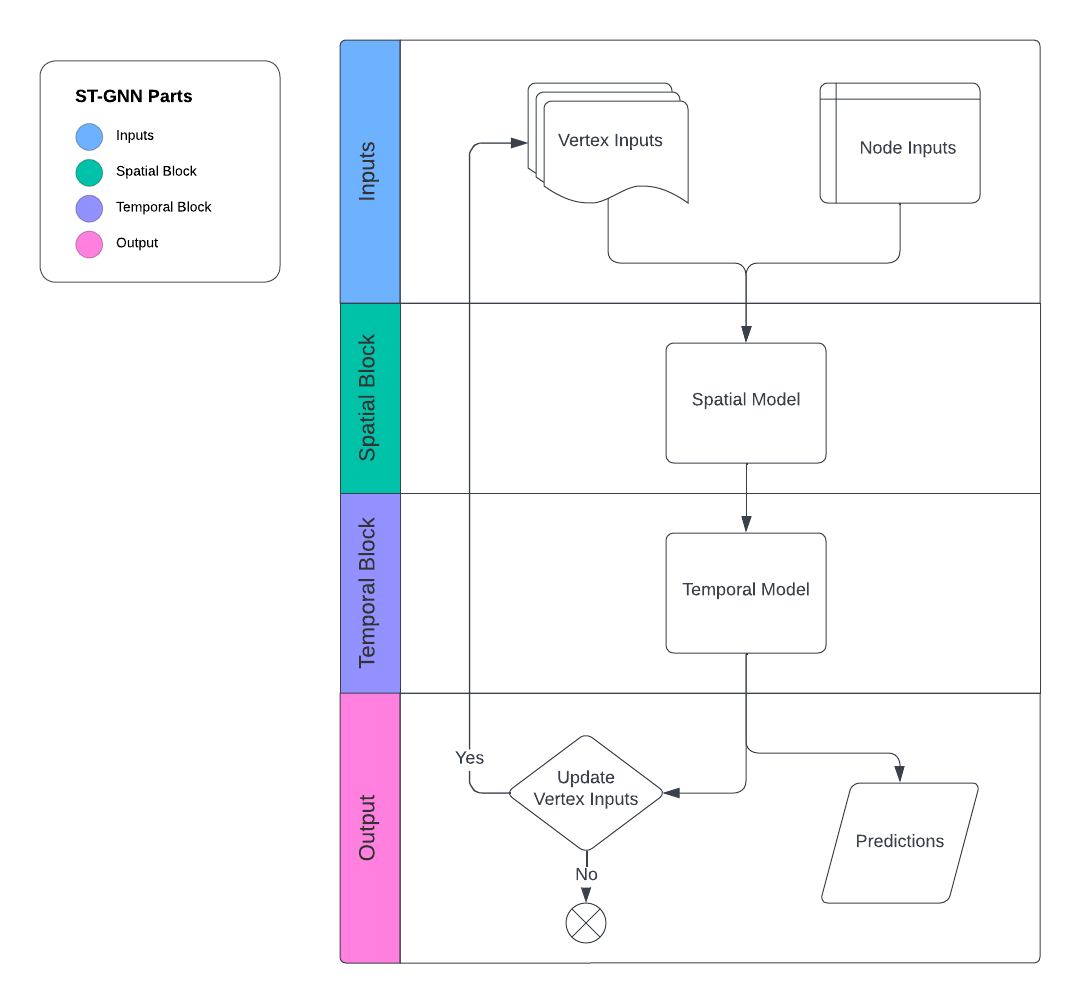
</div>

    Here one adjacency matrix is trained for the whole network. 

Friendly Introduction to Temporal Graph Neural Networks (and some Traffic Forecasting) by DeepFindr- https://www.youtube.com/watch?v=WEWq93tioC4&t=4s&ab_channel=DeepFindr

In [1]:
from auto_hyperparameter_tuner import *
from torch.cuda.amp import GradScaler, autocast

param_space = {
    "wandb_project": "Predicting Visual Stimulus",
    "wandb_api_key": "7c8d251196fd96d2a93bfb6ffd0005ac030ce42b",
    "num_epochs": 50,
    "lr": tune.uniform(.001,.0001),
    "temporal_hidden_dim": tune.randint(250, 850),
    "spatial_hidden_dim": 1,
    "edge_threshold":.25,
    "early_stop_patience": 3,
    "early_stop_delta": 0.01,
    "batch_size": 16,
    "graph_batch_size": 16,
    "temporal_layer_dimension":1,
    "spatial_out_features": 1,
    "mouse_number": 715093703,
    "timesteps": 10,
    "Architecture": 'Static_STGAT',
    "num_samples": 100,
    "accumulation_steps": 4,  # Gradient accumulation
    "graph_lr": .05,  # Adjust the range as needed
    "use_auto_corr_matrix": True,
    "file_path":"/proj/STOR/pipiras/Neuropixel/output/spike_trains_with_stimulus_session_715093703_10.pkl"
    }

trainer = ModelTrainer(param_space)
trainer.execute_tuning()

(_trainable pid=442671) Loaded spike trains dataset: <class 'pandas.core.frame.DataFrame'>
(_trainable pid=442671) X_val shape: torch.Size([476, 10, 2065, 1])
(_trainable pid=442671) y_val shape: torch.Size([476, 1])
(_trainable pid=442671)  
(_trainable pid=442671) X (array): Matrix of number of batch_size, time_steps_per_frame, num_nodes, and number of features per node.
(_trainable pid=442671) X.shape = (B, T, N, F)
(_trainable pid=442671) X_train shape: torch.Size([4284, 10, 2065, 1])
(_trainable pid=442671) X_test shape: torch.Size([1190, 10, 2065, 1])
(_trainable pid=442671) X_train type: <class 'torch.Tensor'>
(_trainable pid=442671)  
(_trainable pid=442671) X_val shape: torch.Size([476, 10, 2065, 1])
(_trainable pid=442671) y_val shape: torch.Size([476, 1])
(_trainable pid=442671)  
(_trainable pid=442671) y_shape = [batch_size, unique_frames_shown_per_10_timesteps]
(_trainable pid=442671) y_train shape: torch.Size([4284, 1])
(_trainable pid=442671) y_test shape: torch.Size([1

(_WandbLoggingActor pid=455041) wandb: Currently logged in as: rayscarpenter (neuropixel-unc). Use `wandb login --relogin` to force relogin
Train Epoch 1/50:   0%|          | 0/268 [00:00<?, ?it/s]
(_WandbLoggingActor pid=455041) wandb: wandb version 0.16.5 is available!  To upgrade, please run:
(_WandbLoggingActor pid=455041) wandb:  $ pip install wandb --upgrade
(_WandbLoggingActor pid=455041) wandb: Tracking run with wandb version 0.16.4
(_WandbLoggingActor pid=455041) wandb: Run data is saved locally in /nas/longleaf/home/rayrayc/ray_results/exp/_trainable_bbee1f84_1_Architecture=Static_STGAT,accumulation_steps=4,batch_size=16,early_stop_delta=0.0100,early_stop_patience=3,e_2024-03-25_16-37-52/wandb/run-20240325_163813-bbee1f84
(_WandbLoggingActor pid=455041) wandb: Run `wandb offline` to turn off syncing.
(_WandbLoggingActor pid=455041) wandb: Syncing run _trainable_bbee1f84
(_WandbLoggingActor pid=455041) wandb: ⭐️ View project at https://wandb.ai/neuropixel-unc/Predicting%20Visu

(_trainable pid=442671) Epoch 1, Duration: 27.87s, Loss: 1.28, Train Acc: 0.79%, Test Acc: 0.92%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5003, 0.5065, 0.5009, 0.5022], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 2/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 2, Duration: 26.77s, Loss: 1.27, Train Acc: 0.65%, Test Acc: 0.92%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5003, 0.5065, 0.5009, 0.5022], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 3/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 3, Duration: 26.79s, Loss: 1.27, Train Acc: 0.7%, Test Acc: 0.92%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5003, 0.5065, 0.5009, 0.5022], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 4/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 4, Duration: 26.77s, Loss: 1.22, Train Acc: 0.63%, Test Acc: 1.01%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5003, 0.5065, 0.5009, 0.5022], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 5/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 5, Duration: 26.78s, Loss: 1.2, Train Acc: 0.44%, Test Acc: 1.01%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5003, 0.5065, 0.5009, 0.5022], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 6/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 6, Duration: 26.78s, Loss: 1.2, Train Acc: 0.47%, Test Acc: 1.01%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5003, 0.5065, 0.5009, 0.5022], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 7/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 7, Duration: 26.78s, Loss: 1.2, Train Acc: 0.86%, Test Acc: 0.34%
(_trainable pid=442671) Early stopping triggered at epoch 7
(_trainable pid=442671) Highest Test Accuracy: 1.0084033613445378%
(_trainable pid=442671) Edge sliver indices: tensor([[0, 0],
(_trainable pid=442671)         [0, 0],
(_trainable pid=442671)         [0, 0],
(_trainable pid=442671)         [0, 0],
(_trainable pid=442671)         [0, 0]], device='cuda:0')
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5003, 0.5065, 0.5009, 0.5022], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)
(_trainable pid=442671) Highest Test Accuracy: 1.0084033613445378%


Test Epoch 7/50:   0%|          | 0/75 [00:01<?, ?it/s]
2024-03-25 16:41:31,619	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 4.303 s, which may be a performance bottleneck.
2024-03-25 16:41:31,620	WARNING util.py:202 -- The `process_trial_result` operation took 4.304 s, which may be a performance bottleneck.
2024-03-25 16:41:31,620	WARNING util.py:202 -- Processing trial results took 4.304 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-03-25 16:41:31,620	WARNING util.py:202 -- The `process_trial_result` operation took 4.306 s, which may be a performance bottleneck.


(_trainable pid=442671) Loaded spike trains dataset: <class 'pandas.core.frame.DataFrame'>
(_trainable pid=442671) X_val shape: torch.Size([476, 10, 2065, 1])
(_trainable pid=442671) y_val shape: torch.Size([476, 1])
(_trainable pid=442671)  
(_trainable pid=442671) X (array): Matrix of number of batch_size, time_steps_per_frame, num_nodes, and number of features per node.
(_trainable pid=442671) X.shape = (B, T, N, F)
(_trainable pid=442671) X_train shape: torch.Size([4284, 10, 2065, 1])
(_trainable pid=442671) X_test shape: torch.Size([1190, 10, 2065, 1])
(_trainable pid=442671) X_train type: <class 'torch.Tensor'>
(_trainable pid=442671)  
(_trainable pid=442671) X_val shape: torch.Size([476, 10, 2065, 1])
(_trainable pid=442671) y_val shape: torch.Size([476, 1])
(_trainable pid=442671)  
(_trainable pid=442671) y_shape = [batch_size, unique_frames_shown_per_10_timesteps]
(_trainable pid=442671) y_train shape: torch.Size([4284, 1])
(_trainable pid=442671) y_test shape: torch.Size([1

(_WandbLoggingActor pid=455041) wandb: - 0.027 MB of 0.027 MB uploaded
wandb:                                                                                
(_WandbLoggingActor pid=455041) wandb: 
(_WandbLoggingActor pid=455041) wandb: Run history:
(_WandbLoggingActor pid=455041) wandb: iterations_since_restore ▁
(_WandbLoggingActor pid=455041) wandb:                 test_acc ▁
(_WandbLoggingActor pid=455041) wandb:       time_since_restore ▁
(_WandbLoggingActor pid=455041) wandb:         time_this_iter_s ▁
(_WandbLoggingActor pid=455041) wandb:             time_total_s ▁
(_WandbLoggingActor pid=455041) wandb:                timestamp ▁
(_WandbLoggingActor pid=455041) wandb:       training_iteration ▁
(_WandbLoggingActor pid=455041) wandb: 
(_WandbLoggingActor pid=455041) wandb: Run summary:
(_WandbLoggingActor pid=455041) wandb: iterations_since_restore 1
(_WandbLoggingActor pid=455041) wandb:                 test_acc 1.0084
(_WandbLoggingActor pid=455041) wandb:       time_since_res

(_trainable pid=442671) Epoch 1, Duration: 27.53s, Loss: 1.21, Train Acc: 0.79%, Test Acc: 1.09%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5027, 0.5038, 0.4957, 0.5015], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 2/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 2, Duration: 27.18s, Loss: 1.18, Train Acc: 2.78%, Test Acc: 4.2%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5517, 0.5055, 0.5112, 0.5347], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 3/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 3, Duration: 27.29s, Loss: 1.03, Train Acc: 18.16%, Test Acc: 14.79%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5774, 0.5150, 0.5254, 0.5488], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 4/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 4, Duration: 27.27s, Loss: 0.8, Train Acc: 52.45%, Test Acc: 38.15%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5885, 0.5081, 0.5255, 0.5557], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 5/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 5, Duration: 27.26s, Loss: 0.71, Train Acc: 63.28%, Test Acc: 45.8%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5965, 0.5089, 0.5248, 0.5566], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 6/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 6, Duration: 27.28s, Loss: 0.64, Train Acc: 68.14%, Test Acc: 51.93%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.6039, 0.5121, 0.5246, 0.5551], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 7/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 7, Duration: 27.26s, Loss: 0.58, Train Acc: 70.99%, Test Acc: 54.87%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.6128, 0.5166, 0.5317, 0.5563], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 8/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 8, Duration: 27.29s, Loss: 0.57, Train Acc: 71.64%, Test Acc: 54.79%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.6214, 0.5196, 0.5379, 0.5569], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 9/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 9, Duration: 27.28s, Loss: 0.57, Train Acc: 71.99%, Test Acc: 55.46%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.6295, 0.5212, 0.5433, 0.5564], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 10/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 10, Duration: 27.31s, Loss: 0.56, Train Acc: 72.29%, Test Acc: 55.46%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.6373, 0.5221, 0.5492, 0.5555], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 11/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 11, Duration: 27.29s, Loss: 0.56, Train Acc: 72.41%, Test Acc: 55.63%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.6449, 0.5228, 0.5551, 0.5545], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 12/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 12, Duration: 27.33s, Loss: 0.56, Train Acc: 72.48%, Test Acc: 55.46%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.6523, 0.5234, 0.5609, 0.5534], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 13/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 13, Duration: 27.29s, Loss: 0.56, Train Acc: 72.48%, Test Acc: 55.46%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.6596, 0.5238, 0.5668, 0.5521], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 14/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 14, Duration: 27.48s, Loss: 0.56, Train Acc: 72.48%, Test Acc: 55.46%
(_trainable pid=442671) Early stopping triggered at epoch 14
(_trainable pid=442671) Highest Test Accuracy: 55.63025210084034%
(_trainable pid=442671) Edge sliver indices: tensor([[0, 0],
(_trainable pid=442671)         [0, 0],
(_trainable pid=442671)         [0, 0],
(_trainable pid=442671)         [0, 0],
(_trainable pid=442671)         [0, 0]], device='cuda:0')
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.6667, 0.5241, 0.5726, 0.5508], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)
(_trainable pid=442671) Highest Test Accuracy: 55.63025210084034%


Test Epoch 14/50:   0%|          | 0/75 [00:01<?, ?it/s]
2024-03-25 16:48:06,190	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 3.439 s, which may be a performance bottleneck.
2024-03-25 16:48:06,191	WARNING util.py:202 -- The `process_trial_result` operation took 3.441 s, which may be a performance bottleneck.
2024-03-25 16:48:06,191	WARNING util.py:202 -- Processing trial results took 3.441 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-03-25 16:48:06,192	WARNING util.py:202 -- The `process_trial_result` operation took 3.443 s, which may be a performance bottleneck.


(_trainable pid=442671) Loaded spike trains dataset: <class 'pandas.core.frame.DataFrame'>
(_trainable pid=442671) X_val shape: torch.Size([476, 10, 2065, 1])
(_trainable pid=442671) y_val shape: torch.Size([476, 1])
(_trainable pid=442671)  
(_trainable pid=442671) X (array): Matrix of number of batch_size, time_steps_per_frame, num_nodes, and number of features per node.
(_trainable pid=442671) X.shape = (B, T, N, F)
(_trainable pid=442671) X_train shape: torch.Size([4284, 10, 2065, 1])
(_trainable pid=442671) X_test shape: torch.Size([1190, 10, 2065, 1])
(_trainable pid=442671) X_train type: <class 'torch.Tensor'>
(_trainable pid=442671)  
(_trainable pid=442671) X_val shape: torch.Size([476, 10, 2065, 1])
(_trainable pid=442671) y_val shape: torch.Size([476, 1])
(_trainable pid=442671)  
(_trainable pid=442671) y_shape = [batch_size, unique_frames_shown_per_10_timesteps]
(_trainable pid=442671) y_train shape: torch.Size([4284, 1])
(_trainable pid=442671) y_test shape: torch.Size([1

wandb:                                                                                
(_WandbLoggingActor pid=685017) wandb: 
(_WandbLoggingActor pid=685017) wandb: Run history:
(_WandbLoggingActor pid=685017) wandb: iterations_since_restore ▁
(_WandbLoggingActor pid=685017) wandb:                 test_acc ▁
(_WandbLoggingActor pid=685017) wandb:       time_since_restore ▁
(_WandbLoggingActor pid=685017) wandb:         time_this_iter_s ▁
(_WandbLoggingActor pid=685017) wandb:             time_total_s ▁
(_WandbLoggingActor pid=685017) wandb:                timestamp ▁
(_WandbLoggingActor pid=685017) wandb:       training_iteration ▁
(_WandbLoggingActor pid=685017) wandb: 
(_WandbLoggingActor pid=685017) wandb: Run summary:
(_WandbLoggingActor pid=685017) wandb: iterations_since_restore 1
(_WandbLoggingActor pid=685017) wandb:                 test_acc 55.63025
(_WandbLoggingActor pid=685017) wandb:       time_since_restore 390.91239
(_WandbLoggingActor pid=685017) wandb:         time_th

(_trainable pid=442671) Epoch 1, Duration: 27.36s, Loss: 1.23, Train Acc: 0.58%, Test Acc: 0.92%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5008, 0.5061, 0.5010, 0.5025], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 2/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 2, Duration: 27.61s, Loss: 1.22, Train Acc: 0.65%, Test Acc: 0.92%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5008, 0.5061, 0.5010, 0.5025], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 3/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 3, Duration: 27.72s, Loss: 1.22, Train Acc: 0.65%, Test Acc: 0.92%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5008, 0.5061, 0.5010, 0.5025], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 4/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 4, Duration: 27.66s, Loss: 1.21, Train Acc: 0.77%, Test Acc: 0.34%
(_trainable pid=442671) Early stopping triggered at epoch 4
(_trainable pid=442671) Highest Test Accuracy: 0.9243697478991597%
(_trainable pid=442671) Edge sliver indices: tensor([[0, 0],
(_trainable pid=442671)         [0, 0],
(_trainable pid=442671)         [0, 0],
(_trainable pid=442671)         [0, 0],
(_trainable pid=442671)         [0, 0]], device='cuda:0')
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5008, 0.5061, 0.5010, 0.5025], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)
(_trainable pid=442671) Highest Test Accuracy: 0.9243697478991597%


Test Epoch 4/50:   0%|          | 0/75 [00:01<?, ?it/s]
2024-03-25 16:50:08,836	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.882 s, which may be a performance bottleneck.
2024-03-25 16:50:08,837	WARNING util.py:202 -- The `process_trial_result` operation took 2.883 s, which may be a performance bottleneck.
2024-03-25 16:50:08,837	WARNING util.py:202 -- Processing trial results took 2.883 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-03-25 16:50:08,838	WARNING util.py:202 -- The `process_trial_result` operation took 2.885 s, which may be a performance bottleneck.


(_trainable pid=442671) Loaded spike trains dataset: <class 'pandas.core.frame.DataFrame'>
(_trainable pid=442671) X_val shape: torch.Size([476, 10, 2065, 1])
(_trainable pid=442671) y_val shape: torch.Size([476, 1])
(_trainable pid=442671)  
(_trainable pid=442671) X (array): Matrix of number of batch_size, time_steps_per_frame, num_nodes, and number of features per node.
(_trainable pid=442671) X.shape = (B, T, N, F)
(_trainable pid=442671) X_train shape: torch.Size([4284, 10, 2065, 1])
(_trainable pid=442671) X_test shape: torch.Size([1190, 10, 2065, 1])
(_trainable pid=442671) X_train type: <class 'torch.Tensor'>
(_trainable pid=442671)  
(_trainable pid=442671) X_val shape: torch.Size([476, 10, 2065, 1])
(_trainable pid=442671) y_val shape: torch.Size([476, 1])
(_trainable pid=442671)  
(_trainable pid=442671) y_shape = [batch_size, unique_frames_shown_per_10_timesteps]
(_trainable pid=442671) y_train shape: torch.Size([4284, 1])
(_trainable pid=442671) y_test shape: torch.Size([1

wandb:                                                                                
(_WandbLoggingActor pid=1125944) wandb: 
(_WandbLoggingActor pid=1125944) wandb: Run history:
(_WandbLoggingActor pid=1125944) wandb: iterations_since_restore ▁
(_WandbLoggingActor pid=1125944) wandb:                 test_acc ▁
(_WandbLoggingActor pid=1125944) wandb:       time_since_restore ▁
(_WandbLoggingActor pid=1125944) wandb:         time_this_iter_s ▁
(_WandbLoggingActor pid=1125944) wandb:             time_total_s ▁
(_WandbLoggingActor pid=1125944) wandb:                timestamp ▁
(_WandbLoggingActor pid=1125944) wandb:       training_iteration ▁
(_WandbLoggingActor pid=1125944) wandb: 
(_WandbLoggingActor pid=1125944) wandb: Run summary:
(_WandbLoggingActor pid=1125944) wandb: iterations_since_restore 1
(_WandbLoggingActor pid=1125944) wandb:                 test_acc 0.92437
(_WandbLoggingActor pid=1125944) wandb:       time_since_restore 119.58307
(_WandbLoggingActor pid=1125944) wandb:  

(_trainable pid=442671) Epoch 1, Duration: 27.44s, Loss: 1.26, Train Acc: 0.77%, Test Acc: 0.92%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5006, 0.5109, 0.4994, 0.5031], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 2/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 2, Duration: 27.17s, Loss: 1.26, Train Acc: 0.72%, Test Acc: 0.92%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5006, 0.5109, 0.4995, 0.5031], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 3/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 3, Duration: 27.16s, Loss: 1.26, Train Acc: 0.75%, Test Acc: 0.92%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5006, 0.5109, 0.4995, 0.5031], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 4/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 4, Duration: 27.16s, Loss: 1.21, Train Acc: 0.51%, Test Acc: 1.01%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5006, 0.5109, 0.4995, 0.5031], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 5/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 5, Duration: 27.17s, Loss: 1.2, Train Acc: 0.42%, Test Acc: 1.01%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5006, 0.5109, 0.4995, 0.5031], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 6/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 6, Duration: 27.19s, Loss: 1.2, Train Acc: 0.4%, Test Acc: 1.01%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5006, 0.5109, 0.4995, 0.5031], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 7/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 7, Duration: 27.19s, Loss: 1.2, Train Acc: 0.89%, Test Acc: 0.34%
(_trainable pid=442671) Early stopping triggered at epoch 7
(_trainable pid=442671) Highest Test Accuracy: 1.0084033613445378%
(_trainable pid=442671) Edge sliver indices: tensor([[0, 0],
(_trainable pid=442671)         [0, 0],
(_trainable pid=442671)         [0, 0],
(_trainable pid=442671)         [0, 0],
(_trainable pid=442671)         [0, 0]], device='cuda:0')
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5006, 0.5109, 0.4995, 0.5031], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)
(_trainable pid=442671) Highest Test Accuracy: 1.0084033613445378%


Test Epoch 7/50:   0%|          | 0/75 [00:01<?, ?it/s]
2024-03-25 16:53:31,323	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.923 s, which may be a performance bottleneck.
2024-03-25 16:53:31,325	WARNING util.py:202 -- The `process_trial_result` operation took 2.924 s, which may be a performance bottleneck.
2024-03-25 16:53:31,325	WARNING util.py:202 -- Processing trial results took 2.925 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-03-25 16:53:31,325	WARNING util.py:202 -- The `process_trial_result` operation took 2.926 s, which may be a performance bottleneck.


(_trainable pid=442671) Loaded spike trains dataset: <class 'pandas.core.frame.DataFrame'>
(_trainable pid=442671) X_val shape: torch.Size([476, 10, 2065, 1])
(_trainable pid=442671) y_val shape: torch.Size([476, 1])
(_trainable pid=442671)  
(_trainable pid=442671) X (array): Matrix of number of batch_size, time_steps_per_frame, num_nodes, and number of features per node.
(_trainable pid=442671) X.shape = (B, T, N, F)
(_trainable pid=442671) X_train shape: torch.Size([4284, 10, 2065, 1])
(_trainable pid=442671) X_test shape: torch.Size([1190, 10, 2065, 1])
(_trainable pid=442671) X_train type: <class 'torch.Tensor'>
(_trainable pid=442671)  
(_trainable pid=442671) X_val shape: torch.Size([476, 10, 2065, 1])
(_trainable pid=442671) y_val shape: torch.Size([476, 1])
(_trainable pid=442671)  
(_trainable pid=442671) y_shape = [batch_size, unique_frames_shown_per_10_timesteps]
(_trainable pid=442671) y_train shape: torch.Size([4284, 1])
(_trainable pid=442671) y_test shape: torch.Size([1

(_WandbLoggingActor pid=1262578) wandb: - 0.027 MB of 0.038 MB uploaded
wandb:                                                                                
(_WandbLoggingActor pid=1262578) wandb: 
(_WandbLoggingActor pid=1262578) wandb: Run history:
(_WandbLoggingActor pid=1262578) wandb: iterations_since_restore ▁
(_WandbLoggingActor pid=1262578) wandb:                 test_acc ▁
(_WandbLoggingActor pid=1262578) wandb:       time_since_restore ▁
(_WandbLoggingActor pid=1262578) wandb:         time_this_iter_s ▁
(_WandbLoggingActor pid=1262578) wandb:             time_total_s ▁
(_WandbLoggingActor pid=1262578) wandb:                timestamp ▁
(_WandbLoggingActor pid=1262578) wandb:       training_iteration ▁
(_WandbLoggingActor pid=1262578) wandb: 
(_WandbLoggingActor pid=1262578) wandb: Run summary:
(_WandbLoggingActor pid=1262578) wandb: iterations_since_restore 1
(_WandbLoggingActor pid=1262578) wandb:                 test_acc 1.0084
(_WandbLoggingActor pid=1262578) wandb:      

(_trainable pid=442671) Epoch 1, Duration: 27.56s, Loss: 1.21, Train Acc: 0.7%, Test Acc: 0.84%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5004, 0.5065, 0.5011, 0.5020], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 2/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 2, Duration: 27.41s, Loss: 1.2, Train Acc: 0.7%, Test Acc: 0.25%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5004, 0.5065, 0.5011, 0.5020], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 3/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 3, Duration: 26.97s, Loss: 1.2, Train Acc: 0.75%, Test Acc: 0.76%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5004, 0.5065, 0.5011, 0.5020], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 4/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 4, Duration: 27.27s, Loss: 1.2, Train Acc: 0.86%, Test Acc: 0.5%
(_trainable pid=442671) Early stopping triggered at epoch 4
(_trainable pid=442671) Highest Test Accuracy: 0.8403361344537815%
(_trainable pid=442671) Edge sliver indices: tensor([[0, 0],
(_trainable pid=442671)         [0, 0],
(_trainable pid=442671)         [0, 0],
(_trainable pid=442671)         [0, 0],
(_trainable pid=442671)         [0, 0]], device='cuda:0')
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5004, 0.5065, 0.5011, 0.5020], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)
(_trainable pid=442671) Highest Test Accuracy: 0.8403361344537815%


Test Epoch 4/50:   0%|          | 0/75 [00:01<?, ?it/s]
2024-03-25 16:55:34,421	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 5.055 s, which may be a performance bottleneck.
2024-03-25 16:55:34,423	WARNING util.py:202 -- The `process_trial_result` operation took 5.057 s, which may be a performance bottleneck.
2024-03-25 16:55:34,423	WARNING util.py:202 -- Processing trial results took 5.057 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-03-25 16:55:34,423	WARNING util.py:202 -- The `process_trial_result` operation took 5.058 s, which may be a performance bottleneck.


(_trainable pid=442671) Loaded spike trains dataset: <class 'pandas.core.frame.DataFrame'>
(_trainable pid=442671) X_val shape: torch.Size([476, 10, 2065, 1])
(_trainable pid=442671) y_val shape: torch.Size([476, 1])
(_trainable pid=442671)  
(_trainable pid=442671) X (array): Matrix of number of batch_size, time_steps_per_frame, num_nodes, and number of features per node.
(_trainable pid=442671) X.shape = (B, T, N, F)
(_trainable pid=442671) X_train shape: torch.Size([4284, 10, 2065, 1])
(_trainable pid=442671) X_test shape: torch.Size([1190, 10, 2065, 1])
(_trainable pid=442671) X_train type: <class 'torch.Tensor'>
(_trainable pid=442671)  
(_trainable pid=442671) X_val shape: torch.Size([476, 10, 2065, 1])
(_trainable pid=442671) y_val shape: torch.Size([476, 1])
(_trainable pid=442671)  
(_trainable pid=442671) y_shape = [batch_size, unique_frames_shown_per_10_timesteps]
(_trainable pid=442671) y_train shape: torch.Size([4284, 1])
(_trainable pid=442671) y_test shape: torch.Size([1

(_WandbLoggingActor pid=1496809) wandb: - 0.027 MB of 0.038 MB uploaded
wandb:                                                                                
(_WandbLoggingActor pid=1496809) wandb: 
(_WandbLoggingActor pid=1496809) wandb: Run history:
(_WandbLoggingActor pid=1496809) wandb: iterations_since_restore ▁
(_WandbLoggingActor pid=1496809) wandb:                 test_acc ▁
(_WandbLoggingActor pid=1496809) wandb:       time_since_restore ▁
(_WandbLoggingActor pid=1496809) wandb:         time_this_iter_s ▁
(_WandbLoggingActor pid=1496809) wandb:             time_total_s ▁
(_WandbLoggingActor pid=1496809) wandb:                timestamp ▁
(_WandbLoggingActor pid=1496809) wandb:       training_iteration ▁
(_WandbLoggingActor pid=1496809) wandb: 
(_WandbLoggingActor pid=1496809) wandb: Run summary:
(_WandbLoggingActor pid=1496809) wandb: iterations_since_restore 1
(_WandbLoggingActor pid=1496809) wandb:                 test_acc 0.84034
(_WandbLoggingActor pid=1496809) wandb:     

(_trainable pid=442671) Epoch 1, Duration: 27.00s, Loss: 1.22, Train Acc: 0.68%, Test Acc: 0.92%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5003, 0.5064, 0.5009, 0.5022], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 2/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 2, Duration: 27.15s, Loss: 1.22, Train Acc: 0.77%, Test Acc: 0.92%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5003, 0.5064, 0.5009, 0.5022], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 3/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 3, Duration: 27.15s, Loss: 1.21, Train Acc: 0.68%, Test Acc: 1.01%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5003, 0.5064, 0.5009, 0.5022], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 4/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 4, Duration: 27.13s, Loss: 1.2, Train Acc: 0.86%, Test Acc: 1.01%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5003, 0.5064, 0.5009, 0.5022], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 5/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 5, Duration: 27.38s, Loss: 1.2, Train Acc: 0.86%, Test Acc: 1.01%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5003, 0.5064, 0.5009, 0.5022], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 6/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 6, Duration: 27.21s, Loss: 1.2, Train Acc: 0.86%, Test Acc: 1.01%
(_trainable pid=442671) Early stopping triggered at epoch 6
(_trainable pid=442671) Highest Test Accuracy: 1.0084033613445378%
(_trainable pid=442671) Edge sliver indices: tensor([[0, 0],
(_trainable pid=442671)         [0, 0],
(_trainable pid=442671)         [0, 0],
(_trainable pid=442671)         [0, 0],
(_trainable pid=442671)         [0, 0]], device='cuda:0')
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5003, 0.5064, 0.5009, 0.5022], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)
(_trainable pid=442671) Highest Test Accuracy: 1.0084033613445378%


Test Epoch 6/50:   0%|          | 0/75 [00:01<?, ?it/s]
2024-03-25 16:58:29,771	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.981 s, which may be a performance bottleneck.
2024-03-25 16:58:29,772	WARNING util.py:202 -- The `process_trial_result` operation took 2.982 s, which may be a performance bottleneck.
2024-03-25 16:58:29,773	WARNING util.py:202 -- Processing trial results took 2.983 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-03-25 16:58:29,773	WARNING util.py:202 -- The `process_trial_result` operation took 2.984 s, which may be a performance bottleneck.


(_trainable pid=442671) Loaded spike trains dataset: <class 'pandas.core.frame.DataFrame'>
(_trainable pid=442671) X_val shape: torch.Size([476, 10, 2065, 1])
(_trainable pid=442671) y_val shape: torch.Size([476, 1])
(_trainable pid=442671)  
(_trainable pid=442671) X (array): Matrix of number of batch_size, time_steps_per_frame, num_nodes, and number of features per node.
(_trainable pid=442671) X.shape = (B, T, N, F)
(_trainable pid=442671) X_train shape: torch.Size([4284, 10, 2065, 1])
(_trainable pid=442671) X_test shape: torch.Size([1190, 10, 2065, 1])
(_trainable pid=442671) X_train type: <class 'torch.Tensor'>
(_trainable pid=442671)  
(_trainable pid=442671) X_val shape: torch.Size([476, 10, 2065, 1])
(_trainable pid=442671) y_val shape: torch.Size([476, 1])
(_trainable pid=442671)  
(_trainable pid=442671) y_shape = [batch_size, unique_frames_shown_per_10_timesteps]
(_trainable pid=442671) y_train shape: torch.Size([4284, 1])
(_trainable pid=442671) y_test shape: torch.Size([1

(_WandbLoggingActor pid=1641630) wandb: - 0.027 MB of 0.038 MB uploaded
wandb:                                                                                
(_WandbLoggingActor pid=1641630) wandb: 
(_WandbLoggingActor pid=1641630) wandb: Run history:
(_WandbLoggingActor pid=1641630) wandb: iterations_since_restore ▁
(_WandbLoggingActor pid=1641630) wandb:                 test_acc ▁
(_WandbLoggingActor pid=1641630) wandb:       time_since_restore ▁
(_WandbLoggingActor pid=1641630) wandb:         time_this_iter_s ▁
(_WandbLoggingActor pid=1641630) wandb:             time_total_s ▁
(_WandbLoggingActor pid=1641630) wandb:                timestamp ▁
(_WandbLoggingActor pid=1641630) wandb:       training_iteration ▁
(_WandbLoggingActor pid=1641630) wandb: 
(_WandbLoggingActor pid=1641630) wandb: Run summary:
(_WandbLoggingActor pid=1641630) wandb: iterations_since_restore 1
(_WandbLoggingActor pid=1641630) wandb:                 test_acc 1.0084
(_WandbLoggingActor pid=1641630) wandb:      

(_trainable pid=442671) Epoch 1, Duration: 27.70s, Loss: 1.2, Train Acc: 0.89%, Test Acc: 0.92%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.4986, 0.5081, 0.4955, 0.5053], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 2/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 2, Duration: 27.55s, Loss: 1.2, Train Acc: 0.75%, Test Acc: 0.76%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.4987, 0.5080, 0.4954, 0.5053], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 3/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 3, Duration: 27.12s, Loss: 1.19, Train Acc: 1.0%, Test Acc: 0.59%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.4987, 0.5079, 0.4953, 0.5052], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 4/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 4, Duration: 27.50s, Loss: 1.19, Train Acc: 0.96%, Test Acc: 0.42%
(_trainable pid=442671) Early stopping triggered at epoch 4
(_trainable pid=442671) Highest Test Accuracy: 0.9243697478991597%
(_trainable pid=442671) Edge sliver indices: tensor([[0, 0],
(_trainable pid=442671)         [0, 0],
(_trainable pid=442671)         [0, 0],
(_trainable pid=442671)         [0, 0],
(_trainable pid=442671)         [0, 0]], device='cuda:0')
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.4986, 0.5080, 0.4951, 0.5051], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)
(_trainable pid=442671) Highest Test Accuracy: 0.9243697478991597%


Test Epoch 4/50:   0%|          | 0/75 [00:01<?, ?it/s]
2024-03-25 17:00:35,642	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 6.366 s, which may be a performance bottleneck.
2024-03-25 17:00:35,644	WARNING util.py:202 -- The `process_trial_result` operation took 6.367 s, which may be a performance bottleneck.
2024-03-25 17:00:35,644	WARNING util.py:202 -- Processing trial results took 6.368 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-03-25 17:00:35,644	WARNING util.py:202 -- The `process_trial_result` operation took 6.369 s, which may be a performance bottleneck.


(_trainable pid=442671) Loaded spike trains dataset: <class 'pandas.core.frame.DataFrame'>
(_trainable pid=442671) X_val shape: torch.Size([476, 10, 2065, 1])
(_trainable pid=442671) y_val shape: torch.Size([476, 1])
(_trainable pid=442671)  
(_trainable pid=442671) X (array): Matrix of number of batch_size, time_steps_per_frame, num_nodes, and number of features per node.
(_trainable pid=442671) X.shape = (B, T, N, F)
(_trainable pid=442671) X_train shape: torch.Size([4284, 10, 2065, 1])
(_trainable pid=442671) X_test shape: torch.Size([1190, 10, 2065, 1])
(_trainable pid=442671) X_train type: <class 'torch.Tensor'>
(_trainable pid=442671)  
(_trainable pid=442671) X_val shape: torch.Size([476, 10, 2065, 1])
(_trainable pid=442671) y_val shape: torch.Size([476, 1])
(_trainable pid=442671)  
(_trainable pid=442671) y_shape = [batch_size, unique_frames_shown_per_10_timesteps]
(_trainable pid=442671) y_train shape: torch.Size([4284, 1])
(_trainable pid=442671) y_test shape: torch.Size([1

wandb:                                                                                
(_WandbLoggingActor pid=1847917) wandb: 
(_WandbLoggingActor pid=1847917) wandb: Run history:
(_WandbLoggingActor pid=1847917) wandb: iterations_since_restore ▁
(_WandbLoggingActor pid=1847917) wandb:                 test_acc ▁
(_WandbLoggingActor pid=1847917) wandb:       time_since_restore ▁
(_WandbLoggingActor pid=1847917) wandb:         time_this_iter_s ▁
(_WandbLoggingActor pid=1847917) wandb:             time_total_s ▁
(_WandbLoggingActor pid=1847917) wandb:                timestamp ▁
(_WandbLoggingActor pid=1847917) wandb:       training_iteration ▁
(_WandbLoggingActor pid=1847917) wandb: 
(_WandbLoggingActor pid=1847917) wandb: Run summary:
(_WandbLoggingActor pid=1847917) wandb: iterations_since_restore 1
(_WandbLoggingActor pid=1847917) wandb:                 test_acc 0.92437
(_WandbLoggingActor pid=1847917) wandb:       time_since_restore 119.32863
(_WandbLoggingActor pid=1847917) wandb:  

(_trainable pid=442671) Epoch 1, Duration: 26.93s, Loss: 1.15, Train Acc: 3.5%, Test Acc: 9.83%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.4885, 0.5139, 0.5012, 0.4983], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 2/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 2, Duration: 26.89s, Loss: 0.78, Train Acc: 29.58%, Test Acc: 44.87%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.4869, 0.5145, 0.4955, 0.4943], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 3/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 3, Duration: 26.86s, Loss: 0.51, Train Acc: 54.95%, Test Acc: 54.96%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.4810, 0.5140, 0.4886, 0.4841], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 4/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 4, Duration: 26.92s, Loss: 0.33, Train Acc: 72.57%, Test Acc: 81.26%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.4813, 0.5148, 0.4915, 0.4761], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 5/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 5, Duration: 26.95s, Loss: 0.28, Train Acc: 76.82%, Test Acc: 82.18%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.4708, 0.5128, 0.4909, 0.4596], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 6/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 6, Duration: 26.87s, Loss: 0.27, Train Acc: 77.89%, Test Acc: 82.35%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.4605, 0.5120, 0.4907, 0.4467], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 7/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 7, Duration: 26.91s, Loss: 0.26, Train Acc: 78.36%, Test Acc: 83.95%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.4345, 0.5208, 0.4834, 0.4301], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 8/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 8, Duration: 27.00s, Loss: 0.26, Train Acc: 78.41%, Test Acc: 84.03%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.4165, 0.5262, 0.4696, 0.4116], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 9/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 9, Duration: 26.94s, Loss: 0.26, Train Acc: 78.38%, Test Acc: 84.12%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.4009, 0.5305, 0.4515, 0.3914], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 10/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 10, Duration: 26.91s, Loss: 0.26, Train Acc: 78.48%, Test Acc: 84.29%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.3814, 0.5333, 0.4260, 0.3835], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 11/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 11, Duration: 27.02s, Loss: 0.25, Train Acc: 78.45%, Test Acc: 84.29%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.3624, 0.5372, 0.4037, 0.3739], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 12/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 12, Duration: 27.04s, Loss: 0.25, Train Acc: 78.41%, Test Acc: 84.37%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.3439, 0.5423, 0.3834, 0.3629], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 13/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 13, Duration: 26.94s, Loss: 0.25, Train Acc: 78.45%, Test Acc: 84.37%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.3259, 0.5480, 0.3648, 0.3522], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 14/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 14, Duration: 27.05s, Loss: 0.25, Train Acc: 78.48%, Test Acc: 84.37%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.3088, 0.5541, 0.3474, 0.3414], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 15/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 15, Duration: 27.01s, Loss: 0.25, Train Acc: 78.45%, Test Acc: 84.37%
(_trainable pid=442671) Early stopping triggered at epoch 15
(_trainable pid=442671) Highest Test Accuracy: 84.36974789915966%
(_trainable pid=442671) Edge sliver indices: tensor([[0, 0],
(_trainable pid=442671)         [0, 0],
(_trainable pid=442671)         [0, 0],
(_trainable pid=442671)         [0, 0],
(_trainable pid=442671)         [0, 0]], device='cuda:0')
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.2925, 0.5605, 0.3312, 0.3306], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)
(_trainable pid=442671) Highest Test Accuracy: 84.36974789915966%
(_trainable pid=442671) Model weights saved to checkpoints/Static_STGAT/Static_STGAT_checkpoint_84.37.pth


Test Epoch 15/50:   0%|          | 0/75 [00:01<?, ?it/s]
2024-03-25 17:07:35,110	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 5.993 s, which may be a performance bottleneck.
2024-03-25 17:07:35,111	WARNING util.py:202 -- The `process_trial_result` operation took 5.995 s, which may be a performance bottleneck.
2024-03-25 17:07:35,112	WARNING util.py:202 -- Processing trial results took 5.995 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-03-25 17:07:35,112	WARNING util.py:202 -- The `process_trial_result` operation took 5.996 s, which may be a performance bottleneck.


(_trainable pid=442671) Loaded spike trains dataset: <class 'pandas.core.frame.DataFrame'>
(_trainable pid=442671) X_val shape: torch.Size([476, 10, 2065, 1])
(_trainable pid=442671) y_val shape: torch.Size([476, 1])
(_trainable pid=442671)  
(_trainable pid=442671) X (array): Matrix of number of batch_size, time_steps_per_frame, num_nodes, and number of features per node.
(_trainable pid=442671) X.shape = (B, T, N, F)
(_trainable pid=442671) X_train shape: torch.Size([4284, 10, 2065, 1])
(_trainable pid=442671) X_test shape: torch.Size([1190, 10, 2065, 1])
(_trainable pid=442671) X_train type: <class 'torch.Tensor'>
(_trainable pid=442671)  
(_trainable pid=442671) X_val shape: torch.Size([476, 10, 2065, 1])
(_trainable pid=442671) y_val shape: torch.Size([476, 1])
(_trainable pid=442671)  
(_trainable pid=442671) y_shape = [batch_size, unique_frames_shown_per_10_timesteps]
(_trainable pid=442671) y_train shape: torch.Size([4284, 1])
(_trainable pid=442671) y_test shape: torch.Size([1

wandb:                                                                                
(_WandbLoggingActor pid=1994030) wandb: 
(_WandbLoggingActor pid=1994030) wandb: Run history:
(_WandbLoggingActor pid=1994030) wandb: iterations_since_restore ▁
(_WandbLoggingActor pid=1994030) wandb:                 test_acc ▁
(_WandbLoggingActor pid=1994030) wandb:       time_since_restore ▁
(_WandbLoggingActor pid=1994030) wandb:         time_this_iter_s ▁
(_WandbLoggingActor pid=1994030) wandb:             time_total_s ▁
(_WandbLoggingActor pid=1994030) wandb:                timestamp ▁
(_WandbLoggingActor pid=1994030) wandb:       training_iteration ▁
(_WandbLoggingActor pid=1994030) wandb: 
(_WandbLoggingActor pid=1994030) wandb: Run summary:
(_WandbLoggingActor pid=1994030) wandb: iterations_since_restore 1
(_WandbLoggingActor pid=1994030) wandb:                 test_acc 84.36975
(_WandbLoggingActor pid=1994030) wandb:       time_since_restore 413.26481
(_WandbLoggingActor pid=1994030) wandb: 

(_trainable pid=442671) Epoch 1, Duration: 27.34s, Loss: 1.2, Train Acc: 0.75%, Test Acc: 0.67%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5004, 0.5065, 0.5010, 0.5023], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 2/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 2, Duration: 27.41s, Loss: 1.2, Train Acc: 0.58%, Test Acc: 0.76%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5004, 0.5065, 0.5010, 0.5023], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 3/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 3, Duration: 27.42s, Loss: 1.19, Train Acc: 0.79%, Test Acc: 0.67%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5004, 0.5065, 0.5010, 0.5023], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 4/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 4, Duration: 27.43s, Loss: 1.19, Train Acc: 0.93%, Test Acc: 0.67%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5004, 0.5065, 0.5010, 0.5023], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 5/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 5, Duration: 27.39s, Loss: 1.19, Train Acc: 0.91%, Test Acc: 0.76%
(_trainable pid=442671) Early stopping triggered at epoch 5
(_trainable pid=442671) Highest Test Accuracy: 0.7563025210084033%
(_trainable pid=442671) Edge sliver indices: tensor([[0, 0],
(_trainable pid=442671)         [0, 0],
(_trainable pid=442671)         [0, 0],
(_trainable pid=442671)         [0, 0],
(_trainable pid=442671)         [0, 0]], device='cuda:0')
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5004, 0.5065, 0.5010, 0.5023], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)
(_trainable pid=442671) Highest Test Accuracy: 0.7563025210084033%


Test Epoch 5/50:   0%|          | 0/75 [00:01<?, ?it/s]
2024-03-25 17:10:04,413	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 3.377 s, which may be a performance bottleneck.
2024-03-25 17:10:04,414	WARNING util.py:202 -- The `process_trial_result` operation took 3.378 s, which may be a performance bottleneck.
2024-03-25 17:10:04,414	WARNING util.py:202 -- Processing trial results took 3.378 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-03-25 17:10:04,415	WARNING util.py:202 -- The `process_trial_result` operation took 3.380 s, which may be a performance bottleneck.


(_trainable pid=442671) Loaded spike trains dataset: <class 'pandas.core.frame.DataFrame'>
(_trainable pid=442671) X_val shape: torch.Size([476, 10, 2065, 1])
(_trainable pid=442671) y_val shape: torch.Size([476, 1])
(_trainable pid=442671)  
(_trainable pid=442671) X (array): Matrix of number of batch_size, time_steps_per_frame, num_nodes, and number of features per node.
(_trainable pid=442671) X.shape = (B, T, N, F)
(_trainable pid=442671) X_train shape: torch.Size([4284, 10, 2065, 1])
(_trainable pid=442671) X_test shape: torch.Size([1190, 10, 2065, 1])
(_trainable pid=442671) X_train type: <class 'torch.Tensor'>
(_trainable pid=442671)  
(_trainable pid=442671) X_val shape: torch.Size([476, 10, 2065, 1])
(_trainable pid=442671) y_val shape: torch.Size([476, 1])
(_trainable pid=442671)  
(_trainable pid=442671) y_shape = [batch_size, unique_frames_shown_per_10_timesteps]
(_trainable pid=442671) y_train shape: torch.Size([4284, 1])
(_trainable pid=442671) y_test shape: torch.Size([1

wandb:                                                                                
(_WandbLoggingActor pid=2464559) wandb: 
(_WandbLoggingActor pid=2464559) wandb: Run history:
(_WandbLoggingActor pid=2464559) wandb: iterations_since_restore ▁
(_WandbLoggingActor pid=2464559) wandb:                 test_acc ▁
(_WandbLoggingActor pid=2464559) wandb:       time_since_restore ▁
(_WandbLoggingActor pid=2464559) wandb:         time_this_iter_s ▁
(_WandbLoggingActor pid=2464559) wandb:             time_total_s ▁
(_WandbLoggingActor pid=2464559) wandb:                timestamp ▁
(_WandbLoggingActor pid=2464559) wandb:       training_iteration ▁
(_WandbLoggingActor pid=2464559) wandb: 
(_WandbLoggingActor pid=2464559) wandb: Run summary:
(_WandbLoggingActor pid=2464559) wandb: iterations_since_restore 1
(_WandbLoggingActor pid=2464559) wandb:                 test_acc 0.7563
(_WandbLoggingActor pid=2464559) wandb:       time_since_restore 145.70784
(_WandbLoggingActor pid=2464559) wandb:   

(_trainable pid=442671) Epoch 1, Duration: 27.61s, Loss: 1.21, Train Acc: 0.89%, Test Acc: 0.84%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.4993, 0.5028, 0.4998, 0.4969], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 2/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 2, Duration: 27.28s, Loss: 1.2, Train Acc: 0.61%, Test Acc: 0.34%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.4995, 0.5016, 0.4999, 0.4963], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 3/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 3, Duration: 27.50s, Loss: 1.2, Train Acc: 0.75%, Test Acc: 0.84%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.4996, 0.5013, 0.5001, 0.4966], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 4/50:   0%|          | 0/75 [00:00<?, ?it/s]


(_trainable pid=442671) Epoch 4, Duration: 27.52s, Loss: 1.2, Train Acc: 0.84%, Test Acc: 0.84%
(_trainable pid=442671) Early stopping triggered at epoch 4
(_trainable pid=442671) Highest Test Accuracy: 0.8403361344537815%
(_trainable pid=442671) Edge sliver indices: tensor([[0, 0],
(_trainable pid=442671)         [0, 0],
(_trainable pid=442671)         [0, 0],
(_trainable pid=442671)         [0, 0],
(_trainable pid=442671)         [0, 0]], device='cuda:0')
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5001, 0.5011, 0.5006, 0.4964], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)
(_trainable pid=442671) Highest Test Accuracy: 0.8403361344537815%


Test Epoch 4/50:   0%|          | 0/75 [00:01<?, ?it/s]
2024-03-25 17:12:09,077	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 5.233 s, which may be a performance bottleneck.
2024-03-25 17:12:09,078	WARNING util.py:202 -- The `process_trial_result` operation took 5.234 s, which may be a performance bottleneck.
2024-03-25 17:12:09,078	WARNING util.py:202 -- Processing trial results took 5.234 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-03-25 17:12:09,078	WARNING util.py:202 -- The `process_trial_result` operation took 5.236 s, which may be a performance bottleneck.


(_trainable pid=442671) Loaded spike trains dataset: <class 'pandas.core.frame.DataFrame'>
(_trainable pid=442671) X_val shape: torch.Size([476, 10, 2065, 1])
(_trainable pid=442671) y_val shape: torch.Size([476, 1])
(_trainable pid=442671)  
(_trainable pid=442671) X (array): Matrix of number of batch_size, time_steps_per_frame, num_nodes, and number of features per node.
(_trainable pid=442671) X.shape = (B, T, N, F)
(_trainable pid=442671) X_train shape: torch.Size([4284, 10, 2065, 1])
(_trainable pid=442671) X_test shape: torch.Size([1190, 10, 2065, 1])
(_trainable pid=442671) X_train type: <class 'torch.Tensor'>
(_trainable pid=442671)  
(_trainable pid=442671) X_val shape: torch.Size([476, 10, 2065, 1])
(_trainable pid=442671) y_val shape: torch.Size([476, 1])
(_trainable pid=442671)  
(_trainable pid=442671) y_shape = [batch_size, unique_frames_shown_per_10_timesteps]
(_trainable pid=442671) y_train shape: torch.Size([4284, 1])
(_trainable pid=442671) y_test shape: torch.Size([1

(_WandbLoggingActor pid=2633710) wandb: - 0.027 MB of 0.038 MB uploaded
wandb:                                                                                
(_WandbLoggingActor pid=2633710) wandb: 
(_WandbLoggingActor pid=2633710) wandb: Run history:
(_WandbLoggingActor pid=2633710) wandb: iterations_since_restore ▁
(_WandbLoggingActor pid=2633710) wandb:                 test_acc ▁
(_WandbLoggingActor pid=2633710) wandb:       time_since_restore ▁
(_WandbLoggingActor pid=2633710) wandb:         time_this_iter_s ▁
(_WandbLoggingActor pid=2633710) wandb:             time_total_s ▁
(_WandbLoggingActor pid=2633710) wandb:                timestamp ▁
(_WandbLoggingActor pid=2633710) wandb:       training_iteration ▁
(_WandbLoggingActor pid=2633710) wandb: 
(_WandbLoggingActor pid=2633710) wandb: Run summary:
(_WandbLoggingActor pid=2633710) wandb: iterations_since_restore 1
(_WandbLoggingActor pid=2633710) wandb:                 test_acc 0.84034
(_WandbLoggingActor pid=2633710) wandb:     

(_trainable pid=442671) Epoch 1, Duration: 27.25s, Loss: 1.21, Train Acc: 0.79%, Test Acc: 0.84%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5003, 0.5065, 0.5009, 0.5022], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Test Epoch 2/50:   0%|          | 0/75 [00:00<?, ?it/s]
2024-03-25 17:13:11,500	WARNING tune_controller.py:743 -- Trial controller checkpointing failed: [Errno 122] Disk quota exceeded


(_trainable pid=442671) Epoch 2, Duration: 27.08s, Loss: 1.2, Train Acc: 0.77%, Test Acc: 0.76%
(_trainable pid=442671) Total connections: 4264225
(_trainable pid=442671) Edge sliver weights: tensor([0.7311, 0.5003, 0.5065, 0.5009, 0.5022], device='cuda:0',
(_trainable pid=442671)        grad_fn=<SliceBackward0>)


Train Epoch 3/50:   0%|          | 0/268 [00:00<?, ?it/s]
(_WandbLoggingActor pid=2774022) Thread WriterThread:
(_WandbLoggingActor pid=2774022) Traceback (most recent call last):
(_WandbLoggingActor pid=2774022)   File "/nas/longleaf/home/rayrayc/.local/lib/python3.9/site-packages/wandb/sdk/internal/internal_util.py", line 49, in run
(_WandbLoggingActor pid=2774022)     self._run()
(_WandbLoggingActor pid=2774022)   File "/nas/longleaf/home/rayrayc/.local/lib/python3.9/site-packages/wandb/sdk/internal/internal_util.py", line 100, in _run
(_WandbLoggingActor pid=2774022)     self._process(record)
(_WandbLoggingActor pid=2774022)   File "/nas/longleaf/home/rayrayc/.local/lib/python3.9/site-packages/wandb/sdk/internal/internal.py", line 380, in _process
(_WandbLoggingActor pid=2774022)     self._wm.write(record)
(_WandbLoggingActor pid=2774022)   File "/nas/longleaf/home/rayrayc/.local/lib/python3.9/site-packages/wandb/sdk/internal/writer.py", line 154, in write
(_WandbLoggingActor pid=2

OSError: [Errno 122] Disk quota exceeded

### 3.13) Transformer

In [ ]:
##Transformer testing 

from models.STTR import TransformerTemporalLayer
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

file_path = 'output/spike_trains_with_stimulus_session_732592105_10.pkl'
with open(file_path, 'rb') as file:
    data = pickle.load(file)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if np.issubdtype(data['frame'].dtype, np.object_):
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(data['frame'].values)
    y = torch.tensor(y_encoded, dtype=torch.long)
else:
    y = torch.tensor(data['frame'].values, dtype=torch.float32)
    
    
X = torch.tensor(data.drop(columns=['frame']).values, dtype=torch.float32)

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_encoded = torch.tensor(y_encoded, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, shuffle=False)

seq_len = 10
num_features = X_train.shape[1]
num_classes = len(np.unique(y_encoded))

def reshape_for_transformer(X, y, seq_len, num_features):
    num_samples = X.shape[0] // seq_len
    X = X[:num_samples*seq_len]
    X = X.view(num_samples, seq_len, num_features)

    y = y[:num_samples*seq_len]
    y = y.view(num_samples, seq_len)
    y = y[:, -1]  # Predicting a single value for each sequence
    return X, y

X_train, y_train = reshape_for_transformer(X_train, y_train, seq_len, num_features)
X_test, y_test = reshape_for_transformer(X_test, y_test, seq_len, num_features)

#Use tensor datsets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

original_input_dim = num_features #Currently 2717
transformer_input_dim = 2720 #Resize dimensions to allow for more attention heads
num_heads = 8 #input_dim must be divisible by num_heads, so has to be 1 for this input_dim
num_layers = 1
output_dim = num_classes

transformer_layer = TransformerTemporalLayer(
    original_input_dim=original_input_dim, 
    transformer_input_dim=transformer_input_dim,
    num_heads=num_heads, 
    num_layers=num_layers, 
    output_dim=output_dim)
transformer_layer = transformer_layer.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer_layer.parameters(), lr=0.001)

num_epochs = 100

for epoch in range(num_epochs):
    transformer_layer.train()
    epoch_loss = 0
    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = transformer_layer(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader)}")

transformer_layer.eval()
with torch.no_grad():
    X_test = X_test.to(device)
    y_test = y_test.to(device)  

        
    outputs = transformer_layer(X_test)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test).float().mean()
    print(f"Test Accuracy: {accuracy.item()}")

### 3.14) STTR (STGNN with Transformer temporal layer and GAT spatial layer)

In [ ]:
from auto_hyperparameter_tuner import *
from torch.cuda.amp import GradScaler, autocast

file_path = '/proj/STOR/pipiras/Neuropixel/output/spike_trains_with_stimulus_session_715093703_10.pkl'
with open(file_path, 'rb') as file:
    data = pickle.load(file)

if np.issubdtype(data['frame'].dtype, np.object_):
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(data['frame'].values)
    num_classes = len(np.unique(y_encoded))
else:
    num_classes = len(np.unique(data['frame'].values))

param_space = {
    "wandb_project": "Predicting Visual Stimulus",
    "wandb_api_key": "7c8d251196fd96d2a93bfb6ffd0005ac030ce42b",
    "num_epochs": 50,
    "lr": tune.uniform(.001,.0001),
    "stgat_lr": 0.000815819,
    "spatial_hidden_dim": tune.randint(15,20),
    "temporal_hidden_dim": 760, #Not necessary for STTR
    "edge_threshold": 0.25,
    "early_stop_patience": 2,
    "early_stop_delta": 0.01,
    "batch_size": 16,
    "graph_batch_size": 16,
    "temporal_layer_dimension": 1,
    "spatial_out_features": 1,
    "mouse_number": 715093703,
    "timesteps": 10,
    "Architecture": 'ST-TR',
    "num_samples": 10,
    "accumulation_steps": tune.choice([1]), 
    "graph_lr": tune.loguniform(.01, .005),  
    #Transformer specific params
    "num_heads": tune.choice([4, 11, 22]), 
    "transformer_layers": 1, 
    "original_input_dim": 2065,
    "transformer_input_dim": 2068,
    "num_layers": 1,
    "output_dim": num_classes,
    "transformer_lr": 1.34311e-05,
    "use_auto_corr_matrix": False,
    "file_path":"/proj/STOR/pipiras/Neuropixel/output/spike_trains_with_stimulus_session_715093703_10.pkl"
    }

trainer = ModelTrainer(param_space)
trainer.execute_tuning()

(_trainable pid=3046182) Loaded spike trains dataset: <class 'pandas.core.frame.DataFrame'>
(_trainable pid=3046182) X_val shape: torch.Size([476, 10, 2065, 1])
(_trainable pid=3046182) y_val shape: torch.Size([476, 1])
(_trainable pid=3046182)  
(_trainable pid=3046182) X (array): Matrix of number of batch_size, time_steps_per_frame, num_nodes, and number of features per node.
(_trainable pid=3046182) X.shape = (B, T, N, F)
(_trainable pid=3046182) X_train shape: torch.Size([4284, 10, 2065, 1])
(_trainable pid=3046182) X_test shape: torch.Size([1190, 10, 2065, 1])
(_trainable pid=3046182) X_train type: <class 'torch.Tensor'>
(_trainable pid=3046182)  
(_trainable pid=3046182) X_val shape: torch.Size([476, 10, 2065, 1])
(_trainable pid=3046182) y_val shape: torch.Size([476, 1])
(_trainable pid=3046182)  
(_trainable pid=3046182) y_shape = [batch_size, unique_frames_shown_per_10_timesteps]
(_trainable pid=3046182) y_train shape: torch.Size([4284, 1])
(_trainable pid=3046182) y_test shap

(_WandbLoggingActor pid=3046375) wandb: Currently logged in as: rayscarpenter (neuropixel-unc). Use `wandb login --relogin` to force relogin
(_WandbLoggingActor pid=3046375) wandb: wandb version 0.16.6 is available!  To upgrade, please run:
(_WandbLoggingActor pid=3046375) wandb:  $ pip install wandb --upgrade
(_WandbLoggingActor pid=3046375) wandb: Tracking run with wandb version 0.16.4
(_WandbLoggingActor pid=3046375) wandb: Run data is saved locally in /nas/longleaf/home/rayrayc/ray_results/exp/_trainable_0ee5c740_1_Architecture=Static_STGAT,accumulation_steps=4,batch_size=16,early_stop_delta=0.0100,early_stop_patience=3,e_2024-04-10_09-27-49/wandb/run-20240410_092803-0ee5c740
(_WandbLoggingActor pid=3046375) wandb: Run `wandb offline` to turn off syncing.
(_WandbLoggingActor pid=3046375) wandb: Syncing run _trainable_0ee5c740
(_WandbLoggingActor pid=3046375) wandb: ⭐️ View project at https://wandb.ai/neuropixel-unc/Predicting%20Visual%20Stimulus
(_WandbLoggingActor pid=3046375) wan

(_trainable pid=3046182) New highest test accuracy: 2.1848739495798317%. Model saved to saved_models/best_model_Static_STGAT_715093703.pth
(_trainable pid=3046182) Epoch 1, Duration: 27.96s, Loss: 1.2, Train Acc: 1.33%, Test Acc: 2.18%
(_trainable pid=3046182) Total connections: 4264225
(_trainable pid=3046182) Edge sliver weights: tensor([0.7311, 0.4943, 0.5073, 0.5003, 0.4995], device='cuda:0',
(_trainable pid=3046182)        grad_fn=<SliceBackward0>)


Train Epoch 3/50:   0%|          | 0/268 [00:00<?, ?it/s]


(_trainable pid=3046182) New highest test accuracy: 14.453781512605042%. Model saved to saved_models/best_model_Static_STGAT_715093703.pth
(_trainable pid=3046182) Epoch 2, Duration: 27.44s, Loss: 1.07, Train Acc: 13.33%, Test Acc: 14.45%
(_trainable pid=3046182) Total connections: 4264225
(_trainable pid=3046182) Edge sliver weights: tensor([0.7311, 0.4733, 0.5185, 0.5001, 0.4962], device='cuda:0',
(_trainable pid=3046182)        grad_fn=<SliceBackward0>)


<a name="references"></a>
# References 
[Go to Outline](#outline)

##### Neuropixel References

- Data white paper: Allen Brain Observatory – Neuropixels Visual Coding, https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/80/75/8075a100-ca64-429a-b39a-569121b612b2/neuropixels_visual_coding_-_white_paper_v10.pdf
- neuropixel data overview: Large-scale neural recordings with single neuron resolution using Neuropixels probes in human cortex,https://www.nature.com/articles/s41593-021-00997-0
- more neuropixel data overview: Fully integrated silicon probes for high-density recording of neural activity, https://www.nature.com/articles/nature24636
- synaptic transmission: https://www.sciencedirect.com/topics/agricultural-and-biological-sciences/synaptic-transmission
- Uses same type of data(mouse visual cortex neurons w/ HD-MEA): https://www.nature.com/articles/s41586-019-1346-5
     - Shows similar images may invoke similar responses to save on personal computation.
- Study on same Dataset, uses 'Gain' model. https://elifesciences.org/articles/77907#s4

##### LSTM References

- Paper model overview: http://www.bioinf.jku.at/publications/older/2604.pdf 
- Another Paper: https://proceedings.neurips.cc/paper_files/paper/2014/file/a14ac55a4f27472c5d894ec1c3c743d2-Paper.pdf 
- Explanation - This guy worked at the stats dept at UNC I believe. https://www.youtube.com/watch?v=YCzL96nL7j0&ab_channel=StatQuestwithJoshStarmer 
- step by step: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

##### Spatio-Temporal GNN References: 

- How attentive are graph attention networks? https://arxiv.org/pdf/2105.14491.pdf
- Adaptive weights for adjacency matrix in STGNN: https://www.ijcai.org/proceedings/2019/0264.pdf
- Discertation"Applications of Spatio-Temporal Graph Neural Network Models for Brain Connectivity Analysis": https://epub.uni-regensburg.de/53477/1/Dissertation_SimonWein.pdf
- Video reference: https://www.youtube.com/watch?v=RRMU8kJH60Q&t=250s&ab_channel=JacobHeglund
    - Code from video: https://drive.google.com/file/d/1WpBOZlDiDTTeeXN1gr31TMCWeh4qWW7W/view
- Attention Based Spatial-Temporal Graph Convolutional Networks(ASTGCN) - ***Paper referenced in video above: https://guoshnbjtu.github.io/pdfs/AAAI2019-GuoS.2690.pdf
- 2023 fmri application - https://conferences.miccai.org/2023/papers/269-Paper0418.html#:~:text=This%20paper%20proposed%20spatio%2Dtemporal,with%2082%25%20MCI%20classification%20accuracy.
- Map of STGNNs: https://www.researchgate.net/publication/369556812_Spatio-Temporal_Graph_Neural_Networks_for_Predictive_Learning_in_Urban_Computing_A_Survey
- STGNN for diagnosis of Depression (fMRI):https://onlinelibrary.wiley.com/doi/10.1002/hbm.25529
- TEMPORAL GRAPH NETWORKS FOR DEEP LEARNING ON DYNAMIC GRAPHS: https://arxiv.org/pdf/2006.10637.pdf
- Another Video Reference: https://www.youtube.com/watch?v=WEWq93tioC4&ab_channel=DeepFindr
- Older paper on Temporal Graph Networks: https://arxiv.org/pdf/2006.10637.pdf
- Pytorch and STGNNs: https://arxiv.org/pdf/2104.07788.pdf
- Survey of STGNNs: https://arxiv.org/abs/2301.10569

- STGNN predicting resting states in fMRI: https://www.sciencedirect.com/science/article/pii/S1361841522001189
- Spatio-Temporal Graph Convolution for Resting-State fMRI Analysis https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7700758/
- STGNN for flood forecasting: https://www.nature.com/articles/s41598-023-32548-x
- Other types of predictive Graph Networks - https://jonathan-hui.medium.com/graph-neural-networks-gnn-gae-stgnn-1ac0b5c99550
- "Graph neural networks: A review of methods and applications":https://www.sciencedirect.com/science/article/pii/S2666651021000012

##### Learnable Adjacency Matrix

- Overview of GAT: https://arxiv.org/abs/1710.10903
- Adaptive GCNN: https://arxiv.org/abs/1801.03226

##### Functional Connectomic References

- Functional brain networks reflect spatial and temporal autocorrelation(fMRI study): https://www.nature.com/articles/s41593-023-01299-3
- Using GNN to show changes in functional connectivity : https://www.frontiersin.org/articles/10.3389/fninf.2022.1032538/full
            - The above paper shows that showing the funcitonal connectivity in a GNN using graphsage is useful for predicting drug changes in functional connectivit.
            - They used umap in python to show groupings related to change in states.
- A graph neural network framework for causal inference in brain networks(fMRI study): https://www.nature.com/articles/s41598-021-87411-8
- Distinct brain-wide presynaptic networks underlie the functional identity of individual cortical neurons : https://www.biorxiv.org/content/10.1101/2023.05.25.542329v1
- Overview of other models used to find Functional Connectomics in the mouse visual cortex: https://www.biorxiv.org/content/10.1101/662189v2.full
- Older paper on overview on identifying Functional Connectivity in single neurons:https://direct.mit.edu/neco/article-abstract/21/2/450/8696/Identifying-Functional-Connectivity-in-Large-Scale?redirectedFrom=fulltext
- Learning-Induced Enduring Changes in Functional Connectivity among Prefrontal Cortical Neurons: https://www.jneurosci.org/content/27/4/909

##### Possible Future models
- Graph LSTMs
- Generating model for GNN: Discovering Symbolic Models from Deep Learning with Inductive Biases - https://www.youtube.com/watch?v=LMb5tvW-UoQ&ab_channel=YannicKilcher 
        -paper: https://arxiv.org/abs/2006.11287 
        -Code: https://github.com/MilesCranmer/symbolic_deep_learning
- Method to scale STGNNs to compute more timesteps: https://arxiv.org/abs/2209.06520
- Physics Informed Neural Net(PINN): https://arxiv.org/abs/2201.05624 
        - Similar to Discovering Symbolic Models from Deep Learning with Inductive Biases: https://www.youtube.com/watch?v=LMb5tvW-UoQ&t=1217s&ab_channel=YannicKilcher 
        - Converting NNs to symbolic models "https://www.youtube.com/watch?v=wmQIcTOzH0k&ab_channel=MilesCranmer"